# Introduction(add on needed)
In this notebook, we train multiple supervised learning models on around 3k football matches dataset to predict the outcome of English Premier League.

In [435]:
# import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import time
from datetime import datetime
import copy
import pvlib
import random
import seaborn as sns; sns.set_theme()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
#import tensorflow as tf
#from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv1D
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import metrics
from keras.utils import to_categorical
from keras import losses
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

from pytrends.request import TrendReq

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import requests


## 1. Data Analysis
### 1.1 Data Import

In [477]:
# import data sets
DATA_PATH = 'Data_Files/epl-training.csv'
data = pd.read_csv(DATA_PATH,index_col=0)
data = data.dropna(axis=1, how='all')
data.head()


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,...,AF,HC,AC,HY,AY,HR,AR,Unnamed: 70,Unnamed: 71,Unnamed: 72
Date,,,,,,,,,,,,,,,,,,,,,
16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,...,8,7,5,0,0,0,0,NaN,NaN,NaN
16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,...,12,4,3,1,2,0,0,NaN,NaN,NaN
16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,...,9,3,5,2,2,0,0,NaN,NaN,NaN
16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,...,9,5,6,3,0,0,0,NaN,NaN,NaN
16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,...,12,7,9,1,2,0,0,NaN,NaN,NaN


### 1.2 Data Exploration and Data Cleaning

In [478]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4560 entries, 16/08/08 to 26/07/2020
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomeTeam     4560 non-null   object 
 1   AwayTeam     4560 non-null   object 
 2   FTHG         4560 non-null   int64  
 3   FTAG         4560 non-null   int64  
 4   FTR          4560 non-null   object 
 5   HTHG         4560 non-null   int64  
 6   HTAG         4560 non-null   int64  
 7   HTR          4560 non-null   object 
 8   Referee      4560 non-null   object 
 9   HS           4560 non-null   int64  
 10  AS           4560 non-null   int64  
 11  HST          4560 non-null   int64  
 12  AST          4560 non-null   int64  
 13  HF           4560 non-null   int64  
 14  AF           4560 non-null   int64  
 15  HC           4560 non-null   int64  
 16  AC           4560 non-null   int64  
 17  HY           4560 non-null   int64  
 18  AY           4560 non-null   int64  
 19

Column 70,71,72 seems meaningless as most of the values of them are null and not named explained. Here we delete them from the data.

In [479]:
del data['Unnamed: 70']
del data['Unnamed: 71']
del data['Unnamed: 72']
# check if deleted successfully and whether there is NaN in data
data.isnull().values.any()

False

Lets look at some basic info about the data:

Text(0.5, 0, 'Season')

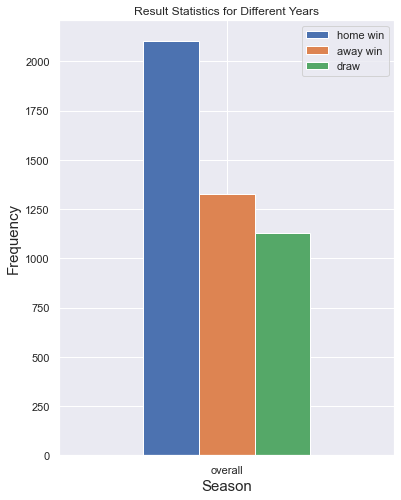

In [417]:
def get_result_stats(df, year):
    return pd.DataFrame(data = [ len(df[df['FTR'] == 'H']),
                                 len(df[df['FTR'] == 'A']),
                                 len(df[df['FTR'] == 'D'])],
                        index = ['home win', 'away win', 'draw'],
                        columns =[year]
                       ).T


result_stats=get_result_stats(data, 'overall')
ax = result_stats.plot(kind='bar', 
                       figsize = [6,8], 
                       title='Result Statistics for Different Years')
plt.xticks(rotation=0)
ax.set_ylabel('Frequency', size=15)
ax.set_xlabel('Season', size=15)


In [418]:
home_win_rate = len(data[data['FTR'] == 'H'])/data.shape[0]
away_win_rate = len(data[data['FTR'] == 'A'])/data.shape[0]
draw_rate=len(data[data['FTR'] == 'D'])/data.shape[0]
print('home win rate = {:.4f}\naway win rate = {:.4f}\ndraw rate={:.4f}'.format(home_win_rate,away_win_rate,draw_rate))

home win rate = 0.4612
away win rate = 0.2912
draw rate=0.2476


### Baseline
We come up with 2 naive prediction strategies as a baseline:

In [419]:
print('accuracy of prediction -all home team will win:'+str(len(data[data['FTR'] == 'H'])/data.shape[0]))
print('accuracy of prediction -all home team will win:'+str(len(data[data['FTR'] == 'A'])/data.shape[0]))

accuracy of prediction -all home team will win:0.4611842105263158
accuracy of prediction -all home team will win:0.2912280701754386


### 1.3 Write an online FIFA data scrapper to get team and players attribute

In [436]:
def team_name_mapper(name):
    team_name_map = {
        'Birmingham City': 'Birmingham',
        'Blackburn Rovers': 'Blackburn',
        'Bolton Wanderers': 'Bolton',
        'Brighton & Hove Albion': 'Brighton',
        'Cardiff City': 'Cardiff',
        'Charlton Athletic': 'Charlton',
        'Derby County': 'Derby',
        'Huddersfield Town': 'Huddersfield',
        'Hull City': 'Hull',
        'Leeds United':'Leeds',
        'Leicester City': 'Leicester',
        'Manchester City': 'Man City',
        'Manchester United': 'Man United',
        'Newcastle United': 'Newcastle',
        'Norwich City': 'Norwich',
        'Queens Park Rangers': 'QPR',
        'Stoke City': 'Stoke',
        'Swansea City': 'Swansea',
        'Tottenham Hotspur': 'Tottenham',
        'West Bromwich Albion': 'West Brom',
        'West Ham United': 'West Ham',
        'Wigan Athletic': 'Wigan',
        'Wolverhampton Wanderers': 'Wolves',
    }
    if name in team_name_map:
        return team_name_map[name]
    else:
        return name
    
def fifa_ova_scrapper(path,start,end,all_df):
    if not os.path.exists(path):
        os.makedirs(path)
    browser = webdriver.Chrome(ChromeDriverManager().install())
    browser.get("https://sofifa.com/teams?type=all&lg%5B%5D=13")
    
    for year in range(start,end+1):
        browser.find_element_by_xpath("//a[contains(@class, 'bp3-button bp3-minimal text dropdown-toggle')]").click()
        time.sleep(1)
        browser.find_element_by_xpath("//a[contains(text(), 'FIFA " + str(format((year % 2000 + 1), '02d')) + "')]").click()
        time.sleep(1)
        teams = [team.text for team in browser.find_elements_by_xpath("//tbody/tr/td[2]/a/div")[::2]]
        ovas = [ova.text for ova in browser.find_elements_by_xpath("//tbody/tr/td[3]/span")]
        df = pd.DataFrame.from_records(zip(teams,ovas), columns=["team", "ova"])
        df['team']=df['team'].apply(team_name_mapper)
        for i in df.index:
            ova_df[df['team'][i]][year+1]=df['ova'][i]
        df.set_index('team', inplace=True)
        df.to_csv("{}/{}.csv".format(path, year+1))
        print("Collected data for", year)
        
def clear_history_based(df):
    
    fix= dict.fromkeys(df.columns,0) 
    for team in df.columns:
        if 0 not in df[team]:
            next
        for i in range(2008,2022):
            if df[team].loc[i]==0:
                df[team].loc[i]=fix[team]
            else:
                fix[team]=df[team].loc[i]
    for team in df.columns:
        if 0 not in df[team]:
            next
        for i in range(2021,2007,-1):
            if df[team].loc[i]==0:
                df[team].loc[i]=fix[team]
            else:
                fix[team]=df[team].loc[i]
                

In [437]:
FIFA_PATH = "Data_Files/ova"
index = [i for i in range(2008,2022)]
columns = data['HomeTeam'].unique()
ova_df = pd.DataFrame(index=index, columns=columns)
ova_df['Leeds'] = np.nan
ova_df['Derby'] = np.nan
ova_df['Charlton'] = np.nan
ova_df['Watford'] = np.nan
fifa_ova_scrapper(FIFA_PATH,2006, 2020,ova_df)
ova_df_test = ova_df.copy()
ova_df_test=ova_df_test.fillna(0)
clear_history_based(ova_df_test)
ova_df_test=ova_df_test.drop('Charlton',axis = 1)
ova_df_test.to_csv("{}/all_team_ova.csv".format(FIFA_PATH))

In [438]:
PATH_PLAYER = "Data_Files/player_stats"
def scrap_data(url,players=False):
    html = requests.get(url)
    soup = BeautifulSoup(html.content,'html.parser')
    columns = [i['data-tooltip'] for i in soup.find(class_='persist-header').find_all(class_='tooltip')]
    
    if players:
        all_data = soup.find(class_='list').find_all('tr')
        data = [[j.string for j in i.find_all(class_='col')] for i in all_data]
        columns.remove('Team & Contract')
        columns.remove('Hits')
    else:
        table = soup.find_all('tr')[1:]
        data = [[i.string for i in j.find_all(class_='col')] for j in table]
    result = pd.DataFrame(data=data,columns=columns)
    if players:
        teams = [i.find_all('a',href=True)[-1].text for i in all_data]
        result['Team'] = pd.Series(teams)
    else:
        teams = [i.find_all('a',href=True)[0].text for i in table]
        result['Team'] = pd.Series(teams)
    return result
def loop_offsets(url,max_offset,year,path):
    df = scrap_data(url+'&offset='+str(0),players=True)
    for i in range(1,max_offset//60+1):
        
        data = scrap_data(url+'&offset='+str(i*60),players=True)
        df = df.append(data) 
    df['Team']=df['Team'].apply(team_name_mapper)
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_csv("{}/{}.csv".format(path, str(year)))
    return df

def yearly_player_data(df,year):
    year_data = pd.read_csv('Data_Files/player_stats/'+str(year)+'.csv',index_col=0)
    year_data['Total Stats'] = pd.to_numeric(year_data['Total Stats'], errors='coerce')
    teams = year_data['Team'].unique()
    for team in teams:
        df[team].loc[year]=year_data[year_data['Team']=='Man United']['Total Stats'].mean()
        
def get_overall_player_data(fromyear, toyear,df):
    for i in range(fromyear,toyear+1):
        yearly_player_data(df,i)

In [439]:
d2021=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13',600,2021,PATH_PLAYER)
d2020=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=200061&set=true',600,2020,PATH_PLAYER)
d2019=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=190075&set=true',600,2019,PATH_PLAYER)
d2018=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=180084&set=true',600,2018,PATH_PLAYER)
d2017=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=170099&set=true',600,2017,PATH_PLAYER)
d2016=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=160058&set=true',600,2016,PATH_PLAYER)
d2015=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=150059&set=true',600,2015,PATH_PLAYER)
d2014=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=140052&set=true',600,2014,PATH_PLAYER)
d2013=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=130034&set=true',600,2013,PATH_PLAYER)
d2012=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=120002&set=true',600,2012,PATH_PLAYER)
d2011=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=110002&set=true',600,2011,PATH_PLAYER)
d2010=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=100002&set=true',600,2010,PATH_PLAYER)
d2009=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=090002&set=true',600,2009,PATH_PLAYER)
d2008=loop_offsets('https://sofifa.com/players?type=all&lg%5B0%5D=13&r=080002&set=true',480,2008,PATH_PLAYER)

In [440]:
index_ps = [i for i in range(2008,2022)]
columns_ps = ova_df_test.columns
ova_ps = pd.DataFrame(index=index_ps, columns=columns_ps)
get_overall_player_data(2008,2021,ova_ps)
ova_ps_c = ova_ps.copy()
ova_ps_c=ova_ps_c.fillna(0)
clear_history_based(ova_ps_c)
ova_ps_c.to_csv("{}/all_players_stats.csv".format(PATH_PLAYER))

### 1.4 Get Google Search Trend with pytrends API

In [72]:
# Sort the data by date
data.index= pd.to_datetime(data.index)
data = data.sort_index()

In [75]:
col = ['Date','HTGPT','ATGPT','HomeTeam','AwayTeam'] 
all_pretrend = pd.DataFrame(index=data.reset_index().index.values, columns=col)
all_pretrend['HomeTeam'] = data.reset_index()['HomeTeam']
all_pretrend['AwayTeam'] = data.reset_index()['AwayTeam']

def team_name_extender(name):
    team_name_map = {
        'Birmingham': 'Birmingham City',
        'Blackburn': 'Blackburn Rovers',
        'Bolton': 'Bolton Wanderers',
        'Brighton': 'Brighton & Hove Albion',
        'Cardiff': 'Cardiff City',
        'Charlton': 'Charlton Athletic',
        'Derby': 'Derby County',
        'Huddersfield': 'Huddersfield Town',
        'Hull': 'Hull City',
        'Leeds':'Leeds United',
        'Leicester': 'Leicester City',
        'Man City': 'Manchester City',
        'Man United': 'Manchester United',
        'Newcastle': 'Newcastle United',
        'Norwich': 'Norwich City',
        'QPR': 'Queens Park Rangers',
        'Stoke': 'Stoke City',
        'Swansea': 'Swansea City',
        'Tottenham': 'Tottenham Hotspur',
        'West Brom': 'West Bromwich Albion',
        'West Ham': 'West Ham United',
        'Wigan': 'Wigan Athletic',
        'Wolves': 'Wolverhampton Wanderers',
    }
    if name in team_name_map:
        return team_name_map[name]
    else:
        return name
name_extender = np.vectorize(team_name_extender)
def get_team_pretrend(teamnames,time_period):
    pytrend = TrendReq(hl='en-US', tz=360)
    #pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), proxies=['https://34.203.233.13:80',], retries=2, backoff_factor=0.1, requests_args={'verify':False})

    pytrend.build_payload(
     kw_list=teamnames,
     cat=0,
     timeframe=time_period,
     gprop='')
    dt = pytrend.interest_over_time()
    return dt

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and (not y%100==0 or y%400 == 0) else 28,
        31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)


In [76]:
from time import sleep
all_pretrend['Date'] = data.index.values
for i in range(len(data)):
    teamnames = []
    teamnames.append(data['HomeTeam'].iloc[i])
    teamnames.append(data['AwayTeam'].iloc[i])
    teamnames=name_extender(teamnames)
    time = all_pretrend['Date'][i]
    om_bf_time = monthdelta(time, -1)
    time_period = ''+om_bf_time.strftime("%Y-%m-%d")+' '+time.strftime("%Y-%m-%d")
    #print(i,teamnames,time_period)
    data_trend = get_team_pretrend(teamnames,time_period)
    all_pretrend['HTGPT'].iloc[i]=data_trend[teamnames[0]].sum()
    all_pretrend['ATGPT'].iloc[i]=data_trend[teamnames[1]].sum()
    if i%70 ==0: sleep(8)
if not os.path.exists('Data_Files/ggltrend'):
    os.makedirs('Data_Files/ggltrend')
all_pretrend.to_csv("Data_Files/ggltrend/trend.csv")

In [389]:
all_pretrend

,Date,HTGPT,ATGPT,HomeTeam,AwayTeam
0,2008-01-11,2010.0,379.0,Arsenal,West Brom
1,2008-01-11,1325.0,795.0,Bolton,Stoke
2,2008-01-11,1715.0,89.0,Everton,Blackburn
3,2008-01-11,1916.0,655.0,Hull,Fulham
4,2008-01-11,2333.0,74.0,Middlesbrough,Tottenham
...,...,...,...,...,...
4555,2020-12-01,413.0,454.0,Leicester,Man United
4556,2020-12-07,376.0,190.0,Man City,Norwich
4557,2020-12-07,278.0,368.0,Newcastle,Liverpool
4558,2020-12-07,1.0,289.0,Southampton,Sheffield United


In [393]:
col = ['Date','HTGPT','ATGPT','HomeTeam','AwayTeam'] 
add_on_test = pd.DataFrame(index=final_test.reset_index().index.values, columns=col)
add_on_test['HomeTeam'] = final_test.reset_index()['HomeTeam']
add_on_test['AwayTeam'] = final_test.reset_index()['AwayTeam']
add_on_test['Date']=final_test.index.values

In [397]:
for i in range(len(add_on_test)):
    teamnames = []
    teamnames.append(add_on_test['HomeTeam'].iloc[i])
    teamnames.append(add_on_test['AwayTeam'].iloc[i])
    teamnames=name_extender(teamnames)
    time_period = '2020-12-16'+' '+'2021-01-09'
    print(i,teamnames,time_period)
    data_trend = get_team_pretrend(teamnames,time_period)
    add_on_test['HTGPT'].iloc[i]=data_trend[teamnames[0]].sum()
    add_on_test['ATGPT'].iloc[i]=data_trend[teamnames[1]].sum()
    if i%70 ==0: sleep(8)


0 ['Arsenal' 'Newcastle United'] 2020-12-16 2021-01-09
1 ['Aston Villa' 'Everton'] 2020-12-16 2021-01-09
2 ['Fulham' 'Chelsea'] 2020-12-16 2021-01-09
3 ['Leeds United' 'Brighton & Hove Albion'] 2020-12-16 2021-01-09
4 ['Leicester City' 'Southampton'] 2020-12-16 2021-01-09
5 ['Liverpool' 'Manchester United'] 2020-12-16 2021-01-09
6 ['Manchester City' 'Crystal Palace'] 2020-12-16 2021-01-09
7 ['Sheffield United' 'Tottenham Hotspur'] 2020-12-16 2021-01-09
8 ['West Ham United' 'Burnley'] 2020-12-16 2021-01-09
9 ['Wolverhampton Wanderers' 'West Bromwich Albion'] 2020-12-16 2021-01-09


In [407]:
alltrend_full = pd.concat([all_pretrend, add_on_test])
alltrend_full=alltrend_full.reset_index()
alltrend_full.to_csv("Data_Files/ggltrend/full_trend.csv")

### 1.3 Data preparation
After cleaning the data we are adding some more label and stats to the data 


In [480]:
# Sort the data by date
data.index= pd.to_datetime(data.index)
data = data.sort_index()

In [481]:
def home_win(result):
    if result =='H': return 2
    elif result =='D': return 1
    else: return 0

#### Concat the epl-test data

In [573]:
DATA_TEST_PATH = 'Data_Files/epl-test.csv'
test_data = pd.read_csv(DATA_TEST_PATH,index_col=0)
test_data = test_data.dropna(axis=1, how='all')
test_data.head()

,HomeTeam,AwayTeam
Date,,
16 Jan 21,Arsenal,Newcastle
16 Jan 21,Aston Villa,Everton
16 Jan 21,Fulham,Chelsea
16 Jan 21,Leeds,Brighton
16 Jan 21,Leicester,Southampton


In [482]:
final_test = pd.DataFrame(index=test_data.index.values, columns=data.columns)
final_test.index= pd.to_datetime(final_test.index)
final_test = final_test.sort_index()
final_test['HomeTeam'] = test_data['HomeTeam']
final_test['AwayTeam'] = test_data['AwayTeam']
final_test=final_test.fillna(0)
frames = [data, final_test]
data = pd.concat(frames)

In [483]:
team_history=data[['HomeTeam','AwayTeam','FTR','FTHG','FTAG']].copy()
team_history['FTR']=team_history['FTR'].apply(home_win)

In [484]:
team_history

,HomeTeam,AwayTeam,FTR,FTHG,FTAG
2008-01-11,Chelsea,Sunderland,2,5,0
2008-01-11,Everton,Fulham,2,1,0
2008-01-11,Man United,Hull,2,4,3
2008-01-11,Middlesbrough,West Ham,1,1,1
2008-01-11,Portsmouth,Wigan,0,1,2
...,...,...,...,...,...
2021-01-16,Liverpool,Man United,0,0,0
2021-01-16,Man City,Crystal Palace,0,0,0
2021-01-16,Sheffield United,Tottenham,0,0,0
2021-01-16,West Ham,Burnley,0,0,0


#### 1.3.1 Get Google Search Trend obtained from previous pytrends API calls
Concate the Google Search Trend data obtained in the previous code.

In [485]:
all_pretrend = pd.read_csv('Data_Files/ggltrend/full_trend.csv')
all_pretrend.index = team_history.index
team_history = pd.concat([team_history, all_pretrend[['HTGPT','ATGPT']]], axis=1)

#### Valid Goals
Next, we tried to get the accumulated valid full time goal (VG) per period of time.<br /> For the home team, it would be (home - away) and for the away team it would be (away-home).

In [486]:
#'VG'-valid full time goal (home - away or away - home) per period of time
team_history['HVG'] = np.nan
team_history['AVG'] = np.nan
team_history['HHVG'] = np.nan
team_history['HAVG'] = np.nan

FULLTIME = 0
HALFTIME = 1
PERIOD = 380*7
def valid_goals_per_period(df,period,time_len):
    hometeam = df['HomeTeam'].unique()
    teams_goals = pd.DataFrame(index=df.index.values, columns=hometeam)
    if time_len==FULLTIME:
        hg = 'FTHG'
        ag = 'FTAG'
    elif time_len==HALFTIME:
        hg = 'HTHG'
        ag = 'HTAG'
    else:
        raise Exception("Sorry, time lenth should be FULLTIME or HALFTIME")
      
    for i in hometeam:
        when_away = np.where(data['AwayTeam'] != i, 0, data[ag] - data[hg])
        teams_goals[i] = np.where(data['HomeTeam'] != i, when_away, data[hg] - data[ag])
    
    for i in range (len(teams_goals)):
        if i%period!=0: 
            teams_goals.iloc[i] += teams_goals.iloc[i-1]

    return teams_goals

#'VG'-valid goal per period of time
def get_valid_full_goals(df,goalcount_df,time_len):
    if time_len==FULLTIME:
        hg = 'HVG'
        ag = 'AVG'
    elif time_len==HALFTIME:
        hg = 'HHVG'
        ag = 'HAVG'
    else:
        raise Exception("Sorry, time lenth should be FULLTIME or HALFTIME")
    for i in range(1,len(df)):
        df[hg].iloc[i]=goalcount_df[df['HomeTeam'].iloc[i]].iloc[i-1]
        df[ag].iloc[i]=goalcount_df[df['AwayTeam'].iloc[i]].iloc[i-1]

full_time_goal_count = valid_goals_per_period(data,PERIOD,FULLTIME)
half_time_goal_count = valid_goals_per_period(data,PERIOD,HALFTIME)
get_valid_full_goals(team_history,full_time_goal_count,FULLTIME)
get_valid_full_goals(team_history,half_time_goal_count,HALFTIME)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Winning score
Here we adding another feature: accumulated periodical win score. We include the the scores for each team grouped by year and season.<br />
Scoring metric:<br />
Win - 2<br />
Draw -1<br />
Lose -0

In [487]:
def period_win_score(df, period):
    hometeam = data['HomeTeam'].unique()
    teams_score = pd.DataFrame(index=df.index.values, columns=hometeam)
    
    for i in range(len(df)):    
        teams_score[df.iloc[i]['HomeTeam'] ][i] = (df.iloc[i]['FTR']=='H' and 4) or (df.iloc[i]['FTR']=='D' and 1) or 0 
        teams_score[df.iloc[i]['AwayTeam']][i] = (df.iloc[i]['FTR']=='A' and 4) or (df.iloc[i]['FTR']=='D' and 1) or 0
    teams_score = teams_score.fillna(0)
    
    for i in range (len(teams_score)):
        if i%period!=0: 
            teams_score.iloc[i] += teams_score.iloc[i-1]
    
    return teams_score

def get_win_score(df,winscore_df):
    for i in range(1,len(df)):
        df['HWS'].iloc[i]=winscore_df[df['HomeTeam'].iloc[i]].iloc[i-1]
        df['AWS'].iloc[i]=winscore_df[df['AwayTeam'].iloc[i]].iloc[i-1]

# home periodical (every 100 game here) win score 
team_history['HWS'] = np.nan
team_history['AWS'] = np.nan
teams_win_score = period_win_score(data,PERIOD)
get_win_score(team_history,teams_win_score)
team_history = team_history.fillna(0)

#### Winning Trend
Here we are adding another feature: win trend. We use it to measure the tendency for a team to win

In [488]:
def win_trend(wcdf,df,period):
    col = ['HWT','AWT']
    wintrend = pd.DataFrame(index=df.index.values, columns=col)
    for i in range(39,len(df)):
        wintrend['HWT'].iloc[i]=(wcdf[df['HomeTeam'].iloc[i]].iloc[i-1]-wcdf[df['HomeTeam'].iloc[i]].iloc[i-period])/period
        wintrend['AWT'].iloc[i]=(wcdf[df['AwayTeam'].iloc[i]].iloc[i-1]-wcdf[df['AwayTeam'].iloc[i]].iloc[i-period])/period
    return wintrend

In [489]:
teams_win_score_ft=period_win_score(data,380*20)
trend = win_trend(teams_win_score_ft,data,38)
team_history = pd.concat([team_history, trend], axis=1)
team_history

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTGPT,ATGPT,HVG,AVG,HHVG,HAVG,HWS,AWS,HWT,AWT
2008-01-11,Chelsea,Sunderland,2,5,0,2010.0,379.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2008-01-11,Everton,Fulham,2,1,0,1325.0,795.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2008-01-11,Man United,Hull,2,4,3,1715.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2008-01-11,Middlesbrough,West Ham,1,1,1,1916.0,655.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2008-01-11,Portsmouth,Wigan,0,1,2,2333.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16,Liverpool,Man United,0,0,0,939.0,352.0,219.0,124.0,103.0,74.0,536.0,450.0,0.236842,0.315789
2021-01-16,Man City,Crystal Palace,0,0,0,239.0,209.0,293.0,-58.0,133.0,-38.0,559.0,274.0,0.315789,0.0263158
2021-01-16,Sheffield United,Tottenham,0,0,0,290.0,59.0,0.0,167.0,1.0,76.0,68.0,463.0,0.421053,0.131579
2021-01-16,West Ham,Burnley,0,0,0,79.0,612.0,-40.0,-50.0,-10.0,-20.0,303.0,247.0,0.105263,0.131579


#### Foul score based on fouls, red cards and yellow cards


In [490]:
def period_foul_score(df, period):
    hometeam = data['HomeTeam'].unique()
    teams_score = pd.DataFrame(index=df.index.values, columns=hometeam)
    
    for i in range(len(df)):    
        teams_score[df.iloc[i]['HomeTeam'] ][i] = df.iloc[i]['HF']+2*df.iloc[i]['HY']+ 3*df.iloc[i]['HR']
        teams_score[df.iloc[i]['AwayTeam']][i] = df.iloc[i]['AF']+2*df.iloc[i]['AY']+ 3*df.iloc[i]['AR']
    teams_score = teams_score.fillna(0)
    
    for i in range (len(teams_score)):
        if i%period!=0: 
            teams_score.iloc[i] += teams_score.iloc[i-1]
    
    return teams_score

def get_foul_score(df,winscore_df):
    for i in range(1,len(df)):
        df['HFS'].iloc[i]=winscore_df[df['HomeTeam'].iloc[i]].iloc[i-1]
        df['AFS'].iloc[i]=winscore_df[df['AwayTeam'].iloc[i]].iloc[i-1]

# home periodical (every 380 game here) win score 
team_history['HFS'] = np.nan
team_history['AFS'] = np.nan
teams_foul_score = period_foul_score(data,380)
get_foul_score(team_history,teams_foul_score)
team_history = team_history.fillna(0)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Corners and Shots on Target
Cumulative corners amount and cumulative shots on target amount

In [491]:
def period_corners(df, period):
    hometeam = data['HomeTeam'].unique()
    teams_score = pd.DataFrame(index=df.index.values, columns=hometeam)
    
    for i in range(len(df)):    
        teams_score[df.iloc[i]['HomeTeam'] ][i] = df.iloc[i]['HC']
        teams_score[df.iloc[i]['AwayTeam']][i] = df.iloc[i]['AC']
    teams_score = teams_score.fillna(0)
    
    for i in range (len(teams_score)):
        if i%period!=0: 
            teams_score.iloc[i] += teams_score.iloc[i-1]
    
    return teams_score

def get_corners(df,winscore_df):
    for i in range(1,len(df)):
        df['HCC'].iloc[i]=winscore_df[df['HomeTeam'].iloc[i]].iloc[i-1]
        df['ACC'].iloc[i]=winscore_df[df['AwayTeam'].iloc[i]].iloc[i-1]

# home periodical (every 380 game here) win score 
team_history['HCC'] = np.nan
team_history['ACC'] = np.nan
teams_corner = period_corners(data,380*7)
get_corners(team_history,teams_corner)
team_history = team_history.fillna(0)

def period_SOT(df, period):
    hometeam = data['HomeTeam'].unique()
    teams_score = pd.DataFrame(index=df.index.values, columns=hometeam)
    
    for i in range(len(df)):    
        teams_score[df.iloc[i]['HomeTeam'] ][i] = df.iloc[i]['HST']
        teams_score[df.iloc[i]['AwayTeam']][i] = df.iloc[i]['AST']
    teams_score = teams_score.fillna(0)
    
    for i in range (len(teams_score)):
        if i%period!=0: 
            teams_score.iloc[i] += teams_score.iloc[i-1]
    
    return teams_score

def get_SOT(df,sot_df):
    for i in range(1,len(df)):
        df['HCST'].iloc[i]=sot_df[df['HomeTeam'].iloc[i]].iloc[i-1]
        df['ACST'].iloc[i]=sot_df[df['AwayTeam'].iloc[i]].iloc[i-1]

# home periodical (every 380 game here) win score 
team_history['HCST'] = np.nan
team_history['ACST'] = np.nan
teams_SOT = period_SOT(data,380*7)
get_SOT(team_history,teams_SOT)
team_history = team_history.fillna(0)

#### Last 3 matches results
We gather both home team's and away team's earlier 3 matches results prior to their game.<br /> 0 means lose and 1 means win.<br />
We also calculate a winning rate for their pior 3 matches.

In [492]:
def match_results(df):
    teams = {}
    for i in df['HomeTeam'].unique():
        teams[i] = {}
    for i in range(len(df)):
        if df.iloc[i].FTR == 'H':
            teams[df.iloc[i].HomeTeam][i] = 1 
            teams[df.iloc[i].AwayTeam][i] = 0 
        elif df.iloc[i].FTR == 'A':
            teams[df.iloc[i].AwayTeam][i] = 1
            teams[df.iloc[i].HomeTeam][i] = 0
        else:
            teams[df.iloc[i].AwayTeam][i] = 0
            teams[df.iloc[i].HomeTeam][i] = 0      
    for i in teams:
        teams[i] = pd.DataFrame.from_dict(teams[i],orient='index')          
    return teams
def get_last3res(df):
    col = ['HR1','HR2','HR3','AR1','AR2','AR3','H3WR','A3WR']
    past3res = pd.DataFrame(index=df.index.values, columns=col)
    res = match_results(df)   
    for i in range(38,len(df)):
        hr = res[df.iloc[i].HomeTeam].loc[:i].tail(4)
        ar = res[df.iloc[i].AwayTeam].loc[:i].tail(4)       
        if hr.size==4:
            hr= hr.iloc[:3]
            past3res['HR1'].iloc[i]=hr.iloc[2][0]
            past3res['HR2'].iloc[i]=hr.iloc[1][0]
            past3res['HR3'].iloc[i]=hr.iloc[0][0]
            past3res['H3WR'].iloc[i]=len(hr[hr[0]==1])/3
        if ar.size==4:
            ar= ar.iloc[:3]
            past3res['AR1'].iloc[i]=ar.iloc[2][0]
            past3res['AR2'].iloc[i]=ar.iloc[1][0]
            past3res['AR3'].iloc[i]=ar.iloc[0][0]
            past3res['A3WR'].iloc[i]=len(ar[ar[0]==1])/3   
    return past3res

res = get_last3res(data)
team_history = pd.concat([team_history, res], axis=1)

In [493]:
team_history

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTGPT,ATGPT,HVG,AVG,HHVG,...,HCST,ACST,HR1,HR2,HR3,AR1,AR2,AR3,H3WR,A3WR
2008-01-11,Chelsea,Sunderland,2,5,0,2010.0,379.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,Everton,Fulham,2,1,0,1325.0,795.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,Man United,Hull,2,4,3,1715.0,89.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,Middlesbrough,West Ham,1,1,1,1916.0,655.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,Portsmouth,Wigan,0,1,2,2333.0,74.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16,Liverpool,Man United,0,0,0,939.0,352.0,219.0,124.0,103.0,...,1135.0,983.0,0,1,1,1,1,1,0.666667,1
2021-01-16,Man City,Crystal Palace,0,0,0,239.0,209.0,293.0,-58.0,133.0,...,1217.0,702.0,1,1,1,0,0,0,1,0
2021-01-16,Sheffield United,Tottenham,0,0,0,290.0,59.0,0.0,167.0,1.0,...,115.0,1061.0,1,1,1,1,0,0,1,0.333333
2021-01-16,West Ham,Burnley,0,0,0,79.0,612.0,-40.0,-50.0,-10.0,...,772.0,512.0,1,0,0,0,0,1,0.333333,0.333333


#### FIFA data
We are getting overall team score and player statistics that is scrapped by 'fifa_stats_scrapper_processor.ipynb' from FIFA websites.

In [494]:
all_team_ova = pd.read_csv('Data_Files/ova/all_team_ova.csv',index_col=0)
def fifaova(df,all_ova):
    '''
    FHTOVA - Home Team Overall Fifa Score
    FATOVA - Away Team Overall Fifa Score
    '''
    col = ['FHTOVA','FATOVA']
    ova = pd.DataFrame(index=df.index.values, columns=col)
    df_ri = df.reset_index(drop=False)
    for i in range(df_ri.shape[0]):
        #ova['FHTOVA'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        #ova['FATOVA'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        ova['FHTOVA'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
        ova['FATOVA'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
    return ova

tova = fifaova(data,all_team_ova)
team_history = pd.concat([team_history, tova], axis=1)

In [495]:
all_player_stats = pd.read_csv('Data_Files/player_stats/all_players_stats.csv',index_col=0)
def fifa_player_stats(df,all_ova):
    '''
    FHTPSM - Home Team Player Stats mean
    FATPSM - Away Team Player Stats mean
    '''
    col = ['FHTPSM','FATPSM']
    ova = pd.DataFrame(index=df.index.values, columns=col)
    df_ri = df.reset_index(drop=False)
    for i in range(df_ri.shape[0]):
        #ova['FHTPSM'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        #ova['FATPSM'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        ova['FHTPSM'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
        ova['FATPSM'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
    return ova

tpls = fifa_player_stats(data,all_player_stats)
team_history = pd.concat([team_history, tpls], axis=1)

In [496]:
all_player_ages = pd.read_csv('Data_Files/player_stats/all_players_ages.csv',index_col=0)
def fifa_player_ages(df,all_ova):
    '''
    FHTPAM - Home Team Player Stats mean
    FATPAM - Away Team Player Stats mean
    '''
    col = ['FHTPAM','FATPAM']
    ova = pd.DataFrame(index=df.index.values, columns=col)
    df_ri = df.reset_index(drop=False)
    for i in range(df_ri.shape[0]):
        #ova['FHTPAM'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        #ova['FATPAM'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['Date'].iloc[i].year]
        
        ova['FHTPAM'].iloc[i]=all_ova[df_ri['HomeTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
        ova['FATPAM'].iloc[i]=all_ova[df_ri['AwayTeam'].iloc[i]].loc[df_ri['index'].iloc[i].year]
    return ova

tpls = fifa_player_ages(data,all_player_ages)
team_history = pd.concat([team_history, tpls], axis=1)

In [497]:
team_history.shape

(4570, 35)

There is not enough historical data so we are dropping the first 38 lines of data to get rid of NaN values

In [498]:
team_history = team_history.iloc[39:]
team_history = team_history.fillna(0)

### All features for training:

- HVG/AVG: Home/Away team fulltime valid goals: home/away fulltime goal - away/home fulltime goal. Resets every 100 match.

- HHVG/HAVG: Home/Away team halftime valid goals: home/away halftime goal - away/home halftime goal. Resets every 100 match.

- HTSR/ATSR: Home/Away shots or target rate.

- HWS/AWS: Home/Away team winning score. Resets every 100 match. Calculated by the following rule:
    - Win = 2
    - D = 1
    - Lose = 0
- HR1/HR2/HR3: Home team's last 3 matches results. 0 means lose and 1 means win.

- AR1/AR2/AR3: Away team's last 3 matches results. 0 means lose and 1 means win.

- H3WR/A3WR: Winning rate of Home/Away team in its last 3 matchs.

- HTPSM/ATPSM: Mean of players stats in Home/Away team. Generated from data extracted from FIFA websites.

- HTOVA/ATOVA: Team overall score for Home/Away team. Data extracted from FIFA websites.


In [499]:
team_history

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTGPT,ATGPT,HVG,AVG,HHVG,...,AR2,AR3,H3WR,A3WR,FHTOVA,FATOVA,FHTPSM,FATPSM,FHTPAM,FATPAM
2008-08-16,Everton,Blackburn,0,2,3,2349.0,487.0,2.0,-4.0,1.0,...,0,0,0.333333,0.000000,76.0,76.0,1449.280000,1375.320000,25.200000,25.960000
2008-08-16,Hull,Fulham,2,2,1,985.0,2431.0,0.0,-2.0,-1.0,...,0,0,0.666667,0.000000,71.0,74.0,1360.392857,1436.440000,26.857143,28.320000
2008-08-16,Middlesbrough,Tottenham,2,2,1,2099.0,1223.0,0.0,2.0,-1.0,...,0,1,0.333333,0.666667,75.0,78.0,1400.040000,1454.840000,24.280000,24.080000
2008-08-16,Sunderland,Liverpool,0,0,1,330.0,2522.0,-7.0,5.0,-2.0,...,1,1,0.000000,1.000000,71.0,81.0,1364.520000,1487.600000,24.880000,24.640000
2008-08-16,West Ham,Wigan,2,2,1,1557.0,895.0,-6.0,-1.0,-1.0,...,0,0,0.000000,0.000000,76.0,72.0,1464.520000,1383.800000,26.400000,26.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16,Liverpool,Man United,0,0,0,939.0,352.0,219.0,124.0,103.0,...,1,1,0.666667,1.000000,85.0,82.0,1842.363636,1890.363636,24.515152,25.212121
2021-01-16,Man City,Crystal Palace,0,0,0,239.0,209.0,293.0,-58.0,133.0,...,0,0,1.000000,0.000000,84.0,77.0,1842.939394,1713.272727,23.818182,26.969697
2021-01-16,Sheffield United,Tottenham,0,0,0,290.0,59.0,0.0,167.0,1.0,...,0,0,1.000000,0.333333,75.0,82.0,1656.606061,1863.909091,25.000000,24.909091
2021-01-16,West Ham,Burnley,0,0,0,79.0,612.0,-40.0,-50.0,-10.0,...,0,1,0.333333,0.333333,78.0,76.0,1687.515152,1698.151515,25.484848,25.151515


#### We sparate the matchs on 2021 for later prediction, from the rest of data from 2018-2020

In [503]:
final_test_data = team_history[-10:]
final_train_data=team_history[:-10]

### 1.4 Feature Selection
#### Feature correlation map
As we can see, to FTR, the HHVG and HAVG has correlation similar but less strong to HVG and AVG. So we are eliminating HHAG and HAVG.Player stats are less correlated so we eliminate that as well

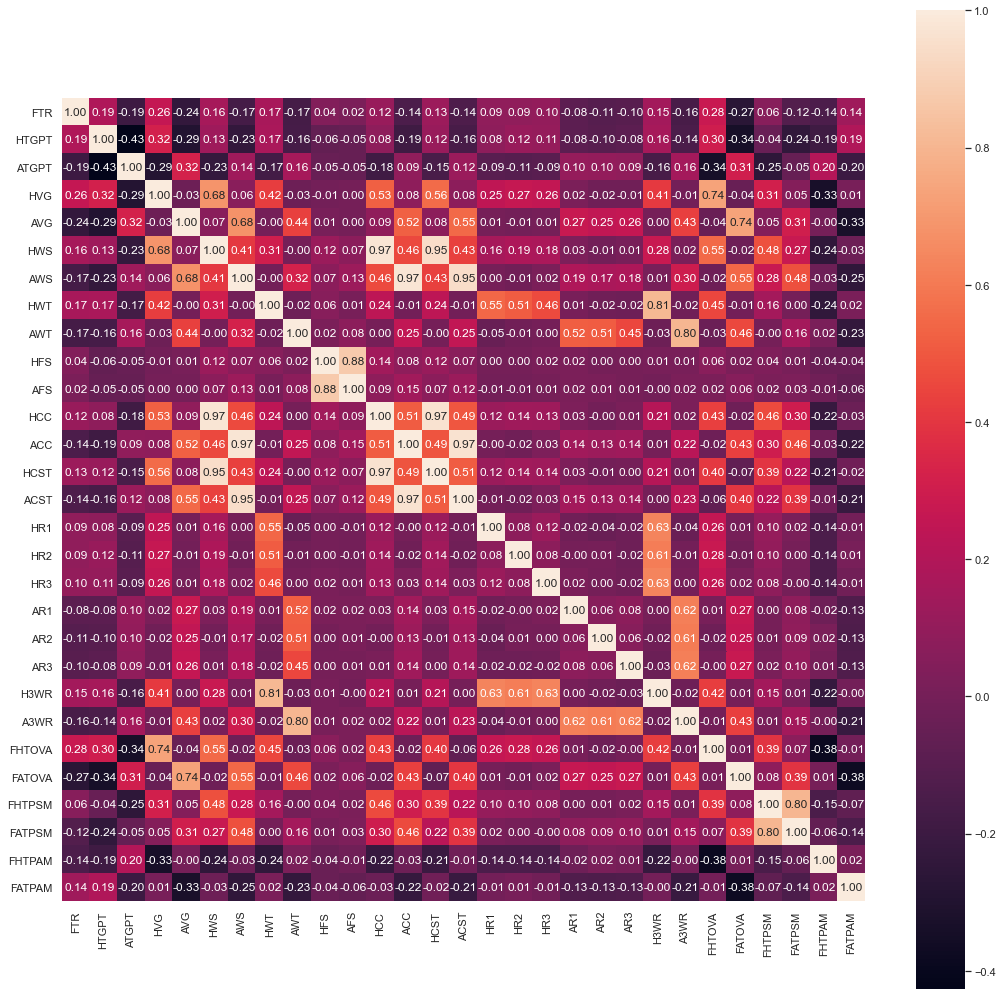

In [504]:
def show_heatmap(df):
    plt.figure(figsize=(18,18))
    sns.set(font_scale=1)
    ax = sns.heatmap(df.corr(),annot=True,square=True, fmt=".2f")
    plt.show()

final_data = team_history.drop(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG','HHVG','HAVG'],1, inplace=False)
show_heatmap(final_data)

In [505]:
final_test_data = final_data[-10:]
final_train_data=final_data[:-10]

In [507]:
final_train_data

,FTR,HTGPT,ATGPT,HVG,AVG,HWS,AWS,HWT,AWT,HFS,...,AR2,AR3,H3WR,A3WR,FHTOVA,FATOVA,FHTPSM,FATPSM,FHTPAM,FATPAM
2008-08-16,0,2349.0,487.0,2.0,-4.0,9.0,1.0,0.131579,0.026316,65.0,...,0,0,0.333333,0.000000,76.0,76.0,1449.280000,1375.320000,25.200000,25.960000
2008-08-16,2,985.0,2431.0,0.0,-2.0,8.0,1.0,0.210526,0.026316,65.0,...,0,0,0.666667,0.000000,71.0,74.0,1360.392857,1436.440000,26.857143,28.320000
2008-08-16,2,2099.0,1223.0,0.0,2.0,5.0,8.0,0.105263,0.210526,42.0,...,0,1,0.333333,0.666667,75.0,78.0,1400.040000,1454.840000,24.280000,24.080000
2008-08-16,0,330.0,2522.0,-7.0,5.0,1.0,13.0,0.026316,0.342105,49.0,...,1,1,0.000000,1.000000,71.0,81.0,1364.520000,1487.600000,24.880000,24.640000
2008-08-16,2,1557.0,895.0,-6.0,-1.0,2.0,5.0,0.026316,0.026316,82.0,...,0,0,0.000000,0.000000,76.0,72.0,1464.520000,1383.800000,26.400000,26.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,0,413.0,454.0,-71.0,288.0,62.0,555.0,0.026316,0.315789,497.0,...,1,0,0.000000,0.666667,76.0,85.0,1680.363636,1819.181818,24.363636,24.303030
2020-12-07,2,376.0,190.0,-76.0,-56.0,62.0,274.0,0.026316,0.052632,506.0,...,0,0,0.000000,0.000000,76.0,77.0,1680.363636,1672.666667,24.363636,25.212121
2020-12-07,2,278.0,368.0,-89.0,41.0,258.0,362.0,0.131579,0.105263,480.0,...,1,0,0.000000,0.333333,76.0,79.0,1744.939394,1752.303030,24.242424,24.454545
2020-12-07,2,1.0,289.0,9.0,0.0,143.0,323.0,0.026316,0.236842,479.0,...,0,0,0.000000,0.333333,78.0,78.0,1707.454545,1742.424242,22.515152,23.484848


We split data to features-X_all and target-y_all.<br />
Then we scale X_all.

In [508]:
#X_all = final_data.drop(['FTR','HHVG','HAVG','HTPAM','ATPAM'],1, inplace=False)
X_all = final_train_data.drop(['FTR'],1, inplace=False)
#X_all = final_data.drop(['FTR','ATPSM','HTPSM'],1, inplace=False)
#X_all = final_data.drop(['FTR','HHVG','HAVG','ATPSM','HTPSM','HR1','HR2','HR3','AR1','AR2','AR3','H3WR','A3WR'],1, inplace=False)
y_all = final_train_data['FTR']
y_all=y_all.reset_index(drop=True)

In [509]:
X_all

,HTGPT,ATGPT,HVG,AVG,HWS,AWS,HWT,AWT,HFS,AFS,...,AR2,AR3,H3WR,A3WR,FHTOVA,FATOVA,FHTPSM,FATPSM,FHTPAM,FATPAM
2008-08-16,2349.0,487.0,2.0,-4.0,9.0,1.0,0.131579,0.026316,65.0,55.0,...,0,0,0.333333,0.000000,76.0,76.0,1449.280000,1375.320000,25.200000,25.960000
2008-08-16,985.0,2431.0,0.0,-2.0,8.0,1.0,0.210526,0.026316,65.0,40.0,...,0,0,0.666667,0.000000,71.0,74.0,1360.392857,1436.440000,26.857143,28.320000
2008-08-16,2099.0,1223.0,0.0,2.0,5.0,8.0,0.105263,0.210526,42.0,59.0,...,0,1,0.333333,0.666667,75.0,78.0,1400.040000,1454.840000,24.280000,24.080000
2008-08-16,330.0,2522.0,-7.0,5.0,1.0,13.0,0.026316,0.342105,49.0,65.0,...,1,1,0.000000,1.000000,71.0,81.0,1364.520000,1487.600000,24.880000,24.640000
2008-08-16,1557.0,895.0,-6.0,-1.0,2.0,5.0,0.026316,0.026316,82.0,62.0,...,0,0,0.000000,0.000000,76.0,72.0,1464.520000,1383.800000,26.400000,26.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,413.0,454.0,-71.0,288.0,62.0,555.0,0.026316,0.315789,497.0,465.0,...,1,0,0.000000,0.666667,76.0,85.0,1680.363636,1819.181818,24.363636,24.303030
2020-12-07,376.0,190.0,-76.0,-56.0,62.0,274.0,0.026316,0.052632,506.0,514.0,...,0,0,0.000000,0.000000,76.0,77.0,1680.363636,1672.666667,24.363636,25.212121
2020-12-07,278.0,368.0,-89.0,41.0,258.0,362.0,0.131579,0.105263,480.0,466.0,...,1,0,0.000000,0.333333,76.0,79.0,1744.939394,1752.303030,24.242424,24.454545
2020-12-07,1.0,289.0,9.0,0.0,143.0,323.0,0.026316,0.236842,479.0,556.0,...,0,0,0.000000,0.333333,78.0,78.0,1707.454545,1742.424242,22.515152,23.484848


### Devide X_all to 3 class datasets

X_all_a -  with only features from Google Search and FIFA <br />
X_all_b -  with only features from historical EPL and FIFA <br />
X_all_c -  with all features

In [510]:
X_all=X_all.fillna(0)
X_all_c = X_all.copy()
X_all_a = X_all[['HTGPT', 'ATGPT','FHTPSM', 'FHTOVA', 'FATOVA', 'FATPSM', 'FHTPAM',  'FATPAM']]
X_all_b = X_all.drop(['HTGPT','ATGPT'],1, inplace=False)

min_max_scaler = preprocessing.MinMaxScaler()
X_all_a = pd.DataFrame(min_max_scaler.fit_transform(X_all_a))
X_all_b = pd.DataFrame(min_max_scaler.fit_transform(X_all_b))
X_all_c = pd.DataFrame(min_max_scaler.fit_transform(X_all_c))

## 2. Training and Evaluating

We trained model using muptiple supervised learning approaches. <br />
To evaluate our models, we used K-Fold Cross validation.

### 2.0 What is K-Fold Validation?
Our various models are all trained and validated on equivalent on the same dataset. This poses a challenge since we want maximise the accuracy of the model by using as much of the dataset as possible for training, but we also want to have a large enough validation dataset. <br />


Instead of using a traditional: 75%-training, 25%-evaluation datset split, we instead divide the entire dataset into 'n' folds. <br />
The model is then trained n-times - for each model iteration the validation set is chosen as the corresponding nth fold and the training set as the rest of the dataset. <br />

The performance of the model then evaluated as:

$$Performance = \frac{1}{n}\sum_{i=1}^{n} Performance_i$$


We end up with a model which is __validated on the entire dataset__, maiximsing both the accuracy and robustness in the process.



In [125]:
def train_predict_clf(clf, X, y, k):
    cv = KFold(n_splits=k)
    prediction = []
    prediction=np.array(prediction)
    i=1
    print("{} fold cross validation for: {} model\n".format(k,clf.__class__.__name__))
    for train_idx, test_idx in cv.split(X):
        #print('train: %s, test: %s' % (train, test))
        X_train, X_test, y_train, y_test = X[X.index.isin(train_idx)], X[X.index.isin(test_idx)], y[train_idx], y[test_idx]
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        prediction= np.append(prediction,y_pred,axis=0)
        if clf.__class__.__name__ == 'KerasClassifier':
            print("\n")
        print("Fold{}   accuracy: {:.4f},  f1 score: {:.4f}".format(i,accuracy_score(y_test, y_pred),f1_score(y_test, y_pred, average='macro')))
        if clf.__class__.__name__ == 'KerasClassifier':
            print("\n")
        i+=1
    return prediction

def train_evaluate(clf, X, y, k):
    """
    k-fold cross validation on clf classifier model, k = number of folds
    """
    prediction = train_predict_clf(clf, X, y, k)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=KFold(n_splits=k), n_jobs=-1)
    print('OVA Classification report:')
    print(classification_report(y, prediction,target_names=['A', 'D', 'H']))
    print('accuracy:{:.4f}'.format(accuracy_score(y, prediction)))

Then we use RFECV(Recursive feature elimination with cross-validation) that could tune the number of features selected with cross-validation

In [518]:
def train_rfecv(clf,X,y,k):
    min_features_to_select = 1  # Minimum number of features to consider
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(k),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
    rfecv.fit(X, y)
    print(rfecv.ranking_)
    print(rfecv.support_)
    p = rfecv.predict(X)
    return p,rfecv.support_,rfecv


### 2.1 Lazy Learning: KNN

In [512]:
%%capture --no-stdout
# 3-fold cross validated KNN
train_evaluate(KNeighborsClassifier(n_neighbors=300), X_all_a, y_all, 4)

4 fold cross validation for: KNeighborsClassifier model

Fold1   accuracy: 0.5252,  f1 score: 0.3735
Fold2   accuracy: 0.5319,  f1 score: 0.3803
Fold3   accuracy: 0.5248,  f1 score: 0.3836
Fold4   accuracy: 0.5442,  f1 score: 0.3956
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.45      0.49      1315
           D       0.38      0.00      0.01      1120
           H       0.53      0.86      0.66      2086

    accuracy                           0.53      4521
   macro avg       0.48      0.44      0.38      4521
weighted avg       0.49      0.53      0.45      4521

accuracy:0.5315


In [134]:
%%capture --no-stdout
# 4-folds cross validated KNN
train_evaluate(KNeighborsClassifier(n_neighbors=300), X_all_b, y_all, 4)

4 fold cross validation for: KNeighborsClassifier model

Fold1   accuracy: 0.5031,  f1 score: 0.3157
Fold2   accuracy: 0.5027,  f1 score: 0.3444
Fold3   accuracy: 0.4912,  f1 score: 0.3276
Fold4   accuracy: 0.5168,  f1 score: 0.3566
OVA Classification report:
              precision    recall  f1-score   support

           A       0.52      0.28      0.36      1315
           D       1.00      0.00      0.00      1120
           H       0.50      0.91      0.65      2086

    accuracy                           0.50      4521
   macro avg       0.67      0.40      0.34      4521
weighted avg       0.63      0.50      0.40      4521

accuracy:0.5034


In [135]:
%%capture --no-stdout
# 4-folds cross validated KNN
train_evaluate(KNeighborsClassifier(n_neighbors=300), X_all_c, y_all, 4)

4 fold cross validation for: KNeighborsClassifier model

Fold1   accuracy: 0.5093,  f1 score: 0.3290
Fold2   accuracy: 0.5027,  f1 score: 0.3455
Fold3   accuracy: 0.4947,  f1 score: 0.3343
Fold4   accuracy: 0.5212,  f1 score: 0.3593
OVA Classification report:
              precision    recall  f1-score   support

           A       0.52      0.30      0.38      1315
           D       0.50      0.00      0.00      1120
           H       0.50      0.91      0.65      2086

    accuracy                           0.51      4521
   macro avg       0.51      0.40      0.34      4521
weighted avg       0.51      0.51      0.41      4521

accuracy:0.5070


### 2.2 Naive Bayes

In [136]:
# 4-fold validated Naive Bayes model
print('For feature set A')
train_evaluate(GaussianNB(var_smoothing=1.2), X_all_a, y_all, 4)
print('For feature set B')
train_evaluate(GaussianNB(var_smoothing=1.2), X_all_b, y_all, 4)
print('For feature set C')
train_evaluate(GaussianNB(var_smoothing=1.2), X_all_c, y_all, 4)

4 fold cross validation for: GaussianNB model

Fold1   accuracy: 0.5172,  f1 score: 0.4237
Fold2   accuracy: 0.5239,  f1 score: 0.3758
Fold3   accuracy: 0.5168,  f1 score: 0.3717
Fold4   accuracy: 0.5549,  f1 score: 0.4009
OVA Classification report:
              precision    recall  f1-score   support

           A       0.51      0.46      0.49      1315
           D       0.32      0.03      0.05      1120
           H       0.54      0.84      0.66      2086

    accuracy                           0.53      4521
   macro avg       0.46      0.44      0.40      4521
weighted avg       0.48      0.53      0.46      4521

accuracy:0.5282


### 2.3 SVC

In [250]:
def tune_SVC(X,y):
    params = {'C': [0.3,0.4, 0.5, 0.6],
                'gamma': [0.05, 0.1, 0.15],
                'kernel': ['linear', 'rbf', 'poly']}
    grid = GridSearchCV(SVC(   class_weight=None,
                               degree=1,
                               probability=True,
                               shrinking=True,
                               tol=0.0005),
                              params,
                              refit=True, verbose=2, cv=5)
    grid.fit(X, y)
    svc,bestparam = grid.best_estimator_,grid.best_params_
    return svc,bestparam

In [252]:
tuned_svc_a,best_param_a = tune_SVC(X_all_a,y_all)
tuned_svc_b,best_param_b = tune_SVC(X_all_b,y_all)
tuned_svc_c,best_param_c = tune_SVC(X_all_c,y_all)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.1s
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   1.9s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   1.8s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   1.9s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   1.9s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.2s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   2.9s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   2.9s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .

[CV] ................... C=0.4, gamma=0.05, kernel=poly, total=   2.3s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.2s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.1s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.0s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.0s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.1s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.4, gamma=0.1, kernel=rbf, total=   3.2s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.2s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.0s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   1.9s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.5s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] .

[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.2s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.3s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.3s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.5s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.2s
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.2s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.2s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.4s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.4s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.2s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .

[CV] ................... C=0.4, gamma=0.05, kernel=poly, total=   2.3s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.2s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.3s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.2s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.3s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   2.4s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.4, gamma=0.1, kernel=rbf, total=   3.4s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.6s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.7s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.8s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.6s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.4s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.5s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.6s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] .

[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.4s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  8.4min finished


In [311]:
print(best_param_a)
print(best_param_b)
print(best_param_c)

{'C': 0.5, 'gamma': 0.15, 'kernel': 'rbf'}
{'C': 0.3, 'gamma': 0.05, 'kernel': 'linear'}
{'C': 0.5, 'gamma': 0.15, 'kernel': 'poly'}


In [253]:
train_evaluate(tuned_svc_a, X_all_a, y_all, 4)
train_evaluate(tuned_svc_b, X_all_b, y_all, 4)
train_evaluate(tuned_svc_c, X_all_c, y_all, 4)

4 fold cross validation for: SVC model

Fold1   accuracy: 0.5332,  f1 score: 0.3732
Fold2   accuracy: 0.5389,  f1 score: 0.3903
Fold3   accuracy: 0.5248,  f1 score: 0.3821
Fold4   accuracy: 0.5469,  f1 score: 0.3977
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.47      0.50      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.87      0.66      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.39      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5359
4 fold cross validation for: SVC model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5305,  f1 score: 0.3620
Fold2   accuracy: 0.5372,  f1 score: 0.3892
Fold3   accuracy: 0.5310,  f1 score: 0.3843
Fold4   accuracy: 0.5425,  f1 score: 0.3952
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.45      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.88      0.66      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.38      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5353
4 fold cross validation for: SVC model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5349,  f1 score: 0.3776
Fold2   accuracy: 0.5345,  f1 score: 0.3882
Fold3   accuracy: 0.5274,  f1 score: 0.3793
Fold4   accuracy: 0.5425,  f1 score: 0.3951
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.47      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.87      0.66      2086

    accuracy                           0.53      4521
   macro avg       0.35      0.44      0.39      4521
weighted avg       0.40      0.53      0.45      4521

accuracy:0.5348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 2.3.1 RFECV for SVC

Another approach that use RFECV to select features for models then apply hyper parameter tuning.

In [519]:
prediction_a,feature_selection_a,rfecv_svc_a = train_rfecv(SVC(kernel="linear"), X_all_a,y_all,4)
prediction_b,feature_selection_b,rfecv_svc_b = train_rfecv(SVC(kernel="linear"), X_all_b,y_all,4)
prediction_c,feature_selection_c,rfecv_svc_c = train_rfecv(SVC(kernel="linear"), X_all_c,y_all,4)

[1 3 2 1 1 1 1 1]
[ True False False  True  True  True  True  True]
[ 1  3  7  2  4 11 12 19 15  1  6  8 17 20 18 22 14 21 13 16  1  1 10  5
  9  1]
[ True False False False False False False False False  True False False
 False False False False False False False False  True  True False False
 False  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True]


In [520]:
print(prediction_a)
print(classification_report(y_all, prediction_a,target_names=['A', 'D', 'H']))
print('accuracy:{:.4f}'.format(accuracy_score(y_all, prediction)))
print(prediction_b)
print(classification_report(y_all, prediction_b,target_names=['A', 'D', 'H']))
print('accuracy:{:.4f}'.format(accuracy_score(y_all, prediction_b)))
print(prediction_c)
print(classification_report(y_all, prediction_c,target_names=['A', 'D', 'H']))
print('accuracy:{:.4f}'.format(accuracy_score(y_all, prediction_c)))

[2 2 2 ... 0 2 2]
              precision    recall  f1-score   support

           A       0.51      0.50      0.51      1315
           D       0.00      0.00      0.00      1120
           H       0.55      0.85      0.66      2086

    accuracy                           0.54      4521
   macro avg       0.35      0.45      0.39      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5364
[2 2 2 ... 0 2 2]
              precision    recall  f1-score   support

           A       0.52      0.51      0.51      1315
           D       0.00      0.00      0.00      1120
           H       0.55      0.85      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.45      0.39      4521
weighted avg       0.40      0.54      0.46      4521

accuracy:0.5395
[2 2 2 ... 0 2 2]
              precision    recall  f1-score   support

           A       0.52      0.49      0.51      1315
           D       0.00      0.00      0.00

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [316]:
X_all_a_rfe = X_all_a[X_all_a.columns[feature_selection_a]]
X_all_b_rfe = X_all_b[X_all_b.columns[feature_selection_b]]
X_all_c_rfe = X_all_c[X_all_c.columns[feature_selection_c]]

In [317]:
tuned_rfe_svc_a,best_rfe_param_a = tune_SVC(X_all_a_rfe,y_all)
tuned_rfe_svc_b,best_rfe_param_b = tune_SVC(X_all_b_rfe,y_all)
tuned_rfe_svc_c,best_rfe_param_c = tune_SVC(X_all_c_rfe,y_all)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.9s
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.8s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.8s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.8s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.8s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.5s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.9s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.7s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .

[CV] ................... C=0.4, gamma=0.05, kernel=poly, total=   0.9s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.4, gamma=0.1, kernel=rbf, total=   1.6s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   0.9s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   0.9s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   0.9s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   0.8s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   0.8s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   0.8s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   0.8s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] .

[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.7s
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.7s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.7s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.7s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   0.7s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.4s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.4s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   1.4s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .

[CV] ................... C=0.4, gamma=0.05, kernel=poly, total=   0.9s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   0.9s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.4, gamma=0.1, kernel=rbf, total=   1.7s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   1.4s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   1.4s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   1.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   1.2s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   1.2s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   1.1s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   1.1s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] .

[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   1.0s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   1.0s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   1.0s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   0.9s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=linear ................................
[CV] ................. C=0.3, gamma=0.05, kernel=linear, total=   2.3s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.7s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.8s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.3, gamma=0.05, kernel=rbf, total=   3.8s
[CV] C=0.3, gamma=0.05, kernel=rbf ...................................
[CV] .

[CV] ................... C=0.4, gamma=0.05, kernel=poly, total=   3.2s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   3.0s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   3.0s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   3.0s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   3.2s
[CV] C=0.4, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.4, gamma=0.1, kernel=linear, total=   3.4s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.4, gamma=0.1, kernel=rbf, total=   5.2s
[CV] C=0.4, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.4s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.4s
[CV] C=0.5, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.5, gamma=0.1, kernel=poly, total=   2.4s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.4s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] ................. C=0.5, gamma=0.15, kernel=linear, total=   2.3s
[CV] C=0.5, gamma=0.15, kernel=linear ................................
[CV] .

[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.6s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.6s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.6s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.6s
[CV] C=0.6, gamma=0.15, kernel=poly ..................................
[CV] ................... C=0.6, gamma=0.15, kernel=poly, total=   2.3s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  9.2min finished


In [318]:
print(best_rfe_param_a)
print(best_rfe_param_b)
print(best_rfe_param_c)

{'C': 0.6, 'gamma': 0.15, 'kernel': 'rbf'}
{'C': 0.3, 'gamma': 0.05, 'kernel': 'linear'}
{'C': 0.6, 'gamma': 0.05, 'kernel': 'rbf'}


In [319]:
train_evaluate(tuned_rfe_svc_a, X_all_a_rfe, y_all, 4)
train_evaluate(tuned_rfe_svc_b, X_all_b_rfe, y_all, 4)
train_evaluate(tuned_rfe_svc_c, X_all_c_rfe, y_all, 4)

4 fold cross validation for: SVC model

Fold1   accuracy: 0.5340,  f1 score: 0.3723
Fold2   accuracy: 0.5460,  f1 score: 0.3947
Fold3   accuracy: 0.5257,  f1 score: 0.3827
Fold4   accuracy: 0.5442,  f1 score: 0.3956
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.46      0.50      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.87      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.45      0.39      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5375
4 fold cross validation for: SVC model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5314,  f1 score: 0.3831
Fold2   accuracy: 0.5416,  f1 score: 0.3927
Fold3   accuracy: 0.5230,  f1 score: 0.3784
Fold4   accuracy: 0.5549,  f1 score: 0.4056
OVA Classification report:
              precision    recall  f1-score   support

           A       0.52      0.49      0.50      1315
           D       0.00      0.00      0.00      1120
           H       0.55      0.85      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.35      0.45      0.39      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5377
4 fold cross validation for: SVC model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5376,  f1 score: 0.3767
Fold2   accuracy: 0.5381,  f1 score: 0.3897
Fold3   accuracy: 0.5212,  f1 score: 0.3709
Fold4   accuracy: 0.5442,  f1 score: 0.3938
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.44      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.53      0.88      0.66      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.38      4521
weighted avg       0.40      0.54      0.45      4521

accuracy:0.5353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4 Logistic regression

In [ ]:
def tune_LR(X,y):
    params = {'C': [0.001,0.005,0.01,0.09,0.4,5,10,25]}
    grid = GridSearchCV(LogisticRegression(penalty='l1',multi_class='multinomial', solver='saga',
                                               ),
                                               params,
                                                scoring='accuracy',
                                               refit=True, verbose=2, cv=5)
    grid.fit(X, y)
    lr = grid.best_estimator_
    return lr

In [220]:
# 4-fold validated Logistic Regression model
tuned_lr_a = tune_LR(X_all_a,y_all)
tuned_lr_b = tune_LR(X_all_b,y_all)
tuned_lr_c = tune_LR(X_all_c,y_all)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.005 .........................................................
[CV] .......................................... C=0.005, total=   0.0s
[CV] C=0.005 .........................................................
[CV] ............

In [265]:
train_evaluate(tuned_lr_a, X_all_a, y_all, 4)
train_evaluate(tuned_lr_b, X_all_b, y_all, 4)
train_evaluate(tuned_lr_c, X_all_c, y_all, 4)

4 fold cross validation for: LogisticRegression model

Fold1   accuracy: 0.5164,  f1 score: 0.3807
Fold2   accuracy: 0.5248,  f1 score: 0.3808
Fold3   accuracy: 0.5248,  f1 score: 0.3868
Fold4   accuracy: 0.5469,  f1 score: 0.3957
OVA Classification report:
              precision    recall  f1-score   support

           A       0.49      0.50      0.50      1315
           D       0.25      0.00      0.00      1120
           H       0.54      0.83      0.66      2086

    accuracy                           0.53      4521
   macro avg       0.43      0.44      0.39      4521
weighted avg       0.46      0.53      0.45      4521

accuracy:0.5282
4 fold cross validation for: LogisticRegression model

Fold1   accuracy: 0.5279,  f1 score: 0.3842
Fold2   accuracy: 0.5274,  f1 score: 0.3831
Fold3   accuracy: 0.5274,  f1 score: 0.3844
Fold4   accuracy: 0.5469,  f1 score: 0.3975
OVA Classification report:
              precision    recall  f1-score   support

           A       0.50      0.5

### 2.4 Gradiant Boosting

In [181]:
%%capture --no-stdout
# 3-fold Gradient Boost Model
train_evaluate(xgb.XGBClassifier(learning_rate=0.01,
                                 n_estimators=1000,
                                 max_depth=2,
                                 min_child_weight=7,
                                 gamma=5,
                                 subsample=0.9,
                                 colsample_bytree=0.9,
                                 reg_alpha=1e-5,
                                 booster='gbtree',
                                 eval_metric="mlogloss",
                                 num_class=3,
                                 use_label_encoder=False), X_all_a, y_all, 4)

4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5385,  f1 score: 0.3901
Fold2   accuracy: 0.5381,  f1 score: 0.3946
Fold3   accuracy: 0.5301,  f1 score: 0.3841
Fold4   accuracy: 0.5434,  f1 score: 0.3915
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.45      0.49      1315
           D       0.26      0.01      0.01      1120
           H       0.54      0.88      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.45      0.44      0.39      4521
weighted avg       0.47      0.54      0.45      4521

accuracy:0.5375


In [182]:
%%capture --no-stdout
# 3-fold Gradient Boost Model
train_evaluate(xgb.XGBClassifier(learning_rate=0.01,
                                 n_estimators=1000,
                                 max_depth=2,
                                 min_child_weight=7,
                                 gamma=5,
                                 subsample=0.9,
                                 colsample_bytree=0.9,
                                 reg_alpha=1e-5,
                                 booster='gbtree',
                                 eval_metric="mlogloss",
                                 num_class=3,
                                 use_label_encoder=False), X_all_b, y_all, 4)

4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5411,  f1 score: 0.3908
Fold2   accuracy: 0.5372,  f1 score: 0.3863
Fold3   accuracy: 0.5221,  f1 score: 0.3816
Fold4   accuracy: 0.5469,  f1 score: 0.3973
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.46      0.50      1315
           D       0.19      0.00      0.01      1120
           H       0.54      0.87      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.42      0.45      0.39      4521
weighted avg       0.45      0.54      0.45      4521

accuracy:0.5368


In [184]:
%%capture --no-stdout
# 3-fold Gradient Boost Model
train_evaluate(xgb.XGBClassifier(learning_rate=0.01,
                                 n_estimators=1000,
                                 max_depth=2,
                                 min_child_weight=7,
                                 gamma=5,
                                 subsample=0.9,
                                 colsample_bytree=0.9,
                                 reg_alpha=1e-5,
                                 booster='gbtree',
                                 eval_metric="mlogloss",
                                 num_class=3,
                                 use_label_encoder=False), X_all_c, y_all, 4)

4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5287,  f1 score: 0.3917
Fold2   accuracy: 0.5363,  f1 score: 0.3934
Fold3   accuracy: 0.5204,  f1 score: 0.3826
Fold4   accuracy: 0.5442,  f1 score: 0.3947
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.46      0.49      1315
           D       0.22      0.01      0.02      1120
           H       0.54      0.86      0.66      2086

    accuracy                           0.53      4521
   macro avg       0.43      0.44      0.39      4521
weighted avg       0.46      0.53      0.45      4521

accuracy:0.5324


#### Tuning hyperparameter using exhaustive grid search

In [266]:
def tune_xgb(X,y):
    folds = 4
    param_comb = 5
    params = {"learning_rate" : [0.001, 0.01, 0.03, 0.5 ] ,
     "max_depth"        : [ 2, 3, 4, 8, 10],
     "min_child_weight" : [ 3, 5, 7, 9 ],
     "gamma"            : [ 0.5, 1, 2.5, 5,8],
     "colsample_bytree" : [ 0.6, 0.7, 0.8 , 0.9 ] }
    xgb_tuned = xgb.XGBClassifier(
                                 n_estimators=1000,
                                 subsample=0.9,
                                 reg_alpha=1e-5,
                                 booster='gbtree',
                                 eval_metric="mlogloss",
                                 num_class=3,
                                 use_label_encoder=False)
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

    random_search = RandomizedSearchCV(xgb_tuned, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )
    random_search.fit(X, y)
    
    return random_search.best_estimator_

#### 4-fold training-evaluation of tuned GB model
 (folds = 4 was chosen because it performed best in the non-exhaustive grid search GB model)

In [267]:
tuned_xgb = tune_xgb(X_all_a,y_all)
# 4-fold training-evaluation of tuned GB model
# (folds = 4 was chosen because it performed best in the non-exhaustive grid search GB model)
train_evaluate(xgb_best, X_all_a,y_all, 4)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.3min finished


4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5367,  f1 score: 0.3857
Fold2   accuracy: 0.5381,  f1 score: 0.3895
Fold3   accuracy: 0.5327,  f1 score: 0.3868
Fold4   accuracy: 0.5416,  f1 score: 0.3885
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.45      0.49      1315
           D       0.25      0.00      0.01      1120
           H       0.54      0.88      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.44      0.44      0.39      4521
weighted avg       0.47      0.54      0.45      4521

accuracy:0.5373


In [268]:
tuned_xgb = tune_xgb(X_all_b,y_all)
# 4-fold training-evaluation of tuned GB model
# (folds = 4 was chosen because it performed best in the non-exhaustive grid search GB model)
train_evaluate(xgb_best, X_all_b,y_all, 4)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  4.5min finished


4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5393,  f1 score: 0.3853
Fold2   accuracy: 0.5434,  f1 score: 0.3912
Fold3   accuracy: 0.5221,  f1 score: 0.3790
Fold4   accuracy: 0.5460,  f1 score: 0.3963
OVA Classification report:
              precision    recall  f1-score   support

           A       0.54      0.46      0.50      1315
           D       0.08      0.00      0.00      1120
           H       0.54      0.87      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.39      0.45      0.39      4521
weighted avg       0.43      0.54      0.45      4521

accuracy:0.5377


In [269]:
tuned_xgb = tune_xgb(X_all_c,y_all)
# 4-fold training-evaluation of tuned GB model
# (folds = 4 was chosen because it performed best in the non-exhaustive grid search GB model)
train_evaluate(xgb_best, X_all_c,y_all, 4)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  6.8min finished


4 fold cross validation for: XGBClassifier model

Fold1   accuracy: 0.5332,  f1 score: 0.3939
Fold2   accuracy: 0.5407,  f1 score: 0.3918
Fold3   accuracy: 0.5212,  f1 score: 0.3776
Fold4   accuracy: 0.5434,  f1 score: 0.3934
OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.45      0.49      1315
           D       0.19      0.01      0.01      1120
           H       0.54      0.87      0.67      2086

    accuracy                           0.53      4521
   macro avg       0.42      0.44      0.39      4521
weighted avg       0.45      0.53      0.45      4521

accuracy:0.5346


### 2.5 Random Forest

In [561]:
def tune_rf(X,y):
    folds = 4
    param_comb = 4
    params = {"n_estimators"    : [50,100,150, 200,250, 300, 400, 600] ,
     "max_depth"        : [2, 3, 4,5, 6,8, 10],
     "min_samples_split" : [2,3, 5,8, 10],
     "min_samples_leaf" : [1, 2, 3, 5] 
     }
    rf_tuned = RandomForestClassifier()
    skf = StratifiedKFold(n_splits=folds)

    random_search = RandomizedSearchCV(rf_tuned, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )
    random_search.fit(X, y)
    
    return random_search.best_estimator_

In [563]:
def tune_rfgs(X,y):
    params = {"n_estimators"    : [50,100,150, 200,250] ,
     "max_depth"        : [2, 3, 4,5],
     "min_samples_split" : [2,3, 5],
     "min_samples_leaf" : [1, 2, 3, 5] 
     }
    grid = GridSearchCV(RandomForestClassifier(),
                                               params,
                                                scoring='accuracy',
                                               refit=True, verbose=2, cv=5)
    grid.fit(X, y)
    rf = grid.best_estimator_
    return rf

In [560]:
#tuned_rf_a = tune_rfgs(X_all_a,y_all)
#tuned_rf_b = tune_rfgs(X_all_b,y_all)
#tuned_rf_c = tune_rfgs(X_all_c,y_all)

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimator

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_es

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_es

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   0.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   0.9s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   0.9s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   0.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=8, n_es

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.3s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, n_est

[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.2s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.2s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, n_es

[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.4s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.4s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5, n_es

[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   0.9s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=8, n_es

[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.1s
[CV] max_depth=2, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=3, n_es

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.4s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=5, n_es

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   0.4s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   0.4s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.5s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=8, n_es

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   0.7s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   0.7s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] max_depth=2, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=3, n_estimator

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.3s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=5, n_es

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.4s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.5s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=8, n_es

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.6s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] max_depth=2, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimato

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=5, n_es

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=250, total=   0.5s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=8, n_es

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=250, total=   0.5s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=1, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.9s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.9s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estim

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=8, n_es

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250, total=   0.6s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250, total=   0.6s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250, total=   0.6s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=250, total=   0.6s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] max_depth=3, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   1.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   1.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   1.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   1.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   1.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_es

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=600, total=   1.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=1

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=8, n_es

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=400 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=400, total=   0.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600, total=   1.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600, total=   1.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600, total=   1.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600, total=   1.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=600, total=   1.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_esti

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=150 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=8, n_es

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   0.3s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.8s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.9s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.9s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.8s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   1.2s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   1.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   1.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=3, n_es

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=8, n_estimator

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_sp

[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   0.9s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   1.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   1.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   1.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=3, n_es

[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=600, total=   1.5s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=600, total=   1.4s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=600, total=   1.4s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimato

[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=250, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=2, n_es

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_es

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=400, total=   0.9s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=400, total=   0.9s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600, total=   1.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600, total=   1.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600, total=   1.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=5, n_estimators=600, total=   1.2s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=5, n_es

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=250, total=   0.6s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.7s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_es

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400, total=   1.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400, total=   1.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400, total=   1.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400, total=   1.2s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=400, total=   1.2s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=600 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.8s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=5, n_es

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=8, n_estimators=600, total=   1.6s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=10, n_e

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.7s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.7s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3, n_es

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.1s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.0s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=5, n_es

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.6s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.7s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.7s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.8s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=3, n_es

[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   0.7s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   0.7s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   0.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   0.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_es

[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=8, n_es

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimator

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_es

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_es

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.0s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.0s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=8, n_es

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   1.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_est

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=150 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_es

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_es

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=8, n_es

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600, total=   1.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600, total=   1.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600, total=   1.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=600, total=   1.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estim

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=5, n_es

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=8, n_es

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.7s
[CV] max_depth=6, min_samples_leaf=1, min_samples_sp

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.8s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=1

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=   0.5s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=   0.5s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_es

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250, total=   0.8s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=8, n_es

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.7s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.8s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.7s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.7s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   1.8s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=3, n_esti

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_es

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=8, n_es

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=250, total=   0.8s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=250, total=   0.8s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=6, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimator

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=8, n_es

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   1.1s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   1.2s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   2.3s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   2.1s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   2.2s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=8, n_es

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_sp

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.9s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.9s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   1.0s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   1.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   1.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=3, n_es

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=8, n_estim

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   0.5s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   0.5s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_es

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   1.2s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   1.3s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   1.3s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   1.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   1.3s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=600, total=   1.9s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=3, n_es

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=1

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=2, n_estimators=250, total=   0.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.9s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   0.8s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=400, total=   1.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=400, total=   1.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_es

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=600, total=   1.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=8, n_esti

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300, total=   1.0s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300, total=   1.0s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   1.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.4s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.3s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, total=   1.3s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   2.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   2.3s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=150, total=   0.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   1.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   1.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   1.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=250, total=   0.9s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   1.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300, total=   1.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   1.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_s

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   2.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=150, total=   0.6s
[CV] max_depth=10, min_samples_leaf=3, min_samples_s

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=150, total=   0.6s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=150, total=   0.7s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_s

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   1.0s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   1.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=250, total=   0.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_s

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.4s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=400, total=   1.4s
[CV] max_depth=10, min_samples_leaf=3, mi

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600, total=   1.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=3, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=3

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=5, min_samples_s

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=150, total=   0.5s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_s

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250, total=   0.8s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] max_depth=10, min_samples_leaf=5, mi

[Parallel(n_jobs=1)]: Done 5600 out of 5600 | elapsed: 64.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimat

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=3, n_es

[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=250, total=   0.6s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=300 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=300, total=   0.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=5, n_es

KeyboardInterrupt: 

In [ ]:
#train_evaluate(tuned_rf_a, X_all_a,y_all, 4)
#train_evaluate(tuned_rf_b, X_all_b,y_all, 4)
#train_evaluate(tuned_rf_c, X_all_c,y_all, 4)

In [564]:
tuned_ef_a = tune_rf(X_all_a,y_all)
tuned_ef_b = tune_rf(X_all_b,y_all)
tuned_ef_c = tune_rf(X_all_c,y_all)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    4.3s finished


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.7s finished


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    4.1s finished


In [567]:
train_evaluate(tuned_ef_a, X_all_a,y_all, 4)
train_evaluate(tuned_ef_b, X_all_b,y_all, 4)
train_evaluate(tuned_ef_c, X_all_c,y_all, 4)

4 fold cross validation for: RandomForestClassifier model

Fold1   accuracy: 0.5438,  f1 score: 0.3866
Fold2   accuracy: 0.5363,  f1 score: 0.3846
Fold3   accuracy: 0.5239,  f1 score: 0.3749
Fold4   accuracy: 0.5416,  f1 score: 0.3882
OVA Classification report:
              precision    recall  f1-score   support

           A       0.56      0.43      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.53      0.89      0.66      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.38      4521
weighted avg       0.41      0.54      0.45      4521

accuracy:0.5364
4 fold cross validation for: RandomForestClassifier model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5438,  f1 score: 0.3878
Fold2   accuracy: 0.5372,  f1 score: 0.3843
Fold3   accuracy: 0.5265,  f1 score: 0.3767
Fold4   accuracy: 0.5460,  f1 score: 0.3928
OVA Classification report:
              precision    recall  f1-score   support

           A       0.55      0.44      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.89      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.39      4521
weighted avg       0.41      0.54      0.45      4521

accuracy:0.5384
4 fold cross validation for: RandomForestClassifier model



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold1   accuracy: 0.5455,  f1 score: 0.3886
Fold2   accuracy: 0.5434,  f1 score: 0.3911
Fold3   accuracy: 0.5265,  f1 score: 0.3759
Fold4   accuracy: 0.5451,  f1 score: 0.3915
OVA Classification report:
              precision    recall  f1-score   support

           A       0.55      0.44      0.49      1315
           D       0.00      0.00      0.00      1120
           H       0.54      0.89      0.67      2086

    accuracy                           0.54      4521
   macro avg       0.36      0.44      0.39      4521
weighted avg       0.41      0.54      0.45      4521

accuracy:0.5401


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.6 Neural network


#### 2.6.1 K-Fold Validation

NNs here are trained and validated using a k-fold approach. <br />
As explained in $\S$ 2.0 - using the k-fold validation approach allows the model to be trained and validated across the entire dataset.

In [302]:
def create_modelNN0(X):
    # This simple architecture is guided by the universal approximator theorem
    # create sequential NN model with a single hidden layer
    # 3-node softmax output
    model0 = Sequential([
            Dense(units=8, input_shape=(X.shape[1],), activation='sigmoid'), #relu lower accuracy
            Dense(units=3, activation='softmax')
    ])
    # compile model0
    model0.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=losses.CategoricalCrossentropy(), 
            metrics=[metrics.Precision(), metrics.Recall(),'accuracy']
    )
    return model0
def create_modelNN1(X):
    # create sequential NN model with 2 hidden layers
    # 3-node softmax output
    model1 = Sequential([
            Dense(units=32, input_shape=(X.shape[1],), activation='sigmoid'), #relu lower accuracy
            Dense(units=8, activation='relu'),
            Dense(units=3, activation='softmax')
    ])
    # compile model1
    model1.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=losses.CategoricalCrossentropy(), 
            metrics=[metrics.Precision(), metrics.Recall(),'accuracy']
    )
    return model1
def create_modelNN2(X):
    # create sequential NN model with 4 hidden layers
    # 3-node softmax output
    model2 = Sequential([
            Dense(units=300, input_shape=(X.shape[1],), activation='sigmoid'), #relu lower accuracy
            Dense(units=128, activation='relu'),
            Dense(units=32, activation='relu'),
            Dense(units=8, activation='relu'),
            Dense(units=3, activation='softmax')
    ])
    model2.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=losses.CategoricalCrossentropy(),
            metrics=[metrics.Precision(), metrics.Recall(), 'accuracy']
    )
    return model2


In [285]:
%%capture --no-stdout
modelNN0_wrapped = KerasClassifier(build_fn=create_modelNN0(X_all_a),
                           epochs=1000, # this can be increased to 2000+ for better accuracy
                           batch_size=64,
                           shuffle=True,
                           verbose=2)

train_evaluate(modelNN0_wrapped, X_all_a, y_all, 4)

4 fold cross validation for: KerasClassifier model

Epoch 1/1000
53/53 - 0s - loss: 1.1112 - precision_2: 0.2500 - recall_2: 0.0027 - accuracy: 0.2873
Epoch 2/1000
53/53 - 0s - loss: 1.1034 - precision_2: 0.1429 - recall_2: 2.9499e-04 - accuracy: 0.2891
Epoch 3/1000
53/53 - 0s - loss: 1.0969 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.3460
Epoch 4/1000
53/53 - 0s - loss: 1.0916 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.4050
Epoch 5/1000
53/53 - 0s - loss: 1.0873 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.4316
Epoch 6/1000
53/53 - 0s - loss: 1.0838 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.4454
Epoch 7/1000
53/53 - 0s - loss: 1.0808 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.4501
Epoch 8/1000
53/53 - 0s - loss: 1.0783 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.4549
Epoch 9/1000
53/53 - 0s - loss: 1.0763 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.45

Epoch 79/1000
53/53 - 0s - loss: 1.0398 - precision_2: 0.7335 - recall_2: 0.1080 - accuracy: 0.4566
Epoch 80/1000
53/53 - 0s - loss: 1.0394 - precision_2: 0.7290 - recall_2: 0.1103 - accuracy: 0.4569
Epoch 81/1000
53/53 - 0s - loss: 1.0391 - precision_2: 0.7238 - recall_2: 0.1121 - accuracy: 0.4563
Epoch 82/1000
53/53 - 0s - loss: 1.0387 - precision_2: 0.7291 - recall_2: 0.1159 - accuracy: 0.4563
Epoch 83/1000
53/53 - 0s - loss: 1.0384 - precision_2: 0.7279 - recall_2: 0.1168 - accuracy: 0.4566
Epoch 84/1000
53/53 - 0s - loss: 1.0380 - precision_2: 0.7304 - recall_2: 0.1206 - accuracy: 0.4560
Epoch 85/1000
53/53 - 0s - loss: 1.0377 - precision_2: 0.7313 - recall_2: 0.1212 - accuracy: 0.4558
Epoch 86/1000
53/53 - 0s - loss: 1.0373 - precision_2: 0.7317 - recall_2: 0.1206 - accuracy: 0.4552
Epoch 87/1000
53/53 - 0s - loss: 1.0370 - precision_2: 0.7331 - recall_2: 0.1248 - accuracy: 0.4549
Epoch 88/1000
53/53 - 0s - loss: 1.0367 - precision_2: 0.7329 - recall_2: 0.1230 - accuracy: 0.4558


Epoch 161/1000
53/53 - 0s - loss: 1.0148 - precision_2: 0.6687 - recall_2: 0.1982 - accuracy: 0.5097
Epoch 162/1000
53/53 - 0s - loss: 1.0145 - precision_2: 0.6673 - recall_2: 0.2024 - accuracy: 0.5080
Epoch 163/1000
53/53 - 0s - loss: 1.0143 - precision_2: 0.6660 - recall_2: 0.2029 - accuracy: 0.5088
Epoch 164/1000
53/53 - 0s - loss: 1.0140 - precision_2: 0.6663 - recall_2: 0.2038 - accuracy: 0.5097
Epoch 165/1000
53/53 - 0s - loss: 1.0138 - precision_2: 0.6660 - recall_2: 0.2024 - accuracy: 0.5091
Epoch 166/1000
53/53 - 0s - loss: 1.0135 - precision_2: 0.6647 - recall_2: 0.2041 - accuracy: 0.5091
Epoch 167/1000
53/53 - 0s - loss: 1.0133 - precision_2: 0.6667 - recall_2: 0.2029 - accuracy: 0.5103
Epoch 168/1000
53/53 - 0s - loss: 1.0131 - precision_2: 0.6638 - recall_2: 0.2056 - accuracy: 0.5097
Epoch 169/1000
53/53 - 0s - loss: 1.0128 - precision_2: 0.6647 - recall_2: 0.2035 - accuracy: 0.5109
Epoch 170/1000
53/53 - 0s - loss: 1.0126 - precision_2: 0.6613 - recall_2: 0.2074 - accurac

53/53 - 0s - loss: 0.9993 - precision_2: 0.6380 - recall_2: 0.2428 - accuracy: 0.5254
Epoch 243/1000
53/53 - 0s - loss: 0.9992 - precision_2: 0.6369 - recall_2: 0.2442 - accuracy: 0.5245
Epoch 244/1000
53/53 - 0s - loss: 0.9990 - precision_2: 0.6369 - recall_2: 0.2442 - accuracy: 0.5265
Epoch 245/1000
53/53 - 0s - loss: 0.9988 - precision_2: 0.6366 - recall_2: 0.2454 - accuracy: 0.5254
Epoch 246/1000
53/53 - 0s - loss: 0.9987 - precision_2: 0.6378 - recall_2: 0.2451 - accuracy: 0.5265
Epoch 247/1000
53/53 - 0s - loss: 0.9986 - precision_2: 0.6359 - recall_2: 0.2457 - accuracy: 0.5263
Epoch 248/1000
53/53 - 0s - loss: 0.9984 - precision_2: 0.6350 - recall_2: 0.2463 - accuracy: 0.5263
Epoch 249/1000
53/53 - 0s - loss: 0.9983 - precision_2: 0.6366 - recall_2: 0.2460 - accuracy: 0.5263
Epoch 250/1000
53/53 - 0s - loss: 0.9982 - precision_2: 0.6345 - recall_2: 0.2463 - accuracy: 0.5271
Epoch 251/1000
53/53 - 0s - loss: 0.9980 - precision_2: 0.6359 - recall_2: 0.2463 - accuracy: 0.5280
Epoch

Epoch 324/1000
53/53 - 0s - loss: 0.9907 - precision_2: 0.6247 - recall_2: 0.2794 - accuracy: 0.5304
Epoch 325/1000
53/53 - 0s - loss: 0.9906 - precision_2: 0.6250 - recall_2: 0.2802 - accuracy: 0.5301
Epoch 326/1000
53/53 - 0s - loss: 0.9905 - precision_2: 0.6243 - recall_2: 0.2814 - accuracy: 0.5301
Epoch 327/1000
53/53 - 0s - loss: 0.9904 - precision_2: 0.6240 - recall_2: 0.2805 - accuracy: 0.5301
Epoch 328/1000
53/53 - 0s - loss: 0.9904 - precision_2: 0.6249 - recall_2: 0.2811 - accuracy: 0.5301
Epoch 329/1000
53/53 - 0s - loss: 0.9903 - precision_2: 0.6230 - recall_2: 0.2832 - accuracy: 0.5301
Epoch 330/1000
53/53 - 0s - loss: 0.9902 - precision_2: 0.6241 - recall_2: 0.2826 - accuracy: 0.5301
Epoch 331/1000
53/53 - 0s - loss: 0.9901 - precision_2: 0.6243 - recall_2: 0.2829 - accuracy: 0.5304
Epoch 332/1000
53/53 - 0s - loss: 0.9901 - precision_2: 0.6236 - recall_2: 0.2820 - accuracy: 0.5301
Epoch 333/1000
53/53 - 0s - loss: 0.9900 - precision_2: 0.6254 - recall_2: 0.2861 - accurac

53/53 - 0s - loss: 0.9857 - precision_2: 0.6298 - recall_2: 0.3121 - accuracy: 0.5345
Epoch 406/1000
53/53 - 0s - loss: 0.9857 - precision_2: 0.6298 - recall_2: 0.3127 - accuracy: 0.5357
Epoch 407/1000
53/53 - 0s - loss: 0.9856 - precision_2: 0.6301 - recall_2: 0.3136 - accuracy: 0.5342
Epoch 408/1000
53/53 - 0s - loss: 0.9856 - precision_2: 0.6297 - recall_2: 0.3136 - accuracy: 0.5348
Epoch 409/1000
53/53 - 0s - loss: 0.9855 - precision_2: 0.6299 - recall_2: 0.3133 - accuracy: 0.5345
Epoch 410/1000
53/53 - 0s - loss: 0.9855 - precision_2: 0.6297 - recall_2: 0.3136 - accuracy: 0.5351
Epoch 411/1000
53/53 - 0s - loss: 0.9854 - precision_2: 0.6308 - recall_2: 0.3145 - accuracy: 0.5348
Epoch 412/1000
53/53 - 0s - loss: 0.9854 - precision_2: 0.6306 - recall_2: 0.3127 - accuracy: 0.5345
Epoch 413/1000
53/53 - 0s - loss: 0.9854 - precision_2: 0.6302 - recall_2: 0.3142 - accuracy: 0.5354
Epoch 414/1000
53/53 - 0s - loss: 0.9853 - precision_2: 0.6300 - recall_2: 0.3145 - accuracy: 0.5348
Epoch

Epoch 487/1000
53/53 - 0s - loss: 0.9825 - precision_2: 0.6325 - recall_2: 0.3239 - accuracy: 0.5336
Epoch 488/1000
53/53 - 0s - loss: 0.9824 - precision_2: 0.6325 - recall_2: 0.3245 - accuracy: 0.5345
Epoch 489/1000
53/53 - 0s - loss: 0.9824 - precision_2: 0.6329 - recall_2: 0.3245 - accuracy: 0.5330
Epoch 490/1000
53/53 - 0s - loss: 0.9824 - precision_2: 0.6339 - recall_2: 0.3248 - accuracy: 0.5327
Epoch 491/1000
53/53 - 0s - loss: 0.9823 - precision_2: 0.6324 - recall_2: 0.3248 - accuracy: 0.5336
Epoch 492/1000
53/53 - 0s - loss: 0.9823 - precision_2: 0.6330 - recall_2: 0.3251 - accuracy: 0.5330
Epoch 493/1000
53/53 - 0s - loss: 0.9824 - precision_2: 0.6331 - recall_2: 0.3242 - accuracy: 0.5339
Epoch 494/1000
53/53 - 0s - loss: 0.9823 - precision_2: 0.6333 - recall_2: 0.3245 - accuracy: 0.5336
Epoch 495/1000
53/53 - 0s - loss: 0.9822 - precision_2: 0.6330 - recall_2: 0.3257 - accuracy: 0.5336
Epoch 496/1000
53/53 - 0s - loss: 0.9822 - precision_2: 0.6330 - recall_2: 0.3251 - accurac

53/53 - 0s - loss: 0.9803 - precision_2: 0.6392 - recall_2: 0.3345 - accuracy: 0.5342
Epoch 569/1000
53/53 - 0s - loss: 0.9802 - precision_2: 0.6385 - recall_2: 0.3339 - accuracy: 0.5339
Epoch 570/1000
53/53 - 0s - loss: 0.9802 - precision_2: 0.6389 - recall_2: 0.3345 - accuracy: 0.5342
Epoch 571/1000
53/53 - 0s - loss: 0.9802 - precision_2: 0.6396 - recall_2: 0.3345 - accuracy: 0.5342
Epoch 572/1000
53/53 - 0s - loss: 0.9802 - precision_2: 0.6399 - recall_2: 0.3360 - accuracy: 0.5348
Epoch 573/1000
53/53 - 0s - loss: 0.9801 - precision_2: 0.6389 - recall_2: 0.3351 - accuracy: 0.5342
Epoch 574/1000
53/53 - 0s - loss: 0.9801 - precision_2: 0.6387 - recall_2: 0.3348 - accuracy: 0.5348
Epoch 575/1000
53/53 - 0s - loss: 0.9801 - precision_2: 0.6380 - recall_2: 0.3348 - accuracy: 0.5348
Epoch 576/1000
53/53 - 0s - loss: 0.9801 - precision_2: 0.6382 - recall_2: 0.3351 - accuracy: 0.5342
Epoch 577/1000
53/53 - 0s - loss: 0.9801 - precision_2: 0.6407 - recall_2: 0.3372 - accuracy: 0.5348
Epoch

Epoch 650/1000
53/53 - 0s - loss: 0.9787 - precision_2: 0.6412 - recall_2: 0.3395 - accuracy: 0.5351
Epoch 651/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6410 - recall_2: 0.3392 - accuracy: 0.5357
Epoch 652/1000
53/53 - 0s - loss: 0.9787 - precision_2: 0.6406 - recall_2: 0.3381 - accuracy: 0.5351
Epoch 653/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6405 - recall_2: 0.3389 - accuracy: 0.5351
Epoch 654/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6392 - recall_2: 0.3386 - accuracy: 0.5351
Epoch 655/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6403 - recall_2: 0.3386 - accuracy: 0.5360
Epoch 656/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6400 - recall_2: 0.3392 - accuracy: 0.5354
Epoch 657/1000
53/53 - 0s - loss: 0.9785 - precision_2: 0.6386 - recall_2: 0.3383 - accuracy: 0.5354
Epoch 658/1000
53/53 - 0s - loss: 0.9786 - precision_2: 0.6395 - recall_2: 0.3375 - accuracy: 0.5354
Epoch 659/1000
53/53 - 0s - loss: 0.9785 - precision_2: 0.6402 - recall_2: 0.3395 - accurac

53/53 - 0s - loss: 0.9775 - precision_2: 0.6381 - recall_2: 0.3428 - accuracy: 0.5345
Epoch 732/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6375 - recall_2: 0.3434 - accuracy: 0.5357
Epoch 733/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6381 - recall_2: 0.3428 - accuracy: 0.5369
Epoch 734/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6369 - recall_2: 0.3431 - accuracy: 0.5366
Epoch 735/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6384 - recall_2: 0.3437 - accuracy: 0.5348
Epoch 736/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6375 - recall_2: 0.3434 - accuracy: 0.5363
Epoch 737/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6379 - recall_2: 0.3425 - accuracy: 0.5366
Epoch 738/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6379 - recall_2: 0.3440 - accuracy: 0.5351
Epoch 739/1000
53/53 - 0s - loss: 0.9775 - precision_2: 0.6377 - recall_2: 0.3437 - accuracy: 0.5354
Epoch 740/1000
53/53 - 0s - loss: 0.9774 - precision_2: 0.6382 - recall_2: 0.3440 - accuracy: 0.5348
Epoch

Epoch 813/1000
53/53 - 0s - loss: 0.9767 - precision_2: 0.6387 - recall_2: 0.3457 - accuracy: 0.5363
Epoch 814/1000
53/53 - 0s - loss: 0.9767 - precision_2: 0.6385 - recall_2: 0.3454 - accuracy: 0.5354
Epoch 815/1000
53/53 - 0s - loss: 0.9767 - precision_2: 0.6381 - recall_2: 0.3448 - accuracy: 0.5360
Epoch 816/1000
53/53 - 0s - loss: 0.9767 - precision_2: 0.6375 - recall_2: 0.3454 - accuracy: 0.5357
Epoch 817/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6383 - recall_2: 0.3451 - accuracy: 0.5357
Epoch 818/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6390 - recall_2: 0.3457 - accuracy: 0.5369
Epoch 819/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6372 - recall_2: 0.3445 - accuracy: 0.5360
Epoch 820/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6383 - recall_2: 0.3451 - accuracy: 0.5354
Epoch 821/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6376 - recall_2: 0.3457 - accuracy: 0.5357
Epoch 822/1000
53/53 - 0s - loss: 0.9766 - precision_2: 0.6387 - recall_2: 0.3457 - accurac

53/53 - 0s - loss: 0.9761 - precision_2: 0.6359 - recall_2: 0.3457 - accuracy: 0.5351
Epoch 895/1000
53/53 - 0s - loss: 0.9760 - precision_2: 0.6376 - recall_2: 0.3457 - accuracy: 0.5354
Epoch 896/1000
53/53 - 0s - loss: 0.9761 - precision_2: 0.6368 - recall_2: 0.3460 - accuracy: 0.5351
Epoch 897/1000
53/53 - 0s - loss: 0.9761 - precision_2: 0.6374 - recall_2: 0.3463 - accuracy: 0.5351
Epoch 898/1000
53/53 - 0s - loss: 0.9760 - precision_2: 0.6380 - recall_2: 0.3457 - accuracy: 0.5351
Epoch 899/1000
53/53 - 0s - loss: 0.9761 - precision_2: 0.6369 - recall_2: 0.3451 - accuracy: 0.5348
Epoch 900/1000
53/53 - 0s - loss: 0.9761 - precision_2: 0.6354 - recall_2: 0.3475 - accuracy: 0.5348
Epoch 901/1000
53/53 - 0s - loss: 0.9761 - precision_2: 0.6366 - recall_2: 0.3451 - accuracy: 0.5348
Epoch 902/1000
53/53 - 0s - loss: 0.9760 - precision_2: 0.6380 - recall_2: 0.3457 - accuracy: 0.5339
Epoch 903/1000
53/53 - 0s - loss: 0.9760 - precision_2: 0.6376 - recall_2: 0.3472 - accuracy: 0.5351
Epoch

Epoch 976/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6370 - recall_2: 0.3463 - accuracy: 0.5345
Epoch 977/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6352 - recall_2: 0.3478 - accuracy: 0.5336
Epoch 978/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6353 - recall_2: 0.3463 - accuracy: 0.5336
Epoch 979/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6359 - recall_2: 0.3457 - accuracy: 0.5348
Epoch 980/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6350 - recall_2: 0.3475 - accuracy: 0.5336
Epoch 981/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6359 - recall_2: 0.3457 - accuracy: 0.5336
Epoch 982/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6346 - recall_2: 0.3469 - accuracy: 0.5336
Epoch 983/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6343 - recall_2: 0.3469 - accuracy: 0.5345
Epoch 984/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6350 - recall_2: 0.3475 - accuracy: 0.5333
Epoch 985/1000
53/53 - 0s - loss: 0.9756 - precision_2: 0.6337 - recall_2: 0.3481 - accurac

Epoch 52/1000
53/53 - 0s - loss: 1.0495 - precision_3: 0.5667 - recall_3: 0.0351 - accuracy: 0.4627
Epoch 53/1000
53/53 - 0s - loss: 1.0492 - precision_3: 0.5625 - recall_3: 0.0345 - accuracy: 0.4627
Epoch 54/1000
53/53 - 0s - loss: 1.0489 - precision_3: 0.5695 - recall_3: 0.0375 - accuracy: 0.4627
Epoch 55/1000
53/53 - 0s - loss: 1.0487 - precision_3: 0.5745 - recall_3: 0.0398 - accuracy: 0.4627
Epoch 56/1000
53/53 - 0s - loss: 1.0484 - precision_3: 0.5771 - recall_3: 0.0386 - accuracy: 0.4627
Epoch 57/1000
53/53 - 0s - loss: 1.0481 - precision_3: 0.5878 - recall_3: 0.0425 - accuracy: 0.4627
Epoch 58/1000
53/53 - 0s - loss: 1.0479 - precision_3: 0.5830 - recall_3: 0.0445 - accuracy: 0.4627
Epoch 59/1000
53/53 - 0s - loss: 1.0476 - precision_3: 0.5741 - recall_3: 0.0457 - accuracy: 0.4627
Epoch 60/1000
53/53 - 0s - loss: 1.0473 - precision_3: 0.5802 - recall_3: 0.0448 - accuracy: 0.4627
Epoch 61/1000
53/53 - 0s - loss: 1.0471 - precision_3: 0.5870 - recall_3: 0.0478 - accuracy: 0.4627


Epoch 134/1000
53/53 - 0s - loss: 1.0266 - precision_3: 0.6361 - recall_3: 0.1799 - accuracy: 0.4769
Epoch 135/1000
53/53 - 0s - loss: 1.0263 - precision_3: 0.6358 - recall_3: 0.1843 - accuracy: 0.4780
Epoch 136/1000
53/53 - 0s - loss: 1.0261 - precision_3: 0.6354 - recall_3: 0.1840 - accuracy: 0.4810
Epoch 137/1000
53/53 - 0s - loss: 1.0258 - precision_3: 0.6359 - recall_3: 0.1787 - accuracy: 0.4816
Epoch 138/1000
53/53 - 0s - loss: 1.0256 - precision_3: 0.6347 - recall_3: 0.1911 - accuracy: 0.4813
Epoch 139/1000
53/53 - 0s - loss: 1.0253 - precision_3: 0.6386 - recall_3: 0.1834 - accuracy: 0.4819
Epoch 140/1000
53/53 - 0s - loss: 1.0250 - precision_3: 0.6388 - recall_3: 0.1893 - accuracy: 0.4813
Epoch 141/1000
53/53 - 0s - loss: 1.0247 - precision_3: 0.6375 - recall_3: 0.1893 - accuracy: 0.4825
Epoch 142/1000
53/53 - 0s - loss: 1.0245 - precision_3: 0.6365 - recall_3: 0.1864 - accuracy: 0.4830
Epoch 143/1000
53/53 - 0s - loss: 1.0241 - precision_3: 0.6372 - recall_3: 0.1932 - accurac

53/53 - 0s - loss: 1.0071 - precision_3: 0.6205 - recall_3: 0.2324 - accuracy: 0.5231
Epoch 216/1000
53/53 - 0s - loss: 1.0069 - precision_3: 0.6197 - recall_3: 0.2336 - accuracy: 0.5229
Epoch 217/1000
53/53 - 0s - loss: 1.0067 - precision_3: 0.6219 - recall_3: 0.2324 - accuracy: 0.5249
Epoch 218/1000
53/53 - 0s - loss: 1.0065 - precision_3: 0.6185 - recall_3: 0.2333 - accuracy: 0.5249
Epoch 219/1000
53/53 - 0s - loss: 1.0063 - precision_3: 0.6185 - recall_3: 0.2333 - accuracy: 0.5249
Epoch 220/1000
53/53 - 0s - loss: 1.0061 - precision_3: 0.6199 - recall_3: 0.2356 - accuracy: 0.5249
Epoch 221/1000
53/53 - 0s - loss: 1.0059 - precision_3: 0.6192 - recall_3: 0.2359 - accuracy: 0.5249
Epoch 222/1000
53/53 - 0s - loss: 1.0058 - precision_3: 0.6207 - recall_3: 0.2336 - accuracy: 0.5261
Epoch 223/1000
53/53 - 0s - loss: 1.0056 - precision_3: 0.6189 - recall_3: 0.2356 - accuracy: 0.5255
Epoch 224/1000
53/53 - 0s - loss: 1.0054 - precision_3: 0.6179 - recall_3: 0.2356 - accuracy: 0.5264
Epoch

Epoch 297/1000
53/53 - 0s - loss: 0.9952 - precision_3: 0.6264 - recall_3: 0.2704 - accuracy: 0.5296
Epoch 298/1000
53/53 - 0s - loss: 0.9951 - precision_3: 0.6271 - recall_3: 0.2713 - accuracy: 0.5290
Epoch 299/1000
53/53 - 0s - loss: 0.9950 - precision_3: 0.6256 - recall_3: 0.2725 - accuracy: 0.5290
Epoch 300/1000
53/53 - 0s - loss: 0.9949 - precision_3: 0.6264 - recall_3: 0.2710 - accuracy: 0.5288
Epoch 301/1000
53/53 - 0s - loss: 0.9948 - precision_3: 0.6255 - recall_3: 0.2719 - accuracy: 0.5290
Epoch 302/1000
53/53 - 0s - loss: 0.9947 - precision_3: 0.6253 - recall_3: 0.2716 - accuracy: 0.5293
Epoch 303/1000
53/53 - 0s - loss: 0.9946 - precision_3: 0.6247 - recall_3: 0.2725 - accuracy: 0.5285
Epoch 304/1000
53/53 - 0s - loss: 0.9945 - precision_3: 0.6254 - recall_3: 0.2728 - accuracy: 0.5302
Epoch 305/1000
53/53 - 0s - loss: 0.9944 - precision_3: 0.6252 - recall_3: 0.2725 - accuracy: 0.5299
Epoch 306/1000
53/53 - 0s - loss: 0.9943 - precision_3: 0.6251 - recall_3: 0.2734 - accurac

53/53 - 0s - loss: 0.9887 - precision_3: 0.6240 - recall_3: 0.3020 - accuracy: 0.5323
Epoch 379/1000
53/53 - 0s - loss: 0.9886 - precision_3: 0.6236 - recall_3: 0.3029 - accuracy: 0.5317
Epoch 380/1000
53/53 - 0s - loss: 0.9885 - precision_3: 0.6236 - recall_3: 0.3029 - accuracy: 0.5317
Epoch 381/1000
53/53 - 0s - loss: 0.9885 - precision_3: 0.6231 - recall_3: 0.3023 - accuracy: 0.5323
Epoch 382/1000
53/53 - 0s - loss: 0.9884 - precision_3: 0.6213 - recall_3: 0.3014 - accuracy: 0.5311
Epoch 383/1000
53/53 - 0s - loss: 0.9884 - precision_3: 0.6234 - recall_3: 0.3032 - accuracy: 0.5317
Epoch 384/1000
53/53 - 0s - loss: 0.9883 - precision_3: 0.6243 - recall_3: 0.3029 - accuracy: 0.5323
Epoch 385/1000
53/53 - 0s - loss: 0.9882 - precision_3: 0.6226 - recall_3: 0.3040 - accuracy: 0.5326
Epoch 386/1000
53/53 - 0s - loss: 0.9882 - precision_3: 0.6236 - recall_3: 0.3043 - accuracy: 0.5323
Epoch 387/1000
53/53 - 0s - loss: 0.9881 - precision_3: 0.6231 - recall_3: 0.3052 - accuracy: 0.5326
Epoch

Epoch 460/1000
53/53 - 0s - loss: 0.9846 - precision_3: 0.6223 - recall_3: 0.3188 - accuracy: 0.5326
Epoch 461/1000
53/53 - 0s - loss: 0.9846 - precision_3: 0.6229 - recall_3: 0.3191 - accuracy: 0.5329
Epoch 462/1000
53/53 - 0s - loss: 0.9845 - precision_3: 0.6220 - recall_3: 0.3179 - accuracy: 0.5326
Epoch 463/1000
53/53 - 0s - loss: 0.9844 - precision_3: 0.6212 - recall_3: 0.3173 - accuracy: 0.5323
Epoch 464/1000
53/53 - 0s - loss: 0.9844 - precision_3: 0.6215 - recall_3: 0.3191 - accuracy: 0.5323
Epoch 465/1000
53/53 - 0s - loss: 0.9844 - precision_3: 0.6223 - recall_3: 0.3182 - accuracy: 0.5323
Epoch 466/1000
53/53 - 0s - loss: 0.9843 - precision_3: 0.6206 - recall_3: 0.3179 - accuracy: 0.5317
Epoch 467/1000
53/53 - 0s - loss: 0.9843 - precision_3: 0.6207 - recall_3: 0.3185 - accuracy: 0.5323
Epoch 468/1000
53/53 - 0s - loss: 0.9843 - precision_3: 0.6213 - recall_3: 0.3194 - accuracy: 0.5317
Epoch 469/1000
53/53 - 0s - loss: 0.9843 - precision_3: 0.6225 - recall_3: 0.3176 - accurac

53/53 - 0s - loss: 0.9818 - precision_3: 0.6235 - recall_3: 0.3282 - accuracy: 0.5317
Epoch 542/1000
53/53 - 0s - loss: 0.9818 - precision_3: 0.6242 - recall_3: 0.3291 - accuracy: 0.5314
Epoch 543/1000
53/53 - 0s - loss: 0.9817 - precision_3: 0.6231 - recall_3: 0.3291 - accuracy: 0.5326
Epoch 544/1000
53/53 - 0s - loss: 0.9817 - precision_3: 0.6231 - recall_3: 0.3306 - accuracy: 0.5320
Epoch 545/1000
53/53 - 0s - loss: 0.9817 - precision_3: 0.6240 - recall_3: 0.3294 - accuracy: 0.5308
Epoch 546/1000
53/53 - 0s - loss: 0.9817 - precision_3: 0.6245 - recall_3: 0.3291 - accuracy: 0.5323
Epoch 547/1000
53/53 - 0s - loss: 0.9816 - precision_3: 0.6228 - recall_3: 0.3276 - accuracy: 0.5311
Epoch 548/1000
53/53 - 0s - loss: 0.9816 - precision_3: 0.6232 - recall_3: 0.3312 - accuracy: 0.5308
Epoch 549/1000
53/53 - 0s - loss: 0.9816 - precision_3: 0.6234 - recall_3: 0.3300 - accuracy: 0.5314
Epoch 550/1000
53/53 - 0s - loss: 0.9815 - precision_3: 0.6248 - recall_3: 0.3300 - accuracy: 0.5308
Epoch

Epoch 623/1000
53/53 - 0s - loss: 0.9798 - precision_3: 0.6294 - recall_3: 0.3356 - accuracy: 0.5329
Epoch 624/1000
53/53 - 0s - loss: 0.9798 - precision_3: 0.6303 - recall_3: 0.3353 - accuracy: 0.5338
Epoch 625/1000
53/53 - 0s - loss: 0.9797 - precision_3: 0.6290 - recall_3: 0.3350 - accuracy: 0.5332
Epoch 626/1000
53/53 - 0s - loss: 0.9798 - precision_3: 0.6284 - recall_3: 0.3356 - accuracy: 0.5335
Epoch 627/1000
53/53 - 0s - loss: 0.9797 - precision_3: 0.6295 - recall_3: 0.3362 - accuracy: 0.5335
Epoch 628/1000
53/53 - 0s - loss: 0.9797 - precision_3: 0.6304 - recall_3: 0.3365 - accuracy: 0.5338
Epoch 629/1000
53/53 - 0s - loss: 0.9797 - precision_3: 0.6309 - recall_3: 0.3362 - accuracy: 0.5344
Epoch 630/1000
53/53 - 0s - loss: 0.9796 - precision_3: 0.6298 - recall_3: 0.3356 - accuracy: 0.5335
Epoch 631/1000
53/53 - 0s - loss: 0.9796 - precision_3: 0.6289 - recall_3: 0.3359 - accuracy: 0.5338
Epoch 632/1000
53/53 - 0s - loss: 0.9796 - precision_3: 0.6302 - recall_3: 0.3368 - accurac

53/53 - 0s - loss: 0.9784 - precision_3: 0.6318 - recall_3: 0.3400 - accuracy: 0.5335
Epoch 705/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6320 - recall_3: 0.3409 - accuracy: 0.5332
Epoch 706/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6321 - recall_3: 0.3415 - accuracy: 0.5326
Epoch 707/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6305 - recall_3: 0.3397 - accuracy: 0.5329
Epoch 708/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6320 - recall_3: 0.3418 - accuracy: 0.5326
Epoch 709/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6317 - recall_3: 0.3424 - accuracy: 0.5326
Epoch 710/1000
53/53 - 0s - loss: 0.9783 - precision_3: 0.6322 - recall_3: 0.3412 - accuracy: 0.5332
Epoch 711/1000
53/53 - 0s - loss: 0.9782 - precision_3: 0.6323 - recall_3: 0.3418 - accuracy: 0.5329
Epoch 712/1000
53/53 - 0s - loss: 0.9782 - precision_3: 0.6310 - recall_3: 0.3424 - accuracy: 0.5326
Epoch 713/1000
53/53 - 0s - loss: 0.9782 - precision_3: 0.6314 - recall_3: 0.3415 - accuracy: 0.5326
Epoch

Epoch 786/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6311 - recall_3: 0.3415 - accuracy: 0.5317
Epoch 787/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6314 - recall_3: 0.3415 - accuracy: 0.5317
Epoch 788/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6307 - recall_3: 0.3415 - accuracy: 0.5323
Epoch 789/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6305 - recall_3: 0.3412 - accuracy: 0.5326
Epoch 790/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6304 - recall_3: 0.3415 - accuracy: 0.5326
Epoch 791/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6309 - recall_3: 0.3412 - accuracy: 0.5326
Epoch 792/1000
53/53 - 0s - loss: 0.9772 - precision_3: 0.6309 - recall_3: 0.3412 - accuracy: 0.5326
Epoch 793/1000
53/53 - 0s - loss: 0.9773 - precision_3: 0.6310 - recall_3: 0.3409 - accuracy: 0.5323
Epoch 794/1000
53/53 - 0s - loss: 0.9772 - precision_3: 0.6302 - recall_3: 0.3418 - accuracy: 0.5323
Epoch 795/1000
53/53 - 0s - loss: 0.9772 - precision_3: 0.6302 - recall_3: 0.3412 - accurac

53/53 - 0s - loss: 0.9766 - precision_3: 0.6291 - recall_3: 0.3427 - accuracy: 0.5347
Epoch 868/1000
53/53 - 0s - loss: 0.9766 - precision_3: 0.6304 - recall_3: 0.3430 - accuracy: 0.5335
Epoch 869/1000
53/53 - 0s - loss: 0.9766 - precision_3: 0.6304 - recall_3: 0.3430 - accuracy: 0.5335
Epoch 870/1000
53/53 - 0s - loss: 0.9766 - precision_3: 0.6298 - recall_3: 0.3427 - accuracy: 0.5335
Epoch 871/1000
53/53 - 0s - loss: 0.9766 - precision_3: 0.6307 - recall_3: 0.3430 - accuracy: 0.5335
Epoch 872/1000
53/53 - 0s - loss: 0.9766 - precision_3: 0.6301 - recall_3: 0.3436 - accuracy: 0.5338
Epoch 873/1000
53/53 - 0s - loss: 0.9765 - precision_3: 0.6309 - recall_3: 0.3433 - accuracy: 0.5332
Epoch 874/1000
53/53 - 0s - loss: 0.9765 - precision_3: 0.6304 - recall_3: 0.3430 - accuracy: 0.5347
Epoch 875/1000
53/53 - 0s - loss: 0.9765 - precision_3: 0.6309 - recall_3: 0.3433 - accuracy: 0.5338
Epoch 876/1000
53/53 - 0s - loss: 0.9765 - precision_3: 0.6305 - recall_3: 0.3427 - accuracy: 0.5335
Epoch

Epoch 949/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6318 - recall_3: 0.3441 - accuracy: 0.5338
Epoch 950/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6324 - recall_3: 0.3444 - accuracy: 0.5335
Epoch 951/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6322 - recall_3: 0.3447 - accuracy: 0.5335
Epoch 952/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6325 - recall_3: 0.3441 - accuracy: 0.5335
Epoch 953/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6317 - recall_3: 0.3444 - accuracy: 0.5341
Epoch 954/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6318 - recall_3: 0.3441 - accuracy: 0.5335
Epoch 955/1000
53/53 - 0s - loss: 0.9761 - precision_3: 0.6315 - recall_3: 0.3441 - accuracy: 0.5338
Epoch 956/1000
53/53 - 0s - loss: 0.9760 - precision_3: 0.6332 - recall_3: 0.3441 - accuracy: 0.5338
Epoch 957/1000
53/53 - 0s - loss: 0.9760 - precision_3: 0.6322 - recall_3: 0.3441 - accuracy: 0.5332
Epoch 958/1000
53/53 - 0s - loss: 0.9760 - precision_3: 0.6315 - recall_3: 0.3441 - accurac

Epoch 29/1000
53/53 - 0s - loss: 1.0579 - precision_4: 0.5493 - recall_4: 0.0115 - accuracy: 0.4665
Epoch 30/1000
53/53 - 0s - loss: 1.0576 - precision_4: 0.5699 - recall_4: 0.0156 - accuracy: 0.4665
Epoch 31/1000
53/53 - 0s - loss: 1.0572 - precision_4: 0.5641 - recall_4: 0.0195 - accuracy: 0.4665
Epoch 32/1000
53/53 - 0s - loss: 1.0569 - precision_4: 0.5540 - recall_4: 0.0227 - accuracy: 0.4665
Epoch 33/1000
53/53 - 0s - loss: 1.0565 - precision_4: 0.5655 - recall_4: 0.0280 - accuracy: 0.4665
Epoch 34/1000
53/53 - 0s - loss: 1.0562 - precision_4: 0.5775 - recall_4: 0.0318 - accuracy: 0.4665
Epoch 35/1000
53/53 - 0s - loss: 1.0559 - precision_4: 0.5750 - recall_4: 0.0339 - accuracy: 0.4665
Epoch 36/1000
53/53 - 0s - loss: 1.0557 - precision_4: 0.5733 - recall_4: 0.0392 - accuracy: 0.4665
Epoch 37/1000
53/53 - 0s - loss: 1.0554 - precision_4: 0.5900 - recall_4: 0.0454 - accuracy: 0.4665
Epoch 38/1000
53/53 - 0s - loss: 1.0551 - precision_4: 0.5986 - recall_4: 0.0501 - accuracy: 0.4665


Epoch 111/1000
53/53 - 0s - loss: 1.0350 - precision_4: 0.6478 - recall_4: 0.1654 - accuracy: 0.4707
Epoch 112/1000
53/53 - 0s - loss: 1.0347 - precision_4: 0.6498 - recall_4: 0.1631 - accuracy: 0.4701
Epoch 113/1000
53/53 - 0s - loss: 1.0345 - precision_4: 0.6463 - recall_4: 0.1713 - accuracy: 0.4704
Epoch 114/1000
53/53 - 0s - loss: 1.0341 - precision_4: 0.6471 - recall_4: 0.1719 - accuracy: 0.4701
Epoch 115/1000
53/53 - 0s - loss: 1.0338 - precision_4: 0.6517 - recall_4: 0.1672 - accuracy: 0.4710
Epoch 116/1000
53/53 - 0s - loss: 1.0335 - precision_4: 0.6507 - recall_4: 0.1687 - accuracy: 0.4710
Epoch 117/1000
53/53 - 0s - loss: 1.0332 - precision_4: 0.6488 - recall_4: 0.1710 - accuracy: 0.4707
Epoch 118/1000
53/53 - 0s - loss: 1.0329 - precision_4: 0.6487 - recall_4: 0.1737 - accuracy: 0.4710
Epoch 119/1000
53/53 - 0s - loss: 1.0325 - precision_4: 0.6495 - recall_4: 0.1743 - accuracy: 0.4712
Epoch 120/1000
53/53 - 0s - loss: 1.0323 - precision_4: 0.6529 - recall_4: 0.1725 - accurac

53/53 - 0s - loss: 1.0096 - precision_4: 0.6431 - recall_4: 0.2365 - accuracy: 0.5096
Epoch 193/1000
53/53 - 0s - loss: 1.0093 - precision_4: 0.6380 - recall_4: 0.2386 - accuracy: 0.5096
Epoch 194/1000
53/53 - 0s - loss: 1.0090 - precision_4: 0.6398 - recall_4: 0.2368 - accuracy: 0.5108
Epoch 195/1000
53/53 - 0s - loss: 1.0087 - precision_4: 0.6367 - recall_4: 0.2383 - accuracy: 0.5111
Epoch 196/1000
53/53 - 0s - loss: 1.0084 - precision_4: 0.6397 - recall_4: 0.2377 - accuracy: 0.5140
Epoch 197/1000
53/53 - 0s - loss: 1.0081 - precision_4: 0.6385 - recall_4: 0.2386 - accuracy: 0.5134
Epoch 198/1000
53/53 - 0s - loss: 1.0079 - precision_4: 0.6367 - recall_4: 0.2403 - accuracy: 0.5146
Epoch 199/1000
53/53 - 0s - loss: 1.0076 - precision_4: 0.6362 - recall_4: 0.2398 - accuracy: 0.5146
Epoch 200/1000
53/53 - 0s - loss: 1.0073 - precision_4: 0.6376 - recall_4: 0.2398 - accuracy: 0.5149
Epoch 201/1000
53/53 - 0s - loss: 1.0070 - precision_4: 0.6378 - recall_4: 0.2389 - accuracy: 0.5146
Epoch

Epoch 274/1000
53/53 - 0s - loss: 0.9911 - precision_4: 0.6395 - recall_4: 0.2657 - accuracy: 0.5308
Epoch 275/1000
53/53 - 0s - loss: 0.9909 - precision_4: 0.6393 - recall_4: 0.2645 - accuracy: 0.5314
Epoch 276/1000
53/53 - 0s - loss: 0.9907 - precision_4: 0.6388 - recall_4: 0.2639 - accuracy: 0.5317
Epoch 277/1000
53/53 - 0s - loss: 0.9906 - precision_4: 0.6379 - recall_4: 0.2639 - accuracy: 0.5311
Epoch 278/1000
53/53 - 0s - loss: 0.9904 - precision_4: 0.6390 - recall_4: 0.2657 - accuracy: 0.5311
Epoch 279/1000
53/53 - 0s - loss: 0.9903 - precision_4: 0.6380 - recall_4: 0.2651 - accuracy: 0.5317
Epoch 280/1000
53/53 - 0s - loss: 0.9901 - precision_4: 0.6382 - recall_4: 0.2648 - accuracy: 0.5317
Epoch 281/1000
53/53 - 0s - loss: 0.9900 - precision_4: 0.6376 - recall_4: 0.2651 - accuracy: 0.5323
Epoch 282/1000
53/53 - 0s - loss: 0.9898 - precision_4: 0.6378 - recall_4: 0.2654 - accuracy: 0.5320
Epoch 283/1000
53/53 - 0s - loss: 0.9896 - precision_4: 0.6379 - recall_4: 0.2660 - accurac

53/53 - 0s - loss: 0.9819 - precision_4: 0.6296 - recall_4: 0.2973 - accuracy: 0.5382
Epoch 356/1000
53/53 - 0s - loss: 0.9818 - precision_4: 0.6293 - recall_4: 0.2978 - accuracy: 0.5385
Epoch 357/1000
53/53 - 0s - loss: 0.9817 - precision_4: 0.6287 - recall_4: 0.2976 - accuracy: 0.5385
Epoch 358/1000
53/53 - 0s - loss: 0.9817 - precision_4: 0.6290 - recall_4: 0.2984 - accuracy: 0.5388
Epoch 359/1000
53/53 - 0s - loss: 0.9816 - precision_4: 0.6288 - recall_4: 0.2987 - accuracy: 0.5388
Epoch 360/1000
53/53 - 0s - loss: 0.9815 - precision_4: 0.6286 - recall_4: 0.2990 - accuracy: 0.5385
Epoch 361/1000
53/53 - 0s - loss: 0.9815 - precision_4: 0.6278 - recall_4: 0.3005 - accuracy: 0.5388
Epoch 362/1000
53/53 - 0s - loss: 0.9814 - precision_4: 0.6274 - recall_4: 0.2999 - accuracy: 0.5394
Epoch 363/1000
53/53 - 0s - loss: 0.9813 - precision_4: 0.6280 - recall_4: 0.3002 - accuracy: 0.5382
Epoch 364/1000
53/53 - 0s - loss: 0.9812 - precision_4: 0.6282 - recall_4: 0.2999 - accuracy: 0.5391
Epoch

Epoch 437/1000
53/53 - 0s - loss: 0.9769 - precision_4: 0.6311 - recall_4: 0.3229 - accuracy: 0.5391
Epoch 438/1000
53/53 - 0s - loss: 0.9768 - precision_4: 0.6322 - recall_4: 0.3229 - accuracy: 0.5388
Epoch 439/1000
53/53 - 0s - loss: 0.9768 - precision_4: 0.6320 - recall_4: 0.3241 - accuracy: 0.5385
Epoch 440/1000
53/53 - 0s - loss: 0.9768 - precision_4: 0.6307 - recall_4: 0.3223 - accuracy: 0.5394
Epoch 441/1000
53/53 - 0s - loss: 0.9767 - precision_4: 0.6319 - recall_4: 0.3229 - accuracy: 0.5391
Epoch 442/1000
53/53 - 0s - loss: 0.9767 - precision_4: 0.6319 - recall_4: 0.3229 - accuracy: 0.5391
Epoch 443/1000
53/53 - 0s - loss: 0.9766 - precision_4: 0.6322 - recall_4: 0.3244 - accuracy: 0.5388
Epoch 444/1000
53/53 - 0s - loss: 0.9766 - precision_4: 0.6328 - recall_4: 0.3253 - accuracy: 0.5388
Epoch 445/1000
53/53 - 0s - loss: 0.9765 - precision_4: 0.6323 - recall_4: 0.3241 - accuracy: 0.5388
Epoch 446/1000
53/53 - 0s - loss: 0.9765 - precision_4: 0.6332 - recall_4: 0.3238 - accurac

Epoch 519/1000
53/53 - 0s - loss: 0.9738 - precision_4: 0.6330 - recall_4: 0.3362 - accuracy: 0.5376
Epoch 520/1000
53/53 - 0s - loss: 0.9738 - precision_4: 0.6332 - recall_4: 0.3365 - accuracy: 0.5391
Epoch 521/1000
53/53 - 0s - loss: 0.9737 - precision_4: 0.6333 - recall_4: 0.3362 - accuracy: 0.5379
Epoch 522/1000
53/53 - 0s - loss: 0.9737 - precision_4: 0.6335 - recall_4: 0.3365 - accuracy: 0.5373
Epoch 523/1000
53/53 - 0s - loss: 0.9737 - precision_4: 0.6343 - recall_4: 0.3371 - accuracy: 0.5376
Epoch 524/1000
53/53 - 0s - loss: 0.9737 - precision_4: 0.6339 - recall_4: 0.3371 - accuracy: 0.5376
Epoch 525/1000
53/53 - 0s - loss: 0.9736 - precision_4: 0.6341 - recall_4: 0.3374 - accuracy: 0.5379
Epoch 526/1000
53/53 - 0s - loss: 0.9736 - precision_4: 0.6348 - recall_4: 0.3368 - accuracy: 0.5376
Epoch 527/1000
53/53 - 0s - loss: 0.9736 - precision_4: 0.6334 - recall_4: 0.3374 - accuracy: 0.5379
Epoch 528/1000
53/53 - 0s - loss: 0.9735 - precision_4: 0.6343 - recall_4: 0.3371 - accurac

53/53 - 0s - loss: 0.9718 - precision_4: 0.6383 - recall_4: 0.3471 - accuracy: 0.5391
Epoch 601/1000
53/53 - 0s - loss: 0.9718 - precision_4: 0.6400 - recall_4: 0.3465 - accuracy: 0.5394
Epoch 602/1000
53/53 - 0s - loss: 0.9718 - precision_4: 0.6395 - recall_4: 0.3468 - accuracy: 0.5388
Epoch 603/1000
53/53 - 0s - loss: 0.9718 - precision_4: 0.6380 - recall_4: 0.3462 - accuracy: 0.5391
Epoch 604/1000
53/53 - 0s - loss: 0.9718 - precision_4: 0.6391 - recall_4: 0.3462 - accuracy: 0.5385
Epoch 605/1000
53/53 - 0s - loss: 0.9717 - precision_4: 0.6388 - recall_4: 0.3468 - accuracy: 0.5388
Epoch 606/1000
53/53 - 0s - loss: 0.9717 - precision_4: 0.6395 - recall_4: 0.3474 - accuracy: 0.5391
Epoch 607/1000
53/53 - 0s - loss: 0.9717 - precision_4: 0.6387 - recall_4: 0.3456 - accuracy: 0.5400
Epoch 608/1000
53/53 - 0s - loss: 0.9717 - precision_4: 0.6386 - recall_4: 0.3471 - accuracy: 0.5391
Epoch 609/1000
53/53 - 0s - loss: 0.9718 - precision_4: 0.6370 - recall_4: 0.3483 - accuracy: 0.5391
Epoch

Epoch 682/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6365 - recall_4: 0.3521 - accuracy: 0.5388
Epoch 683/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6376 - recall_4: 0.3518 - accuracy: 0.5391
Epoch 684/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6357 - recall_4: 0.3515 - accuracy: 0.5388
Epoch 685/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6366 - recall_4: 0.3518 - accuracy: 0.5394
Epoch 686/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6362 - recall_4: 0.3512 - accuracy: 0.5391
Epoch 687/1000
53/53 - 0s - loss: 0.9705 - precision_4: 0.6368 - recall_4: 0.3515 - accuracy: 0.5385
Epoch 688/1000
53/53 - 0s - loss: 0.9704 - precision_4: 0.6369 - recall_4: 0.3512 - accuracy: 0.5388
Epoch 689/1000
53/53 - 0s - loss: 0.9704 - precision_4: 0.6366 - recall_4: 0.3518 - accuracy: 0.5394
Epoch 690/1000
53/53 - 0s - loss: 0.9704 - precision_4: 0.6370 - recall_4: 0.3509 - accuracy: 0.5388
Epoch 691/1000
53/53 - 0s - loss: 0.9704 - precision_4: 0.6367 - recall_4: 0.3509 - accurac

53/53 - 0s - loss: 0.9697 - precision_4: 0.6356 - recall_4: 0.3539 - accuracy: 0.5394
Epoch 764/1000
53/53 - 0s - loss: 0.9697 - precision_4: 0.6355 - recall_4: 0.3548 - accuracy: 0.5397
Epoch 765/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6369 - recall_4: 0.3554 - accuracy: 0.5391
Epoch 766/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6354 - recall_4: 0.3551 - accuracy: 0.5397
Epoch 767/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6365 - recall_4: 0.3562 - accuracy: 0.5394
Epoch 768/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6370 - recall_4: 0.3551 - accuracy: 0.5394
Epoch 769/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6362 - recall_4: 0.3554 - accuracy: 0.5400
Epoch 770/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6374 - recall_4: 0.3551 - accuracy: 0.5394
Epoch 771/1000
53/53 - 0s - loss: 0.9696 - precision_4: 0.6364 - recall_4: 0.3556 - accuracy: 0.5397
Epoch 772/1000
53/53 - 0s - loss: 0.9697 - precision_4: 0.6366 - recall_4: 0.3554 - accuracy: 0.5388
Epoch

Epoch 845/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6372 - recall_4: 0.3568 - accuracy: 0.5394
Epoch 846/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6370 - recall_4: 0.3551 - accuracy: 0.5403
Epoch 847/1000
53/53 - 0s - loss: 0.9692 - precision_4: 0.6372 - recall_4: 0.3568 - accuracy: 0.5400
Epoch 848/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6365 - recall_4: 0.3548 - accuracy: 0.5403
Epoch 849/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6366 - recall_4: 0.3554 - accuracy: 0.5405
Epoch 850/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6367 - recall_4: 0.3551 - accuracy: 0.5405
Epoch 851/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6372 - recall_4: 0.3548 - accuracy: 0.5403
Epoch 852/1000
53/53 - 0s - loss: 0.9691 - precision_4: 0.6372 - recall_4: 0.3548 - accuracy: 0.5403
Epoch 853/1000
53/53 - 0s - loss: 0.9690 - precision_4: 0.6360 - recall_4: 0.3551 - accuracy: 0.5405
Epoch 854/1000
53/53 - 0s - loss: 0.9690 - precision_4: 0.6364 - recall_4: 0.3556 - accurac

53/53 - 0s - loss: 0.9688 - precision_4: 0.6375 - recall_4: 0.3562 - accuracy: 0.5391
Epoch 927/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6368 - recall_4: 0.3568 - accuracy: 0.5394
Epoch 928/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6373 - recall_4: 0.3559 - accuracy: 0.5385
Epoch 929/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6371 - recall_4: 0.3562 - accuracy: 0.5397
Epoch 930/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6379 - recall_4: 0.3580 - accuracy: 0.5394
Epoch 931/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6375 - recall_4: 0.3568 - accuracy: 0.5385
Epoch 932/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6361 - recall_4: 0.3577 - accuracy: 0.5385
Epoch 933/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6367 - recall_4: 0.3565 - accuracy: 0.5391
Epoch 934/1000
53/53 - 0s - loss: 0.9687 - precision_4: 0.6379 - recall_4: 0.3574 - accuracy: 0.5394
Epoch 935/1000
53/53 - 0s - loss: 0.9688 - precision_4: 0.6373 - recall_4: 0.3565 - accuracy: 0.5385
Epoch

Epoch 7/1000
53/53 - 0s - loss: 1.0662 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 8/1000
53/53 - 0s - loss: 1.0658 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 9/1000
53/53 - 0s - loss: 1.0654 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 10/1000
53/53 - 0s - loss: 1.0651 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 11/1000
53/53 - 0s - loss: 1.0648 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 12/1000
53/53 - 0s - loss: 1.0645 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 13/1000
53/53 - 0s - loss: 1.0642 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 14/1000
53/53 - 0s - loss: 1.0639 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 15/1000
53/53 - 0s - loss: 1.0637 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - accuracy: 0.4606
Epoch 16/1000
53/53 - 0s - loss

Epoch 85/1000
53/53 - 0s - loss: 1.0472 - precision_5: 0.6303 - recall_5: 0.0221 - accuracy: 0.4606
Epoch 86/1000
53/53 - 0s - loss: 1.0470 - precision_5: 0.6541 - recall_5: 0.0257 - accuracy: 0.4606
Epoch 87/1000
53/53 - 0s - loss: 1.0467 - precision_5: 0.6567 - recall_5: 0.0260 - accuracy: 0.4606
Epoch 88/1000
53/53 - 0s - loss: 1.0465 - precision_5: 0.6593 - recall_5: 0.0262 - accuracy: 0.4606
Epoch 89/1000
53/53 - 0s - loss: 1.0462 - precision_5: 0.6490 - recall_5: 0.0289 - accuracy: 0.4606
Epoch 90/1000
53/53 - 0s - loss: 1.0460 - precision_5: 0.6500 - recall_5: 0.0307 - accuracy: 0.4606
Epoch 91/1000
53/53 - 0s - loss: 1.0457 - precision_5: 0.6364 - recall_5: 0.0310 - accuracy: 0.4606
Epoch 92/1000
53/53 - 0s - loss: 1.0455 - precision_5: 0.6269 - recall_5: 0.0357 - accuracy: 0.4606
Epoch 93/1000
53/53 - 0s - loss: 1.0452 - precision_5: 0.6330 - recall_5: 0.0351 - accuracy: 0.4606
Epoch 94/1000
53/53 - 0s - loss: 1.0450 - precision_5: 0.6313 - recall_5: 0.0369 - accuracy: 0.4606


Epoch 167/1000
53/53 - 0s - loss: 1.0264 - precision_5: 0.6340 - recall_5: 0.1849 - accuracy: 0.4836
Epoch 168/1000
53/53 - 0s - loss: 1.0262 - precision_5: 0.6350 - recall_5: 0.1873 - accuracy: 0.4839
Epoch 169/1000
53/53 - 0s - loss: 1.0259 - precision_5: 0.6343 - recall_5: 0.1887 - accuracy: 0.4860
Epoch 170/1000
53/53 - 0s - loss: 1.0257 - precision_5: 0.6347 - recall_5: 0.1890 - accuracy: 0.4875
Epoch 171/1000
53/53 - 0s - loss: 1.0255 - precision_5: 0.6348 - recall_5: 0.1881 - accuracy: 0.4884
Epoch 172/1000
53/53 - 0s - loss: 1.0252 - precision_5: 0.6371 - recall_5: 0.1946 - accuracy: 0.4886
Epoch 173/1000
53/53 - 0s - loss: 1.0249 - precision_5: 0.6361 - recall_5: 0.1943 - accuracy: 0.4884
Epoch 174/1000
53/53 - 0s - loss: 1.0247 - precision_5: 0.6367 - recall_5: 0.1964 - accuracy: 0.4886
Epoch 175/1000
53/53 - 0s - loss: 1.0245 - precision_5: 0.6372 - recall_5: 0.1958 - accuracy: 0.4901
Epoch 176/1000
53/53 - 0s - loss: 1.0242 - precision_5: 0.6374 - recall_5: 0.1970 - accurac

53/53 - 0s - loss: 1.0101 - precision_5: 0.6238 - recall_5: 0.2347 - accuracy: 0.5187
Epoch 249/1000
53/53 - 0s - loss: 1.0099 - precision_5: 0.6247 - recall_5: 0.2327 - accuracy: 0.5181
Epoch 250/1000
53/53 - 0s - loss: 1.0098 - precision_5: 0.6249 - recall_5: 0.2353 - accuracy: 0.5187
Epoch 251/1000
53/53 - 0s - loss: 1.0096 - precision_5: 0.6266 - recall_5: 0.2350 - accuracy: 0.5175
Epoch 252/1000
53/53 - 0s - loss: 1.0094 - precision_5: 0.6266 - recall_5: 0.2350 - accuracy: 0.5173
Epoch 253/1000
53/53 - 0s - loss: 1.0093 - precision_5: 0.6256 - recall_5: 0.2321 - accuracy: 0.5181
Epoch 254/1000
53/53 - 0s - loss: 1.0092 - precision_5: 0.6247 - recall_5: 0.2341 - accuracy: 0.5175
Epoch 255/1000
53/53 - 0s - loss: 1.0090 - precision_5: 0.6243 - recall_5: 0.2347 - accuracy: 0.5178
Epoch 256/1000
53/53 - 0s - loss: 1.0089 - precision_5: 0.6253 - recall_5: 0.2347 - accuracy: 0.5181
Epoch 257/1000
53/53 - 0s - loss: 1.0087 - precision_5: 0.6249 - recall_5: 0.2353 - accuracy: 0.5181
Epoch

Epoch 330/1000
53/53 - 0s - loss: 1.0008 - precision_5: 0.6149 - recall_5: 0.2613 - accuracy: 0.5229
Epoch 331/1000
53/53 - 0s - loss: 1.0007 - precision_5: 0.6160 - recall_5: 0.2630 - accuracy: 0.5229
Epoch 332/1000
53/53 - 0s - loss: 1.0007 - precision_5: 0.6166 - recall_5: 0.2613 - accuracy: 0.5229
Epoch 333/1000
53/53 - 0s - loss: 1.0006 - precision_5: 0.6145 - recall_5: 0.2619 - accuracy: 0.5229
Epoch 334/1000
53/53 - 0s - loss: 1.0005 - precision_5: 0.6144 - recall_5: 0.2645 - accuracy: 0.5229
Epoch 335/1000
53/53 - 0s - loss: 1.0004 - precision_5: 0.6145 - recall_5: 0.2642 - accuracy: 0.5229
Epoch 336/1000
53/53 - 0s - loss: 1.0003 - precision_5: 0.6141 - recall_5: 0.2651 - accuracy: 0.5229
Epoch 337/1000
53/53 - 0s - loss: 1.0002 - precision_5: 0.6142 - recall_5: 0.2648 - accuracy: 0.5234
Epoch 338/1000
53/53 - 0s - loss: 1.0002 - precision_5: 0.6144 - recall_5: 0.2645 - accuracy: 0.5234
Epoch 339/1000
53/53 - 0s - loss: 1.0001 - precision_5: 0.6143 - recall_5: 0.2630 - accurac

53/53 - 0s - loss: 0.9956 - precision_5: 0.6122 - recall_5: 0.2863 - accuracy: 0.5252
Epoch 412/1000
53/53 - 0s - loss: 0.9955 - precision_5: 0.6102 - recall_5: 0.2866 - accuracy: 0.5246
Epoch 413/1000
53/53 - 0s - loss: 0.9955 - precision_5: 0.6116 - recall_5: 0.2869 - accuracy: 0.5252
Epoch 414/1000
53/53 - 0s - loss: 0.9954 - precision_5: 0.6109 - recall_5: 0.2875 - accuracy: 0.5243
Epoch 415/1000
53/53 - 0s - loss: 0.9954 - precision_5: 0.6141 - recall_5: 0.2872 - accuracy: 0.5249
Epoch 416/1000
53/53 - 0s - loss: 0.9953 - precision_5: 0.6108 - recall_5: 0.2878 - accuracy: 0.5246
Epoch 417/1000
53/53 - 0s - loss: 0.9953 - precision_5: 0.6129 - recall_5: 0.2881 - accuracy: 0.5252
Epoch 418/1000
53/53 - 0s - loss: 0.9952 - precision_5: 0.6107 - recall_5: 0.2887 - accuracy: 0.5249
Epoch 419/1000
53/53 - 0s - loss: 0.9952 - precision_5: 0.6125 - recall_5: 0.2881 - accuracy: 0.5249
Epoch 420/1000
53/53 - 0s - loss: 0.9951 - precision_5: 0.6140 - recall_5: 0.2890 - accuracy: 0.5246
Epoch

Epoch 493/1000
53/53 - 0s - loss: 0.9920 - precision_5: 0.6160 - recall_5: 0.2999 - accuracy: 0.5290
Epoch 494/1000
53/53 - 0s - loss: 0.9920 - precision_5: 0.6146 - recall_5: 0.2996 - accuracy: 0.5290
Epoch 495/1000
53/53 - 0s - loss: 0.9920 - precision_5: 0.6147 - recall_5: 0.3011 - accuracy: 0.5282
Epoch 496/1000
53/53 - 0s - loss: 0.9919 - precision_5: 0.6165 - recall_5: 0.3005 - accuracy: 0.5293
Epoch 497/1000
53/53 - 0s - loss: 0.9919 - precision_5: 0.6143 - recall_5: 0.3011 - accuracy: 0.5282
Epoch 498/1000
53/53 - 0s - loss: 0.9918 - precision_5: 0.6158 - recall_5: 0.3011 - accuracy: 0.5293
Epoch 499/1000
53/53 - 0s - loss: 0.9918 - precision_5: 0.6133 - recall_5: 0.3008 - accuracy: 0.5290
Epoch 500/1000
53/53 - 0s - loss: 0.9918 - precision_5: 0.6156 - recall_5: 0.2999 - accuracy: 0.5293
Epoch 501/1000
53/53 - 0s - loss: 0.9917 - precision_5: 0.6165 - recall_5: 0.3005 - accuracy: 0.5296
Epoch 502/1000
53/53 - 0s - loss: 0.9917 - precision_5: 0.6136 - recall_5: 0.3002 - accurac

53/53 - 0s - loss: 0.9894 - precision_5: 0.6176 - recall_5: 0.3067 - accuracy: 0.5302
Epoch 575/1000
53/53 - 0s - loss: 0.9894 - precision_5: 0.6209 - recall_5: 0.3091 - accuracy: 0.5305
Epoch 576/1000
53/53 - 0s - loss: 0.9894 - precision_5: 0.6178 - recall_5: 0.3070 - accuracy: 0.5308
Epoch 577/1000
53/53 - 0s - loss: 0.9893 - precision_5: 0.6174 - recall_5: 0.3070 - accuracy: 0.5305
Epoch 578/1000
53/53 - 0s - loss: 0.9893 - precision_5: 0.6176 - recall_5: 0.3067 - accuracy: 0.5305
Epoch 579/1000
53/53 - 0s - loss: 0.9893 - precision_5: 0.6198 - recall_5: 0.3091 - accuracy: 0.5302
Epoch 580/1000
53/53 - 0s - loss: 0.9893 - precision_5: 0.6175 - recall_5: 0.3076 - accuracy: 0.5299
Epoch 581/1000
53/53 - 0s - loss: 0.9892 - precision_5: 0.6167 - recall_5: 0.3079 - accuracy: 0.5302
Epoch 582/1000
53/53 - 0s - loss: 0.9892 - precision_5: 0.6172 - recall_5: 0.3076 - accuracy: 0.5302
Epoch 583/1000
53/53 - 0s - loss: 0.9892 - precision_5: 0.6205 - recall_5: 0.3082 - accuracy: 0.5305
Epoch

Epoch 656/1000
53/53 - 0s - loss: 0.9875 - precision_5: 0.6206 - recall_5: 0.3111 - accuracy: 0.5317
Epoch 657/1000
53/53 - 0s - loss: 0.9875 - precision_5: 0.6176 - recall_5: 0.3105 - accuracy: 0.5314
Epoch 658/1000
53/53 - 0s - loss: 0.9875 - precision_5: 0.6199 - recall_5: 0.3102 - accuracy: 0.5311
Epoch 659/1000
53/53 - 0s - loss: 0.9875 - precision_5: 0.6196 - recall_5: 0.3102 - accuracy: 0.5314
Epoch 660/1000
53/53 - 0s - loss: 0.9874 - precision_5: 0.6201 - recall_5: 0.3105 - accuracy: 0.5308
Epoch 661/1000
53/53 - 0s - loss: 0.9874 - precision_5: 0.6202 - recall_5: 0.3111 - accuracy: 0.5314
Epoch 662/1000
53/53 - 0s - loss: 0.9874 - precision_5: 0.6206 - recall_5: 0.3111 - accuracy: 0.5317
Epoch 663/1000
53/53 - 0s - loss: 0.9874 - precision_5: 0.6195 - recall_5: 0.3111 - accuracy: 0.5320
Epoch 664/1000
53/53 - 0s - loss: 0.9874 - precision_5: 0.6206 - recall_5: 0.3111 - accuracy: 0.5314
Epoch 665/1000
53/53 - 0s - loss: 0.9873 - precision_5: 0.6194 - recall_5: 0.3114 - accurac

53/53 - 0s - loss: 0.9861 - precision_5: 0.6195 - recall_5: 0.3141 - accuracy: 0.5308
Epoch 738/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6185 - recall_5: 0.3132 - accuracy: 0.5308
Epoch 739/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6196 - recall_5: 0.3147 - accuracy: 0.5311
Epoch 740/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6205 - recall_5: 0.3144 - accuracy: 0.5308
Epoch 741/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6182 - recall_5: 0.3138 - accuracy: 0.5314
Epoch 742/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6182 - recall_5: 0.3138 - accuracy: 0.5308
Epoch 743/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6208 - recall_5: 0.3152 - accuracy: 0.5305
Epoch 744/1000
53/53 - 0s - loss: 0.9861 - precision_5: 0.6186 - recall_5: 0.3147 - accuracy: 0.5317
Epoch 745/1000
53/53 - 0s - loss: 0.9860 - precision_5: 0.6186 - recall_5: 0.3147 - accuracy: 0.5308
Epoch 746/1000
53/53 - 0s - loss: 0.9860 - precision_5: 0.6196 - recall_5: 0.3155 - accuracy: 0.5314
Epoch

Epoch 819/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6187 - recall_5: 0.3173 - accuracy: 0.5302
Epoch 820/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6201 - recall_5: 0.3182 - accuracy: 0.5311
Epoch 821/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6198 - recall_5: 0.3173 - accuracy: 0.5305
Epoch 822/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6181 - recall_5: 0.3155 - accuracy: 0.5308
Epoch 823/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6185 - recall_5: 0.3170 - accuracy: 0.5311
Epoch 824/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6173 - recall_5: 0.3173 - accuracy: 0.5305
Epoch 825/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6203 - recall_5: 0.3194 - accuracy: 0.5311
Epoch 826/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6188 - recall_5: 0.3164 - accuracy: 0.5308
Epoch 827/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6192 - recall_5: 0.3170 - accuracy: 0.5299
Epoch 828/1000
53/53 - 0s - loss: 0.9851 - precision_5: 0.6191 - recall_5: 0.3173 - accurac

53/53 - 0s - loss: 0.9845 - precision_5: 0.6217 - recall_5: 0.3208 - accuracy: 0.5308
Epoch 901/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6221 - recall_5: 0.3200 - accuracy: 0.5299
Epoch 902/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6219 - recall_5: 0.3211 - accuracy: 0.5305
Epoch 903/1000
53/53 - 0s - loss: 0.9845 - precision_5: 0.6198 - recall_5: 0.3211 - accuracy: 0.5311
Epoch 904/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6213 - recall_5: 0.3217 - accuracy: 0.5308
Epoch 905/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6226 - recall_5: 0.3206 - accuracy: 0.5308
Epoch 906/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6213 - recall_5: 0.3203 - accuracy: 0.5305
Epoch 907/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6218 - recall_5: 0.3191 - accuracy: 0.5311
Epoch 908/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6213 - recall_5: 0.3203 - accuracy: 0.5299
Epoch 909/1000
53/53 - 0s - loss: 0.9844 - precision_5: 0.6205 - recall_5: 0.3211 - accuracy: 0.5308
Epoch

Epoch 982/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6218 - recall_5: 0.3214 - accuracy: 0.5314
Epoch 983/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6196 - recall_5: 0.3200 - accuracy: 0.5317
Epoch 984/1000
53/53 - 0s - loss: 0.9840 - precision_5: 0.6214 - recall_5: 0.3208 - accuracy: 0.5308
Epoch 985/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6214 - recall_5: 0.3200 - accuracy: 0.5320
Epoch 986/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6209 - recall_5: 0.3203 - accuracy: 0.5314
Epoch 987/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6212 - recall_5: 0.3197 - accuracy: 0.5308
Epoch 988/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6205 - recall_5: 0.3211 - accuracy: 0.5317
Epoch 989/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6219 - recall_5: 0.3211 - accuracy: 0.5317
Epoch 990/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6217 - recall_5: 0.3208 - accuracy: 0.5317
Epoch 991/1000
53/53 - 0s - loss: 0.9839 - precision_5: 0.6196 - recall_5: 0.3200 - accurac

In [286]:
%%capture --no-stdout
modelNN1_wrapped = KerasClassifier(build_fn=create_modelNN1(X_all_a),
                           epochs=1000,
                           batch_size=64,
                           shuffle=True,
                           verbose=2)

train_evaluate(modelNN1_wrapped, X_all_a, y_all, 4)

4 fold cross validation for: KerasClassifier model

Epoch 1/1000
53/53 - 0s - loss: 1.0983 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.3006
Epoch 2/1000
53/53 - 0s - loss: 1.0843 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.3519
Epoch 3/1000
53/53 - 0s - loss: 1.0757 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4552
Epoch 4/1000
53/53 - 0s - loss: 1.0707 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4558
Epoch 5/1000
53/53 - 0s - loss: 1.0681 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4558
Epoch 6/1000
53/53 - 0s - loss: 1.0668 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4558
Epoch 7/1000
53/53 - 0s - loss: 1.0659 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4558
Epoch 8/1000
53/53 - 0s - loss: 1.0653 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - accuracy: 0.4558
Epoch 9/1000
53/53 - 0s - loss: 1.0649 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - ac

Epoch 80/1000
53/53 - 0s - loss: 1.0092 - precision_6: 0.6540 - recall_6: 0.2124 - accuracy: 0.5209
Epoch 81/1000
53/53 - 0s - loss: 1.0087 - precision_6: 0.6460 - recall_6: 0.2180 - accuracy: 0.5195
Epoch 82/1000
53/53 - 0s - loss: 1.0081 - precision_6: 0.6495 - recall_6: 0.2198 - accuracy: 0.5206
Epoch 83/1000
53/53 - 0s - loss: 1.0077 - precision_6: 0.6537 - recall_6: 0.2088 - accuracy: 0.5227
Epoch 84/1000
53/53 - 0s - loss: 1.0069 - precision_6: 0.6439 - recall_6: 0.2257 - accuracy: 0.5204
Epoch 85/1000
53/53 - 0s - loss: 1.0063 - precision_6: 0.6430 - recall_6: 0.2295 - accuracy: 0.5218
Epoch 86/1000
53/53 - 0s - loss: 1.0058 - precision_6: 0.6529 - recall_6: 0.2147 - accuracy: 0.5257
Epoch 87/1000
53/53 - 0s - loss: 1.0052 - precision_6: 0.6428 - recall_6: 0.2251 - accuracy: 0.5257
Epoch 88/1000
53/53 - 0s - loss: 1.0047 - precision_6: 0.6392 - recall_6: 0.2289 - accuracy: 0.5263
Epoch 89/1000
53/53 - 0s - loss: 1.0042 - precision_6: 0.6471 - recall_6: 0.2212 - accuracy: 0.5277


Epoch 162/1000
53/53 - 0s - loss: 0.9855 - precision_6: 0.6268 - recall_6: 0.3186 - accuracy: 0.5348
Epoch 163/1000
53/53 - 0s - loss: 0.9854 - precision_6: 0.6239 - recall_6: 0.3201 - accuracy: 0.5363
Epoch 164/1000
53/53 - 0s - loss: 0.9854 - precision_6: 0.6288 - recall_6: 0.3198 - accuracy: 0.5342
Epoch 165/1000
53/53 - 0s - loss: 0.9852 - precision_6: 0.6278 - recall_6: 0.3209 - accuracy: 0.5354
Epoch 166/1000
53/53 - 0s - loss: 0.9852 - precision_6: 0.6254 - recall_6: 0.3177 - accuracy: 0.5313
Epoch 167/1000
53/53 - 0s - loss: 0.9851 - precision_6: 0.6220 - recall_6: 0.3248 - accuracy: 0.5357
Epoch 168/1000
53/53 - 0s - loss: 0.9850 - precision_6: 0.6268 - recall_6: 0.3150 - accuracy: 0.5333
Epoch 169/1000
53/53 - 0s - loss: 0.9847 - precision_6: 0.6269 - recall_6: 0.3236 - accuracy: 0.5363
Epoch 170/1000
53/53 - 0s - loss: 0.9846 - precision_6: 0.6277 - recall_6: 0.3227 - accuracy: 0.5351
Epoch 171/1000
53/53 - 0s - loss: 0.9845 - precision_6: 0.6256 - recall_6: 0.3209 - accurac

53/53 - 0s - loss: 0.9795 - precision_6: 0.6336 - recall_6: 0.3434 - accuracy: 0.5336
Epoch 244/1000
53/53 - 0s - loss: 0.9794 - precision_6: 0.6364 - recall_6: 0.3454 - accuracy: 0.5327
Epoch 245/1000
53/53 - 0s - loss: 0.9794 - precision_6: 0.6280 - recall_6: 0.3445 - accuracy: 0.5342
Epoch 246/1000
53/53 - 0s - loss: 0.9794 - precision_6: 0.6307 - recall_6: 0.3445 - accuracy: 0.5339
Epoch 247/1000
53/53 - 0s - loss: 0.9793 - precision_6: 0.6298 - recall_6: 0.3442 - accuracy: 0.5351
Epoch 248/1000
53/53 - 0s - loss: 0.9794 - precision_6: 0.6359 - recall_6: 0.3451 - accuracy: 0.5342
Epoch 249/1000
53/53 - 0s - loss: 0.9794 - precision_6: 0.6295 - recall_6: 0.3478 - accuracy: 0.5333
Epoch 250/1000
53/53 - 0s - loss: 0.9791 - precision_6: 0.6342 - recall_6: 0.3457 - accuracy: 0.5348
Epoch 251/1000
53/53 - 0s - loss: 0.9792 - precision_6: 0.6338 - recall_6: 0.3466 - accuracy: 0.5336
Epoch 252/1000
53/53 - 0s - loss: 0.9791 - precision_6: 0.6291 - recall_6: 0.3487 - accuracy: 0.5348
Epoch

Epoch 325/1000
53/53 - 0s - loss: 0.9771 - precision_6: 0.6350 - recall_6: 0.3552 - accuracy: 0.5363
Epoch 326/1000
53/53 - 0s - loss: 0.9771 - precision_6: 0.6354 - recall_6: 0.3522 - accuracy: 0.5351
Epoch 327/1000
53/53 - 0s - loss: 0.9772 - precision_6: 0.6293 - recall_6: 0.3581 - accuracy: 0.5348
Epoch 328/1000
53/53 - 0s - loss: 0.9772 - precision_6: 0.6332 - recall_6: 0.3549 - accuracy: 0.5357
Epoch 329/1000
53/53 - 0s - loss: 0.9773 - precision_6: 0.6302 - recall_6: 0.3563 - accuracy: 0.5348
Epoch 330/1000
53/53 - 0s - loss: 0.9772 - precision_6: 0.6333 - recall_6: 0.3531 - accuracy: 0.5351
Epoch 331/1000
53/53 - 0s - loss: 0.9772 - precision_6: 0.6294 - recall_6: 0.3566 - accuracy: 0.5342
Epoch 332/1000
53/53 - 0s - loss: 0.9771 - precision_6: 0.6344 - recall_6: 0.3543 - accuracy: 0.5342
Epoch 333/1000
53/53 - 0s - loss: 0.9771 - precision_6: 0.6280 - recall_6: 0.3575 - accuracy: 0.5342
Epoch 334/1000
53/53 - 0s - loss: 0.9771 - precision_6: 0.6337 - recall_6: 0.3537 - accurac

53/53 - 0s - loss: 0.9763 - precision_6: 0.6309 - recall_6: 0.3590 - accuracy: 0.5333
Epoch 407/1000
53/53 - 0s - loss: 0.9761 - precision_6: 0.6276 - recall_6: 0.3614 - accuracy: 0.5330
Epoch 408/1000
53/53 - 0s - loss: 0.9759 - precision_6: 0.6315 - recall_6: 0.3569 - accuracy: 0.5342
Epoch 409/1000
53/53 - 0s - loss: 0.9760 - precision_6: 0.6304 - recall_6: 0.3587 - accuracy: 0.5333
Epoch 410/1000
53/53 - 0s - loss: 0.9760 - precision_6: 0.6296 - recall_6: 0.3590 - accuracy: 0.5345
Epoch 411/1000
53/53 - 0s - loss: 0.9761 - precision_6: 0.6313 - recall_6: 0.3575 - accuracy: 0.5345
Epoch 412/1000
53/53 - 0s - loss: 0.9758 - precision_6: 0.6309 - recall_6: 0.3625 - accuracy: 0.5336
Epoch 413/1000
53/53 - 0s - loss: 0.9759 - precision_6: 0.6311 - recall_6: 0.3593 - accuracy: 0.5327
Epoch 414/1000
53/53 - 0s - loss: 0.9758 - precision_6: 0.6309 - recall_6: 0.3569 - accuracy: 0.5339
Epoch 415/1000
53/53 - 0s - loss: 0.9758 - precision_6: 0.6310 - recall_6: 0.3587 - accuracy: 0.5339
Epoch

Epoch 488/1000
53/53 - 0s - loss: 0.9748 - precision_6: 0.6309 - recall_6: 0.3605 - accuracy: 0.5360
Epoch 489/1000
53/53 - 0s - loss: 0.9748 - precision_6: 0.6326 - recall_6: 0.3575 - accuracy: 0.5339
Epoch 490/1000
53/53 - 0s - loss: 0.9748 - precision_6: 0.6319 - recall_6: 0.3590 - accuracy: 0.5348
Epoch 491/1000
53/53 - 0s - loss: 0.9747 - precision_6: 0.6309 - recall_6: 0.3575 - accuracy: 0.5348
Epoch 492/1000
53/53 - 0s - loss: 0.9746 - precision_6: 0.6317 - recall_6: 0.3622 - accuracy: 0.5345
Epoch 493/1000
53/53 - 0s - loss: 0.9747 - precision_6: 0.6326 - recall_6: 0.3611 - accuracy: 0.5330
Epoch 494/1000
53/53 - 0s - loss: 0.9747 - precision_6: 0.6327 - recall_6: 0.3622 - accuracy: 0.5336
Epoch 495/1000
53/53 - 0s - loss: 0.9746 - precision_6: 0.6349 - recall_6: 0.3560 - accuracy: 0.5333
Epoch 496/1000
53/53 - 0s - loss: 0.9746 - precision_6: 0.6310 - recall_6: 0.3631 - accuracy: 0.5348
Epoch 497/1000
53/53 - 0s - loss: 0.9746 - precision_6: 0.6338 - recall_6: 0.3584 - accurac

53/53 - 0s - loss: 0.9736 - precision_6: 0.6408 - recall_6: 0.3490 - accuracy: 0.5313
Epoch 570/1000
53/53 - 0s - loss: 0.9736 - precision_6: 0.6389 - recall_6: 0.3501 - accuracy: 0.5324
Epoch 571/1000
53/53 - 0s - loss: 0.9735 - precision_6: 0.6404 - recall_6: 0.3499 - accuracy: 0.5330
Epoch 572/1000
53/53 - 0s - loss: 0.9737 - precision_6: 0.6399 - recall_6: 0.3475 - accuracy: 0.5316
Epoch 573/1000
53/53 - 0s - loss: 0.9735 - precision_6: 0.6427 - recall_6: 0.3481 - accuracy: 0.5295
Epoch 574/1000
53/53 - 0s - loss: 0.9737 - precision_6: 0.6421 - recall_6: 0.3466 - accuracy: 0.5322
Epoch 575/1000
53/53 - 0s - loss: 0.9736 - precision_6: 0.6413 - recall_6: 0.3487 - accuracy: 0.5316
Epoch 576/1000
53/53 - 0s - loss: 0.9734 - precision_6: 0.6405 - recall_6: 0.3496 - accuracy: 0.5330
Epoch 577/1000
53/53 - 0s - loss: 0.9736 - precision_6: 0.6350 - recall_6: 0.3496 - accuracy: 0.5307
Epoch 578/1000
53/53 - 0s - loss: 0.9735 - precision_6: 0.6425 - recall_6: 0.3457 - accuracy: 0.5301
Epoch

Epoch 651/1000
53/53 - 0s - loss: 0.9722 - precision_6: 0.6456 - recall_6: 0.3472 - accuracy: 0.5310
Epoch 652/1000
53/53 - 0s - loss: 0.9720 - precision_6: 0.6412 - recall_6: 0.3516 - accuracy: 0.5316
Epoch 653/1000
53/53 - 0s - loss: 0.9722 - precision_6: 0.6422 - recall_6: 0.3504 - accuracy: 0.5295
Epoch 654/1000
53/53 - 0s - loss: 0.9720 - precision_6: 0.6395 - recall_6: 0.3516 - accuracy: 0.5324
Epoch 655/1000
53/53 - 0s - loss: 0.9722 - precision_6: 0.6423 - recall_6: 0.3469 - accuracy: 0.5319
Epoch 656/1000
53/53 - 0s - loss: 0.9721 - precision_6: 0.6406 - recall_6: 0.3434 - accuracy: 0.5339
Epoch 657/1000
53/53 - 0s - loss: 0.9721 - precision_6: 0.6403 - recall_6: 0.3493 - accuracy: 0.5342
Epoch 658/1000
53/53 - 0s - loss: 0.9720 - precision_6: 0.6451 - recall_6: 0.3448 - accuracy: 0.5324
Epoch 659/1000
53/53 - 0s - loss: 0.9721 - precision_6: 0.6425 - recall_6: 0.3472 - accuracy: 0.5336
Epoch 660/1000
53/53 - 0s - loss: 0.9721 - precision_6: 0.6461 - recall_6: 0.3457 - accurac

53/53 - 0s - loss: 0.9709 - precision_6: 0.6442 - recall_6: 0.3466 - accuracy: 0.5351
Epoch 733/1000
53/53 - 0s - loss: 0.9711 - precision_6: 0.6443 - recall_6: 0.3478 - accuracy: 0.5342
Epoch 734/1000
53/53 - 0s - loss: 0.9710 - precision_6: 0.6451 - recall_6: 0.3442 - accuracy: 0.5348
Epoch 735/1000
53/53 - 0s - loss: 0.9709 - precision_6: 0.6446 - recall_6: 0.3451 - accuracy: 0.5339
Epoch 736/1000
53/53 - 0s - loss: 0.9710 - precision_6: 0.6417 - recall_6: 0.3487 - accuracy: 0.5345
Epoch 737/1000
53/53 - 0s - loss: 0.9709 - precision_6: 0.6460 - recall_6: 0.3466 - accuracy: 0.5345
Epoch 738/1000
53/53 - 0s - loss: 0.9709 - precision_6: 0.6430 - recall_6: 0.3475 - accuracy: 0.5351
Epoch 739/1000
53/53 - 0s - loss: 0.9711 - precision_6: 0.6440 - recall_6: 0.3442 - accuracy: 0.5348
Epoch 740/1000
53/53 - 0s - loss: 0.9710 - precision_6: 0.6409 - recall_6: 0.3475 - accuracy: 0.5342
Epoch 741/1000
53/53 - 0s - loss: 0.9710 - precision_6: 0.6443 - recall_6: 0.3478 - accuracy: 0.5348
Epoch

Epoch 814/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6415 - recall_6: 0.3478 - accuracy: 0.5360
Epoch 815/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6443 - recall_6: 0.3431 - accuracy: 0.5348
Epoch 816/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6417 - recall_6: 0.3440 - accuracy: 0.5354
Epoch 817/1000
53/53 - 0s - loss: 0.9704 - precision_6: 0.6425 - recall_6: 0.3504 - accuracy: 0.5369
Epoch 818/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6454 - recall_6: 0.3437 - accuracy: 0.5357
Epoch 819/1000
53/53 - 0s - loss: 0.9704 - precision_6: 0.6422 - recall_6: 0.3463 - accuracy: 0.5348
Epoch 820/1000
53/53 - 0s - loss: 0.9702 - precision_6: 0.6449 - recall_6: 0.3440 - accuracy: 0.5354
Epoch 821/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6434 - recall_6: 0.3487 - accuracy: 0.5378
Epoch 822/1000
53/53 - 0s - loss: 0.9703 - precision_6: 0.6434 - recall_6: 0.3448 - accuracy: 0.5354
Epoch 823/1000
53/53 - 0s - loss: 0.9704 - precision_6: 0.6443 - recall_6: 0.3457 - accurac

53/53 - 0s - loss: 0.9699 - precision_6: 0.6466 - recall_6: 0.3422 - accuracy: 0.5372
Epoch 896/1000
53/53 - 0s - loss: 0.9701 - precision_6: 0.6411 - recall_6: 0.3457 - accuracy: 0.5375
Epoch 897/1000
53/53 - 0s - loss: 0.9700 - precision_6: 0.6432 - recall_6: 0.3484 - accuracy: 0.5389
Epoch 898/1000
53/53 - 0s - loss: 0.9699 - precision_6: 0.6445 - recall_6: 0.3434 - accuracy: 0.5383
Epoch 899/1000
53/53 - 0s - loss: 0.9698 - precision_6: 0.6407 - recall_6: 0.3451 - accuracy: 0.5369
Epoch 900/1000
53/53 - 0s - loss: 0.9699 - precision_6: 0.6410 - recall_6: 0.3507 - accuracy: 0.5386
Epoch 901/1000
53/53 - 0s - loss: 0.9699 - precision_6: 0.6432 - recall_6: 0.3445 - accuracy: 0.5395
Epoch 902/1000
53/53 - 0s - loss: 0.9698 - precision_6: 0.6426 - recall_6: 0.3437 - accuracy: 0.5381
Epoch 903/1000
53/53 - 0s - loss: 0.9699 - precision_6: 0.6439 - recall_6: 0.3419 - accuracy: 0.5372
Epoch 904/1000
53/53 - 0s - loss: 0.9698 - precision_6: 0.6392 - recall_6: 0.3460 - accuracy: 0.5378
Epoch

Epoch 977/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6403 - recall_6: 0.3493 - accuracy: 0.5416
Epoch 978/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6417 - recall_6: 0.3434 - accuracy: 0.5381
Epoch 979/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6391 - recall_6: 0.3484 - accuracy: 0.5413
Epoch 980/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6412 - recall_6: 0.3422 - accuracy: 0.5381
Epoch 981/1000
53/53 - 0s - loss: 0.9696 - precision_6: 0.6418 - recall_6: 0.3451 - accuracy: 0.5383
Epoch 982/1000
53/53 - 0s - loss: 0.9696 - precision_6: 0.6432 - recall_6: 0.3419 - accuracy: 0.5372
Epoch 983/1000
53/53 - 0s - loss: 0.9694 - precision_6: 0.6399 - recall_6: 0.3454 - accuracy: 0.5407
Epoch 984/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6413 - recall_6: 0.3460 - accuracy: 0.5407
Epoch 985/1000
53/53 - 0s - loss: 0.9694 - precision_6: 0.6422 - recall_6: 0.3463 - accuracy: 0.5416
Epoch 986/1000
53/53 - 0s - loss: 0.9695 - precision_6: 0.6416 - recall_6: 0.3442 - accurac

Epoch 59/1000
53/53 - 0s - loss: 1.0296 - precision_7: 0.6419 - recall_7: 0.1908 - accuracy: 0.4627
Epoch 60/1000
53/53 - 0s - loss: 1.0289 - precision_7: 0.6490 - recall_7: 0.1876 - accuracy: 0.4627
Epoch 61/1000
53/53 - 0s - loss: 1.0282 - precision_7: 0.6480 - recall_7: 0.1873 - accuracy: 0.4624
Epoch 62/1000
53/53 - 0s - loss: 1.0276 - precision_7: 0.6462 - recall_7: 0.1982 - accuracy: 0.4627
Epoch 63/1000
53/53 - 0s - loss: 1.0268 - precision_7: 0.6482 - recall_7: 0.1902 - accuracy: 0.4645
Epoch 64/1000
53/53 - 0s - loss: 1.0261 - precision_7: 0.6418 - recall_7: 0.1982 - accuracy: 0.4656
Epoch 65/1000
53/53 - 0s - loss: 1.0254 - precision_7: 0.6447 - recall_7: 0.1964 - accuracy: 0.4671
Epoch 66/1000
53/53 - 0s - loss: 1.0248 - precision_7: 0.6329 - recall_7: 0.2100 - accuracy: 0.4674
Epoch 67/1000
53/53 - 0s - loss: 1.0241 - precision_7: 0.6423 - recall_7: 0.2017 - accuracy: 0.4701
Epoch 68/1000
53/53 - 0s - loss: 1.0234 - precision_7: 0.6458 - recall_7: 0.2038 - accuracy: 0.4742


Epoch 141/1000
53/53 - 0s - loss: 0.9952 - precision_7: 0.6231 - recall_7: 0.2613 - accuracy: 0.5305
Epoch 142/1000
53/53 - 0s - loss: 0.9951 - precision_7: 0.6222 - recall_7: 0.2560 - accuracy: 0.5299
Epoch 143/1000
53/53 - 0s - loss: 0.9948 - precision_7: 0.6183 - recall_7: 0.2636 - accuracy: 0.5305
Epoch 144/1000
53/53 - 0s - loss: 0.9946 - precision_7: 0.6223 - recall_7: 0.2604 - accuracy: 0.5308
Epoch 145/1000
53/53 - 0s - loss: 0.9945 - precision_7: 0.6233 - recall_7: 0.2601 - accuracy: 0.5302
Epoch 146/1000
53/53 - 0s - loss: 0.9943 - precision_7: 0.6243 - recall_7: 0.2622 - accuracy: 0.5293
Epoch 147/1000
53/53 - 0s - loss: 0.9941 - precision_7: 0.6231 - recall_7: 0.2589 - accuracy: 0.5308
Epoch 148/1000
53/53 - 0s - loss: 0.9937 - precision_7: 0.6225 - recall_7: 0.2616 - accuracy: 0.5311
Epoch 149/1000
53/53 - 0s - loss: 0.9935 - precision_7: 0.6229 - recall_7: 0.2586 - accuracy: 0.5302
Epoch 150/1000
53/53 - 0s - loss: 0.9935 - precision_7: 0.6168 - recall_7: 0.2639 - accurac

53/53 - 0s - loss: 0.9834 - precision_7: 0.6419 - recall_7: 0.2628 - accuracy: 0.5335
Epoch 223/1000
53/53 - 0s - loss: 0.9831 - precision_7: 0.6454 - recall_7: 0.2560 - accuracy: 0.5341
Epoch 224/1000
53/53 - 0s - loss: 0.9831 - precision_7: 0.6414 - recall_7: 0.2616 - accuracy: 0.5341
Epoch 225/1000
53/53 - 0s - loss: 0.9831 - precision_7: 0.6414 - recall_7: 0.2616 - accuracy: 0.5341
Epoch 226/1000
53/53 - 0s - loss: 0.9828 - precision_7: 0.6455 - recall_7: 0.2545 - accuracy: 0.5344
Epoch 227/1000
53/53 - 0s - loss: 0.9828 - precision_7: 0.6457 - recall_7: 0.2569 - accuracy: 0.5344
Epoch 228/1000
53/53 - 0s - loss: 0.9826 - precision_7: 0.6419 - recall_7: 0.2601 - accuracy: 0.5349
Epoch 229/1000
53/53 - 0s - loss: 0.9825 - precision_7: 0.6427 - recall_7: 0.2583 - accuracy: 0.5349
Epoch 230/1000
53/53 - 0s - loss: 0.9825 - precision_7: 0.6433 - recall_7: 0.2569 - accuracy: 0.5341
Epoch 231/1000
53/53 - 0s - loss: 0.9823 - precision_7: 0.6468 - recall_7: 0.2566 - accuracy: 0.5341
Epoch

Epoch 304/1000
53/53 - 0s - loss: 0.9779 - precision_7: 0.6481 - recall_7: 0.3020 - accuracy: 0.5349
Epoch 305/1000
53/53 - 0s - loss: 0.9780 - precision_7: 0.6482 - recall_7: 0.3032 - accuracy: 0.5338
Epoch 306/1000
53/53 - 0s - loss: 0.9778 - precision_7: 0.6460 - recall_7: 0.3035 - accuracy: 0.5355
Epoch 307/1000
53/53 - 0s - loss: 0.9777 - precision_7: 0.6467 - recall_7: 0.3049 - accuracy: 0.5349
Epoch 308/1000
53/53 - 0s - loss: 0.9777 - precision_7: 0.6453 - recall_7: 0.3026 - accuracy: 0.5332
Epoch 309/1000
53/53 - 0s - loss: 0.9776 - precision_7: 0.6494 - recall_7: 0.3032 - accuracy: 0.5338
Epoch 310/1000
53/53 - 0s - loss: 0.9775 - precision_7: 0.6447 - recall_7: 0.3035 - accuracy: 0.5332
Epoch 311/1000
53/53 - 0s - loss: 0.9776 - precision_7: 0.6469 - recall_7: 0.3058 - accuracy: 0.5355
Epoch 312/1000
53/53 - 0s - loss: 0.9776 - precision_7: 0.6460 - recall_7: 0.3079 - accuracy: 0.5329
Epoch 313/1000
53/53 - 0s - loss: 0.9776 - precision_7: 0.6473 - recall_7: 0.3026 - accurac

53/53 - 0s - loss: 0.9754 - precision_7: 0.6448 - recall_7: 0.3191 - accuracy: 0.5341
Epoch 386/1000
53/53 - 0s - loss: 0.9753 - precision_7: 0.6422 - recall_7: 0.3197 - accuracy: 0.5332
Epoch 387/1000
53/53 - 0s - loss: 0.9753 - precision_7: 0.6451 - recall_7: 0.3211 - accuracy: 0.5323
Epoch 388/1000
53/53 - 0s - loss: 0.9753 - precision_7: 0.6388 - recall_7: 0.3176 - accuracy: 0.5335
Epoch 389/1000
53/53 - 0s - loss: 0.9752 - precision_7: 0.6425 - recall_7: 0.3191 - accuracy: 0.5341
Epoch 390/1000
53/53 - 0s - loss: 0.9752 - precision_7: 0.6461 - recall_7: 0.3208 - accuracy: 0.5329
Epoch 391/1000
53/53 - 0s - loss: 0.9752 - precision_7: 0.6413 - recall_7: 0.3179 - accuracy: 0.5335
Epoch 392/1000
53/53 - 0s - loss: 0.9751 - precision_7: 0.6436 - recall_7: 0.3211 - accuracy: 0.5344
Epoch 393/1000
53/53 - 0s - loss: 0.9750 - precision_7: 0.6425 - recall_7: 0.3217 - accuracy: 0.5335
Epoch 394/1000
53/53 - 0s - loss: 0.9751 - precision_7: 0.6381 - recall_7: 0.3229 - accuracy: 0.5335
Epoch

Epoch 467/1000
53/53 - 0s - loss: 0.9738 - precision_7: 0.6434 - recall_7: 0.3262 - accuracy: 0.5332
Epoch 468/1000
53/53 - 0s - loss: 0.9738 - precision_7: 0.6501 - recall_7: 0.3238 - accuracy: 0.5335
Epoch 469/1000
53/53 - 0s - loss: 0.9739 - precision_7: 0.6414 - recall_7: 0.3223 - accuracy: 0.5349
Epoch 470/1000
53/53 - 0s - loss: 0.9738 - precision_7: 0.6410 - recall_7: 0.3265 - accuracy: 0.5341
Epoch 471/1000
53/53 - 0s - loss: 0.9737 - precision_7: 0.6400 - recall_7: 0.3256 - accuracy: 0.5335
Epoch 472/1000
53/53 - 0s - loss: 0.9740 - precision_7: 0.6471 - recall_7: 0.3223 - accuracy: 0.5326
Epoch 473/1000
53/53 - 0s - loss: 0.9737 - precision_7: 0.6418 - recall_7: 0.3250 - accuracy: 0.5323
Epoch 474/1000
53/53 - 0s - loss: 0.9736 - precision_7: 0.6414 - recall_7: 0.3244 - accuracy: 0.5338
Epoch 475/1000
53/53 - 0s - loss: 0.9737 - precision_7: 0.6489 - recall_7: 0.3238 - accuracy: 0.5347
Epoch 476/1000
53/53 - 0s - loss: 0.9736 - precision_7: 0.6429 - recall_7: 0.3211 - accurac

53/53 - 0s - loss: 0.9723 - precision_7: 0.6442 - recall_7: 0.3214 - accuracy: 0.5358
Epoch 549/1000
53/53 - 0s - loss: 0.9723 - precision_7: 0.6473 - recall_7: 0.3194 - accuracy: 0.5347
Epoch 550/1000
53/53 - 0s - loss: 0.9724 - precision_7: 0.6457 - recall_7: 0.3235 - accuracy: 0.5376
Epoch 551/1000
53/53 - 0s - loss: 0.9723 - precision_7: 0.6493 - recall_7: 0.3226 - accuracy: 0.5326
Epoch 552/1000
53/53 - 0s - loss: 0.9724 - precision_7: 0.6499 - recall_7: 0.3197 - accuracy: 0.5349
Epoch 553/1000
53/53 - 0s - loss: 0.9723 - precision_7: 0.6446 - recall_7: 0.3214 - accuracy: 0.5361
Epoch 554/1000
53/53 - 0s - loss: 0.9723 - precision_7: 0.6497 - recall_7: 0.3194 - accuracy: 0.5338
Epoch 555/1000
53/53 - 0s - loss: 0.9725 - precision_7: 0.6474 - recall_7: 0.3238 - accuracy: 0.5341
Epoch 556/1000
53/53 - 0s - loss: 0.9722 - precision_7: 0.6455 - recall_7: 0.3238 - accuracy: 0.5355
Epoch 557/1000
53/53 - 0s - loss: 0.9722 - precision_7: 0.6457 - recall_7: 0.3235 - accuracy: 0.5352
Epoch

Epoch 630/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6442 - recall_7: 0.3235 - accuracy: 0.5341
Epoch 631/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6466 - recall_7: 0.3232 - accuracy: 0.5349
Epoch 632/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6461 - recall_7: 0.3241 - accuracy: 0.5358
Epoch 633/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6477 - recall_7: 0.3226 - accuracy: 0.5320
Epoch 634/1000
53/53 - 0s - loss: 0.9714 - precision_7: 0.6468 - recall_7: 0.3235 - accuracy: 0.5335
Epoch 635/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6440 - recall_7: 0.3238 - accuracy: 0.5344
Epoch 636/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6450 - recall_7: 0.3241 - accuracy: 0.5358
Epoch 637/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6414 - recall_7: 0.3250 - accuracy: 0.5355
Epoch 638/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6490 - recall_7: 0.3244 - accuracy: 0.5335
Epoch 639/1000
53/53 - 0s - loss: 0.9715 - precision_7: 0.6445 - recall_7: 0.3223 - accurac

53/53 - 0s - loss: 0.9709 - precision_7: 0.6423 - recall_7: 0.3262 - accuracy: 0.5332
Epoch 712/1000
53/53 - 0s - loss: 0.9709 - precision_7: 0.6450 - recall_7: 0.3241 - accuracy: 0.5347
Epoch 713/1000
53/53 - 0s - loss: 0.9711 - precision_7: 0.6423 - recall_7: 0.3262 - accuracy: 0.5338
Epoch 714/1000
53/53 - 0s - loss: 0.9711 - precision_7: 0.6459 - recall_7: 0.3270 - accuracy: 0.5332
Epoch 715/1000
53/53 - 0s - loss: 0.9709 - precision_7: 0.6450 - recall_7: 0.3247 - accuracy: 0.5364
Epoch 716/1000
53/53 - 0s - loss: 0.9708 - precision_7: 0.6455 - recall_7: 0.3270 - accuracy: 0.5344
Epoch 717/1000
53/53 - 0s - loss: 0.9709 - precision_7: 0.6464 - recall_7: 0.3267 - accuracy: 0.5326
Epoch 718/1000
53/53 - 0s - loss: 0.9708 - precision_7: 0.6437 - recall_7: 0.3250 - accuracy: 0.5344
Epoch 719/1000
53/53 - 0s - loss: 0.9709 - precision_7: 0.6421 - recall_7: 0.3291 - accuracy: 0.5355
Epoch 720/1000
53/53 - 0s - loss: 0.9709 - precision_7: 0.6467 - recall_7: 0.3244 - accuracy: 0.5344
Epoch

Epoch 793/1000
53/53 - 0s - loss: 0.9707 - precision_7: 0.6446 - recall_7: 0.3279 - accuracy: 0.5332
Epoch 794/1000
53/53 - 0s - loss: 0.9705 - precision_7: 0.6445 - recall_7: 0.3309 - accuracy: 0.5370
Epoch 795/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6465 - recall_7: 0.3279 - accuracy: 0.5352
Epoch 796/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6471 - recall_7: 0.3276 - accuracy: 0.5352
Epoch 797/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6447 - recall_7: 0.3285 - accuracy: 0.5358
Epoch 798/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6466 - recall_7: 0.3291 - accuracy: 0.5332
Epoch 799/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6448 - recall_7: 0.3303 - accuracy: 0.5349
Epoch 800/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6469 - recall_7: 0.3279 - accuracy: 0.5344
Epoch 801/1000
53/53 - 0s - loss: 0.9704 - precision_7: 0.6462 - recall_7: 0.3285 - accuracy: 0.5341
Epoch 802/1000
53/53 - 0s - loss: 0.9705 - precision_7: 0.6468 - recall_7: 0.3267 - accurac

Epoch 875/1000
53/53 - 0s - loss: 0.9700 - precision_7: 0.6478 - recall_7: 0.3303 - accuracy: 0.5349
Epoch 876/1000
53/53 - 0s - loss: 0.9705 - precision_7: 0.6471 - recall_7: 0.3288 - accuracy: 0.5341
Epoch 877/1000
53/53 - 0s - loss: 0.9701 - precision_7: 0.6500 - recall_7: 0.3291 - accuracy: 0.5344
Epoch 878/1000
53/53 - 0s - loss: 0.9702 - precision_7: 0.6454 - recall_7: 0.3318 - accuracy: 0.5364
Epoch 879/1000
53/53 - 0s - loss: 0.9701 - precision_7: 0.6477 - recall_7: 0.3324 - accuracy: 0.5338
Epoch 880/1000
53/53 - 0s - loss: 0.9700 - precision_7: 0.6463 - recall_7: 0.3315 - accuracy: 0.5355
Epoch 881/1000
53/53 - 0s - loss: 0.9701 - precision_7: 0.6472 - recall_7: 0.3300 - accuracy: 0.5335
Epoch 882/1000
53/53 - 0s - loss: 0.9701 - precision_7: 0.6474 - recall_7: 0.3309 - accuracy: 0.5358
Epoch 883/1000
53/53 - 0s - loss: 0.9701 - precision_7: 0.6487 - recall_7: 0.3294 - accuracy: 0.5341
Epoch 884/1000
53/53 - 0s - loss: 0.9700 - precision_7: 0.6463 - recall_7: 0.3309 - accurac

53/53 - 0s - loss: 0.9698 - precision_7: 0.6448 - recall_7: 0.3335 - accuracy: 0.5344
Epoch 957/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6462 - recall_7: 0.3324 - accuracy: 0.5352
Epoch 958/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6442 - recall_7: 0.3332 - accuracy: 0.5349
Epoch 959/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6463 - recall_7: 0.3335 - accuracy: 0.5361
Epoch 960/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6458 - recall_7: 0.3312 - accuracy: 0.5361
Epoch 961/1000
53/53 - 0s - loss: 0.9699 - precision_7: 0.6418 - recall_7: 0.3318 - accuracy: 0.5370
Epoch 962/1000
53/53 - 0s - loss: 0.9699 - precision_7: 0.6483 - recall_7: 0.3294 - accuracy: 0.5344
Epoch 963/1000
53/53 - 0s - loss: 0.9699 - precision_7: 0.6458 - recall_7: 0.3324 - accuracy: 0.5352
Epoch 964/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6466 - recall_7: 0.3329 - accuracy: 0.5347
Epoch 965/1000
53/53 - 0s - loss: 0.9698 - precision_7: 0.6443 - recall_7: 0.3338 - accuracy: 0.5358
Epoch

Epoch 37/1000
53/53 - 0s - loss: 1.0289 - precision_8: 0.6480 - recall_8: 0.1976 - accuracy: 0.4763
Epoch 38/1000
53/53 - 0s - loss: 1.0281 - precision_8: 0.6471 - recall_8: 0.1979 - accuracy: 0.4792
Epoch 39/1000
53/53 - 0s - loss: 1.0272 - precision_8: 0.6439 - recall_8: 0.2032 - accuracy: 0.4795
Epoch 40/1000
53/53 - 0s - loss: 1.0265 - precision_8: 0.6485 - recall_8: 0.2073 - accuracy: 0.4798
Epoch 41/1000
53/53 - 0s - loss: 1.0255 - precision_8: 0.6465 - recall_8: 0.2114 - accuracy: 0.4804
Epoch 42/1000
53/53 - 0s - loss: 1.0247 - precision_8: 0.6519 - recall_8: 0.2132 - accuracy: 0.4804
Epoch 43/1000
53/53 - 0s - loss: 1.0240 - precision_8: 0.6491 - recall_8: 0.2035 - accuracy: 0.4833
Epoch 44/1000
53/53 - 0s - loss: 1.0231 - precision_8: 0.6474 - recall_8: 0.2182 - accuracy: 0.4836
Epoch 45/1000
53/53 - 0s - loss: 1.0222 - precision_8: 0.6440 - recall_8: 0.2229 - accuracy: 0.4833
Epoch 46/1000
53/53 - 0s - loss: 1.0214 - precision_8: 0.6486 - recall_8: 0.2194 - accuracy: 0.4842


Epoch 119/1000
53/53 - 0s - loss: 0.9852 - precision_8: 0.6211 - recall_8: 0.2987 - accuracy: 0.5299
Epoch 120/1000
53/53 - 0s - loss: 0.9850 - precision_8: 0.6269 - recall_8: 0.2958 - accuracy: 0.5323
Epoch 121/1000
53/53 - 0s - loss: 0.9848 - precision_8: 0.6190 - recall_8: 0.2984 - accuracy: 0.5311
Epoch 122/1000
53/53 - 0s - loss: 0.9845 - precision_8: 0.6239 - recall_8: 0.2970 - accuracy: 0.5326
Epoch 123/1000
53/53 - 0s - loss: 0.9843 - precision_8: 0.6262 - recall_8: 0.2964 - accuracy: 0.5326
Epoch 124/1000
53/53 - 0s - loss: 0.9842 - precision_8: 0.6221 - recall_8: 0.2990 - accuracy: 0.5317
Epoch 125/1000
53/53 - 0s - loss: 0.9839 - precision_8: 0.6217 - recall_8: 0.3014 - accuracy: 0.5311
Epoch 126/1000
53/53 - 0s - loss: 0.9838 - precision_8: 0.6246 - recall_8: 0.3008 - accuracy: 0.5317
Epoch 127/1000
53/53 - 0s - loss: 0.9837 - precision_8: 0.6313 - recall_8: 0.3035 - accuracy: 0.5338
Epoch 128/1000
53/53 - 0s - loss: 0.9834 - precision_8: 0.6200 - recall_8: 0.3032 - accurac

53/53 - 0s - loss: 0.9746 - precision_8: 0.6288 - recall_8: 0.3441 - accuracy: 0.5376
Epoch 201/1000
53/53 - 0s - loss: 0.9744 - precision_8: 0.6277 - recall_8: 0.3450 - accuracy: 0.5382
Epoch 202/1000
53/53 - 0s - loss: 0.9743 - precision_8: 0.6332 - recall_8: 0.3456 - accuracy: 0.5385
Epoch 203/1000
53/53 - 0s - loss: 0.9742 - precision_8: 0.6314 - recall_8: 0.3450 - accuracy: 0.5379
Epoch 204/1000
53/53 - 0s - loss: 0.9743 - precision_8: 0.6265 - recall_8: 0.3462 - accuracy: 0.5391
Epoch 205/1000
53/53 - 0s - loss: 0.9741 - precision_8: 0.6339 - recall_8: 0.3441 - accuracy: 0.5391
Epoch 206/1000
53/53 - 0s - loss: 0.9739 - precision_8: 0.6305 - recall_8: 0.3447 - accuracy: 0.5373
Epoch 207/1000
53/53 - 0s - loss: 0.9741 - precision_8: 0.6317 - recall_8: 0.3465 - accuracy: 0.5382
Epoch 208/1000
53/53 - 0s - loss: 0.9740 - precision_8: 0.6295 - recall_8: 0.3462 - accuracy: 0.5376
Epoch 209/1000
53/53 - 0s - loss: 0.9738 - precision_8: 0.6318 - recall_8: 0.3456 - accuracy: 0.5373
Epoch

Epoch 282/1000
53/53 - 0s - loss: 0.9705 - precision_8: 0.6327 - recall_8: 0.3551 - accuracy: 0.5391
Epoch 283/1000
53/53 - 0s - loss: 0.9704 - precision_8: 0.6311 - recall_8: 0.3598 - accuracy: 0.5385
Epoch 284/1000
53/53 - 0s - loss: 0.9704 - precision_8: 0.6322 - recall_8: 0.3548 - accuracy: 0.5388
Epoch 285/1000
53/53 - 0s - loss: 0.9704 - precision_8: 0.6298 - recall_8: 0.3592 - accuracy: 0.5376
Epoch 286/1000
53/53 - 0s - loss: 0.9704 - precision_8: 0.6316 - recall_8: 0.3574 - accuracy: 0.5382
Epoch 287/1000
53/53 - 0s - loss: 0.9703 - precision_8: 0.6299 - recall_8: 0.3568 - accuracy: 0.5385
Epoch 288/1000
53/53 - 0s - loss: 0.9702 - precision_8: 0.6296 - recall_8: 0.3568 - accuracy: 0.5388
Epoch 289/1000
53/53 - 0s - loss: 0.9702 - precision_8: 0.6321 - recall_8: 0.3562 - accuracy: 0.5370
Epoch 290/1000
53/53 - 0s - loss: 0.9701 - precision_8: 0.6330 - recall_8: 0.3571 - accuracy: 0.5379
Epoch 291/1000
53/53 - 0s - loss: 0.9701 - precision_8: 0.6282 - recall_8: 0.3598 - accurac

53/53 - 0s - loss: 0.9688 - precision_8: 0.6338 - recall_8: 0.3598 - accuracy: 0.5364
Epoch 364/1000
53/53 - 0s - loss: 0.9687 - precision_8: 0.6327 - recall_8: 0.3607 - accuracy: 0.5373
Epoch 365/1000
53/53 - 0s - loss: 0.9688 - precision_8: 0.6342 - recall_8: 0.3615 - accuracy: 0.5364
Epoch 366/1000
53/53 - 0s - loss: 0.9688 - precision_8: 0.6327 - recall_8: 0.3613 - accuracy: 0.5364
Epoch 367/1000
53/53 - 0s - loss: 0.9689 - precision_8: 0.6315 - recall_8: 0.3598 - accuracy: 0.5367
Epoch 368/1000
53/53 - 0s - loss: 0.9688 - precision_8: 0.6312 - recall_8: 0.3618 - accuracy: 0.5388
Epoch 369/1000
53/53 - 0s - loss: 0.9687 - precision_8: 0.6305 - recall_8: 0.3633 - accuracy: 0.5388
Epoch 370/1000
53/53 - 0s - loss: 0.9688 - precision_8: 0.6359 - recall_8: 0.3580 - accuracy: 0.5355
Epoch 371/1000
53/53 - 0s - loss: 0.9688 - precision_8: 0.6328 - recall_8: 0.3598 - accuracy: 0.5385
Epoch 372/1000
53/53 - 0s - loss: 0.9687 - precision_8: 0.6314 - recall_8: 0.3613 - accuracy: 0.5364
Epoch

Epoch 445/1000
53/53 - 0s - loss: 0.9682 - precision_8: 0.6318 - recall_8: 0.3639 - accuracy: 0.5382
Epoch 446/1000
53/53 - 0s - loss: 0.9680 - precision_8: 0.6324 - recall_8: 0.3627 - accuracy: 0.5373
Epoch 447/1000
53/53 - 0s - loss: 0.9681 - precision_8: 0.6337 - recall_8: 0.3607 - accuracy: 0.5376
Epoch 448/1000
53/53 - 0s - loss: 0.9681 - precision_8: 0.6318 - recall_8: 0.3618 - accuracy: 0.5382
Epoch 449/1000
53/53 - 0s - loss: 0.9681 - precision_8: 0.6306 - recall_8: 0.3624 - accuracy: 0.5385
Epoch 450/1000
53/53 - 0s - loss: 0.9680 - precision_8: 0.6336 - recall_8: 0.3621 - accuracy: 0.5361
Epoch 451/1000
53/53 - 0s - loss: 0.9681 - precision_8: 0.6304 - recall_8: 0.3642 - accuracy: 0.5370
Epoch 452/1000
53/53 - 0s - loss: 0.9680 - precision_8: 0.6312 - recall_8: 0.3639 - accuracy: 0.5370
Epoch 453/1000
53/53 - 0s - loss: 0.9680 - precision_8: 0.6332 - recall_8: 0.3610 - accuracy: 0.5373
Epoch 454/1000
53/53 - 0s - loss: 0.9680 - precision_8: 0.6320 - recall_8: 0.3621 - accurac

53/53 - 0s - loss: 0.9677 - precision_8: 0.6317 - recall_8: 0.3636 - accuracy: 0.5352
Epoch 527/1000
53/53 - 0s - loss: 0.9677 - precision_8: 0.6314 - recall_8: 0.3648 - accuracy: 0.5358
Epoch 528/1000
53/53 - 0s - loss: 0.9678 - precision_8: 0.6357 - recall_8: 0.3586 - accuracy: 0.5358
Epoch 529/1000
53/53 - 0s - loss: 0.9678 - precision_8: 0.6311 - recall_8: 0.3633 - accuracy: 0.5358
Epoch 530/1000
53/53 - 0s - loss: 0.9678 - precision_8: 0.6309 - recall_8: 0.3610 - accuracy: 0.5364
Epoch 531/1000
53/53 - 0s - loss: 0.9677 - precision_8: 0.6320 - recall_8: 0.3636 - accuracy: 0.5364
Epoch 532/1000
53/53 - 0s - loss: 0.9677 - precision_8: 0.6333 - recall_8: 0.3621 - accuracy: 0.5370
Epoch 533/1000
53/53 - 0s - loss: 0.9679 - precision_8: 0.6303 - recall_8: 0.3666 - accuracy: 0.5364
Epoch 534/1000
53/53 - 0s - loss: 0.9679 - precision_8: 0.6316 - recall_8: 0.3624 - accuracy: 0.5376
Epoch 535/1000
53/53 - 0s - loss: 0.9678 - precision_8: 0.6343 - recall_8: 0.3627 - accuracy: 0.5364
Epoch

Epoch 608/1000
53/53 - 0s - loss: 0.9675 - precision_8: 0.6318 - recall_8: 0.3613 - accuracy: 0.5349
Epoch 609/1000
53/53 - 0s - loss: 0.9676 - precision_8: 0.6338 - recall_8: 0.3604 - accuracy: 0.5344
Epoch 610/1000
53/53 - 0s - loss: 0.9676 - precision_8: 0.6331 - recall_8: 0.3654 - accuracy: 0.5347
Epoch 611/1000
53/53 - 0s - loss: 0.9674 - precision_8: 0.6305 - recall_8: 0.3618 - accuracy: 0.5347
Epoch 612/1000
53/53 - 0s - loss: 0.9675 - precision_8: 0.6331 - recall_8: 0.3613 - accuracy: 0.5352
Epoch 613/1000
53/53 - 0s - loss: 0.9675 - precision_8: 0.6318 - recall_8: 0.3613 - accuracy: 0.5344
Epoch 614/1000
53/53 - 0s - loss: 0.9675 - precision_8: 0.6315 - recall_8: 0.3639 - accuracy: 0.5347
Epoch 615/1000
53/53 - 0s - loss: 0.9675 - precision_8: 0.6318 - recall_8: 0.3683 - accuracy: 0.5347
Epoch 616/1000
53/53 - 0s - loss: 0.9677 - precision_8: 0.6314 - recall_8: 0.3677 - accuracy: 0.5352
Epoch 617/1000
53/53 - 0s - loss: 0.9676 - precision_8: 0.6334 - recall_8: 0.3598 - accurac

53/53 - 0s - loss: 0.9674 - precision_8: 0.6332 - recall_8: 0.3610 - accuracy: 0.5364
Epoch 690/1000
53/53 - 0s - loss: 0.9674 - precision_8: 0.6318 - recall_8: 0.3648 - accuracy: 0.5349
Epoch 691/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6324 - recall_8: 0.3663 - accuracy: 0.5347
Epoch 692/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6343 - recall_8: 0.3657 - accuracy: 0.5335
Epoch 693/1000
53/53 - 0s - loss: 0.9674 - precision_8: 0.6346 - recall_8: 0.3642 - accuracy: 0.5358
Epoch 694/1000
53/53 - 0s - loss: 0.9674 - precision_8: 0.6344 - recall_8: 0.3639 - accuracy: 0.5370
Epoch 695/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6329 - recall_8: 0.3630 - accuracy: 0.5355
Epoch 696/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6327 - recall_8: 0.3642 - accuracy: 0.5347
Epoch 697/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6340 - recall_8: 0.3648 - accuracy: 0.5376
Epoch 698/1000
53/53 - 0s - loss: 0.9673 - precision_8: 0.6319 - recall_8: 0.3666 - accuracy: 0.5344
Epoch

Epoch 771/1000
53/53 - 0s - loss: 0.9672 - precision_8: 0.6320 - recall_8: 0.3657 - accuracy: 0.5352
Epoch 772/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6344 - recall_8: 0.3633 - accuracy: 0.5347
Epoch 773/1000
53/53 - 0s - loss: 0.9672 - precision_8: 0.6335 - recall_8: 0.3610 - accuracy: 0.5373
Epoch 774/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6319 - recall_8: 0.3660 - accuracy: 0.5344
Epoch 775/1000
53/53 - 0s - loss: 0.9672 - precision_8: 0.6334 - recall_8: 0.3654 - accuracy: 0.5367
Epoch 776/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6334 - recall_8: 0.3654 - accuracy: 0.5344
Epoch 777/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6339 - recall_8: 0.3657 - accuracy: 0.5352
Epoch 778/1000
53/53 - 0s - loss: 0.9672 - precision_8: 0.6334 - recall_8: 0.3648 - accuracy: 0.5361
Epoch 779/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6319 - recall_8: 0.3660 - accuracy: 0.5349
Epoch 780/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6336 - recall_8: 0.3651 - accurac

53/53 - 0s - loss: 0.9670 - precision_8: 0.6381 - recall_8: 0.3624 - accuracy: 0.5344
Epoch 853/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6341 - recall_8: 0.3660 - accuracy: 0.5355
Epoch 854/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6365 - recall_8: 0.3651 - accuracy: 0.5355
Epoch 855/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6310 - recall_8: 0.3651 - accuracy: 0.5332
Epoch 856/1000
53/53 - 0s - loss: 0.9669 - precision_8: 0.6348 - recall_8: 0.3645 - accuracy: 0.5347
Epoch 857/1000
53/53 - 0s - loss: 0.9670 - precision_8: 0.6363 - recall_8: 0.3621 - accuracy: 0.5352
Epoch 858/1000
53/53 - 0s - loss: 0.9670 - precision_8: 0.6371 - recall_8: 0.3618 - accuracy: 0.5349
Epoch 859/1000
53/53 - 0s - loss: 0.9670 - precision_8: 0.6344 - recall_8: 0.3654 - accuracy: 0.5347
Epoch 860/1000
53/53 - 0s - loss: 0.9669 - precision_8: 0.6342 - recall_8: 0.3666 - accuracy: 0.5338
Epoch 861/1000
53/53 - 0s - loss: 0.9669 - precision_8: 0.6330 - recall_8: 0.3657 - accuracy: 0.5341
Epoch

Epoch 934/1000
53/53 - 0s - loss: 0.9667 - precision_8: 0.6327 - recall_8: 0.3677 - accuracy: 0.5344
Epoch 935/1000
53/53 - 0s - loss: 0.9671 - precision_8: 0.6359 - recall_8: 0.3677 - accuracy: 0.5358
Epoch 936/1000
53/53 - 0s - loss: 0.9668 - precision_8: 0.6332 - recall_8: 0.3686 - accuracy: 0.5344
Epoch 937/1000
53/53 - 0s - loss: 0.9669 - precision_8: 0.6343 - recall_8: 0.3621 - accuracy: 0.5352
Epoch 938/1000
53/53 - 0s - loss: 0.9668 - precision_8: 0.6332 - recall_8: 0.3680 - accuracy: 0.5332
Epoch 939/1000
53/53 - 0s - loss: 0.9667 - precision_8: 0.6340 - recall_8: 0.3663 - accuracy: 0.5352
Epoch 940/1000
53/53 - 0s - loss: 0.9669 - precision_8: 0.6353 - recall_8: 0.3621 - accuracy: 0.5352
Epoch 941/1000
53/53 - 0s - loss: 0.9668 - precision_8: 0.6318 - recall_8: 0.3704 - accuracy: 0.5335
Epoch 942/1000
53/53 - 0s - loss: 0.9668 - precision_8: 0.6352 - recall_8: 0.3636 - accuracy: 0.5344
Epoch 943/1000
53/53 - 0s - loss: 0.9668 - precision_8: 0.6334 - recall_8: 0.3669 - accurac

Epoch 15/1000
53/53 - 0s - loss: 1.0537 - precision_9: 0.5960 - recall_9: 0.0174 - accuracy: 0.4606
Epoch 16/1000
53/53 - 0s - loss: 1.0527 - precision_9: 0.6471 - recall_9: 0.0162 - accuracy: 0.4606
Epoch 17/1000
53/53 - 0s - loss: 1.0516 - precision_9: 0.6524 - recall_9: 0.0316 - accuracy: 0.4606
Epoch 18/1000
53/53 - 0s - loss: 1.0509 - precision_9: 0.6245 - recall_9: 0.0495 - accuracy: 0.4606
Epoch 19/1000
53/53 - 0s - loss: 1.0498 - precision_9: 0.6646 - recall_9: 0.0310 - accuracy: 0.4606
Epoch 20/1000
53/53 - 0s - loss: 1.0489 - precision_9: 0.6383 - recall_9: 0.0442 - accuracy: 0.4606
Epoch 21/1000
53/53 - 0s - loss: 1.0478 - precision_9: 0.6667 - recall_9: 0.0454 - accuracy: 0.4606
Epoch 22/1000
53/53 - 0s - loss: 1.0468 - precision_9: 0.6612 - recall_9: 0.0472 - accuracy: 0.4606
Epoch 23/1000
53/53 - 0s - loss: 1.0458 - precision_9: 0.6554 - recall_9: 0.0746 - accuracy: 0.4606
Epoch 24/1000
53/53 - 0s - loss: 1.0449 - precision_9: 0.6753 - recall_9: 0.0540 - accuracy: 0.4606


Epoch 97/1000
53/53 - 0s - loss: 0.9978 - precision_9: 0.6180 - recall_9: 0.2657 - accuracy: 0.5240
Epoch 98/1000
53/53 - 0s - loss: 0.9978 - precision_9: 0.6281 - recall_9: 0.2574 - accuracy: 0.5267
Epoch 99/1000
53/53 - 0s - loss: 0.9973 - precision_9: 0.6236 - recall_9: 0.2678 - accuracy: 0.5243
Epoch 100/1000
53/53 - 0s - loss: 0.9971 - precision_9: 0.6213 - recall_9: 0.2689 - accuracy: 0.5234
Epoch 101/1000
53/53 - 0s - loss: 0.9968 - precision_9: 0.6283 - recall_9: 0.2642 - accuracy: 0.5258
Epoch 102/1000
53/53 - 0s - loss: 0.9967 - precision_9: 0.6238 - recall_9: 0.2704 - accuracy: 0.5234
Epoch 103/1000
53/53 - 0s - loss: 0.9964 - precision_9: 0.6253 - recall_9: 0.2663 - accuracy: 0.5270
Epoch 104/1000
53/53 - 0s - loss: 0.9963 - precision_9: 0.6216 - recall_9: 0.2698 - accuracy: 0.5234
Epoch 105/1000
53/53 - 0s - loss: 0.9959 - precision_9: 0.6226 - recall_9: 0.2710 - accuracy: 0.5255
Epoch 106/1000
53/53 - 0s - loss: 0.9958 - precision_9: 0.6258 - recall_9: 0.2707 - accuracy: 

53/53 - 0s - loss: 0.9874 - precision_9: 0.6199 - recall_9: 0.3064 - accuracy: 0.5288
Epoch 179/1000
53/53 - 0s - loss: 0.9873 - precision_9: 0.6255 - recall_9: 0.3029 - accuracy: 0.5311
Epoch 180/1000
53/53 - 0s - loss: 0.9873 - precision_9: 0.6200 - recall_9: 0.3055 - accuracy: 0.5285
Epoch 181/1000
53/53 - 0s - loss: 0.9870 - precision_9: 0.6182 - recall_9: 0.3061 - accuracy: 0.5285
Epoch 182/1000
53/53 - 0s - loss: 0.9872 - precision_9: 0.6213 - recall_9: 0.3067 - accuracy: 0.5293
Epoch 183/1000
53/53 - 0s - loss: 0.9870 - precision_9: 0.6207 - recall_9: 0.3064 - accuracy: 0.5311
Epoch 184/1000
53/53 - 0s - loss: 0.9869 - precision_9: 0.6214 - recall_9: 0.3064 - accuracy: 0.5314
Epoch 185/1000
53/53 - 0s - loss: 0.9869 - precision_9: 0.6178 - recall_9: 0.3079 - accuracy: 0.5285
Epoch 186/1000
53/53 - 0s - loss: 0.9870 - precision_9: 0.6248 - recall_9: 0.3026 - accuracy: 0.5305
Epoch 187/1000
53/53 - 0s - loss: 0.9868 - precision_9: 0.6195 - recall_9: 0.3058 - accuracy: 0.5296
Epoch

Epoch 260/1000
53/53 - 0s - loss: 0.9847 - precision_9: 0.6166 - recall_9: 0.3135 - accuracy: 0.5285
Epoch 261/1000
53/53 - 0s - loss: 0.9843 - precision_9: 0.6189 - recall_9: 0.3161 - accuracy: 0.5299
Epoch 262/1000
53/53 - 0s - loss: 0.9842 - precision_9: 0.6209 - recall_9: 0.3144 - accuracy: 0.5311
Epoch 263/1000
53/53 - 0s - loss: 0.9843 - precision_9: 0.6230 - recall_9: 0.3182 - accuracy: 0.5305
Epoch 264/1000
53/53 - 0s - loss: 0.9842 - precision_9: 0.6198 - recall_9: 0.3182 - accuracy: 0.5302
Epoch 265/1000
53/53 - 0s - loss: 0.9842 - precision_9: 0.6203 - recall_9: 0.3141 - accuracy: 0.5299
Epoch 266/1000
53/53 - 0s - loss: 0.9842 - precision_9: 0.6195 - recall_9: 0.3188 - accuracy: 0.5323
Epoch 267/1000
53/53 - 0s - loss: 0.9846 - precision_9: 0.6223 - recall_9: 0.3144 - accuracy: 0.5314
Epoch 268/1000
53/53 - 0s - loss: 0.9841 - precision_9: 0.6177 - recall_9: 0.3164 - accuracy: 0.5311
Epoch 269/1000
53/53 - 0s - loss: 0.9842 - precision_9: 0.6208 - recall_9: 0.3138 - accurac

53/53 - 0s - loss: 0.9836 - precision_9: 0.6159 - recall_9: 0.3253 - accuracy: 0.5299
Epoch 342/1000
53/53 - 0s - loss: 0.9833 - precision_9: 0.6229 - recall_9: 0.3214 - accuracy: 0.5288
Epoch 343/1000
53/53 - 0s - loss: 0.9835 - precision_9: 0.6204 - recall_9: 0.3229 - accuracy: 0.5311
Epoch 344/1000
53/53 - 0s - loss: 0.9835 - precision_9: 0.6259 - recall_9: 0.3167 - accuracy: 0.5299
Epoch 345/1000
53/53 - 0s - loss: 0.9834 - precision_9: 0.6220 - recall_9: 0.3217 - accuracy: 0.5302
Epoch 346/1000
53/53 - 0s - loss: 0.9833 - precision_9: 0.6141 - recall_9: 0.3253 - accuracy: 0.5305
Epoch 347/1000
53/53 - 0s - loss: 0.9833 - precision_9: 0.6204 - recall_9: 0.3206 - accuracy: 0.5293
Epoch 348/1000
53/53 - 0s - loss: 0.9833 - precision_9: 0.6221 - recall_9: 0.3214 - accuracy: 0.5296
Epoch 349/1000
53/53 - 0s - loss: 0.9836 - precision_9: 0.6188 - recall_9: 0.3217 - accuracy: 0.5282
Epoch 350/1000
53/53 - 0s - loss: 0.9835 - precision_9: 0.6289 - recall_9: 0.3208 - accuracy: 0.5273
Epoch

Epoch 423/1000
53/53 - 0s - loss: 0.9831 - precision_9: 0.6233 - recall_9: 0.3206 - accuracy: 0.5290
Epoch 424/1000
53/53 - 0s - loss: 0.9830 - precision_9: 0.6168 - recall_9: 0.3270 - accuracy: 0.5282
Epoch 425/1000
53/53 - 0s - loss: 0.9831 - precision_9: 0.6201 - recall_9: 0.3235 - accuracy: 0.5288
Epoch 426/1000
53/53 - 0s - loss: 0.9831 - precision_9: 0.6181 - recall_9: 0.3279 - accuracy: 0.5293
Epoch 427/1000
53/53 - 0s - loss: 0.9830 - precision_9: 0.6198 - recall_9: 0.3250 - accuracy: 0.5285
Epoch 428/1000
53/53 - 0s - loss: 0.9831 - precision_9: 0.6205 - recall_9: 0.3226 - accuracy: 0.5282
Epoch 429/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6194 - recall_9: 0.3220 - accuracy: 0.5293
Epoch 430/1000
53/53 - 0s - loss: 0.9832 - precision_9: 0.6191 - recall_9: 0.3265 - accuracy: 0.5273
Epoch 431/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6177 - recall_9: 0.3226 - accuracy: 0.5285
Epoch 432/1000
53/53 - 0s - loss: 0.9831 - precision_9: 0.6222 - recall_9: 0.3235 - accurac

Epoch 505/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6178 - recall_9: 0.3270 - accuracy: 0.5279
Epoch 506/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6190 - recall_9: 0.3229 - accuracy: 0.5290
Epoch 507/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6223 - recall_9: 0.3256 - accuracy: 0.5299
Epoch 508/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6184 - recall_9: 0.3288 - accuracy: 0.5279
Epoch 509/1000
53/53 - 0s - loss: 0.9832 - precision_9: 0.6211 - recall_9: 0.3267 - accuracy: 0.5299
Epoch 510/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6239 - recall_9: 0.3267 - accuracy: 0.5282
Epoch 511/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6193 - recall_9: 0.3267 - accuracy: 0.5299
Epoch 512/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6221 - recall_9: 0.3306 - accuracy: 0.5288
Epoch 513/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6196 - recall_9: 0.3270 - accuracy: 0.5293
Epoch 514/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6213 - recall_9: 0.3232 - accurac

53/53 - 0s - loss: 0.9829 - precision_9: 0.6210 - recall_9: 0.3262 - accuracy: 0.5270
Epoch 587/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6171 - recall_9: 0.3318 - accuracy: 0.5276
Epoch 588/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6227 - recall_9: 0.3270 - accuracy: 0.5276
Epoch 589/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6249 - recall_9: 0.3276 - accuracy: 0.5288
Epoch 590/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6217 - recall_9: 0.3276 - accuracy: 0.5293
Epoch 591/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6203 - recall_9: 0.3291 - accuracy: 0.5285
Epoch 592/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6237 - recall_9: 0.3256 - accuracy: 0.5288
Epoch 593/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6203 - recall_9: 0.3262 - accuracy: 0.5282
Epoch 594/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6204 - recall_9: 0.3297 - accuracy: 0.5285
Epoch 595/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6225 - recall_9: 0.3267 - accuracy: 0.5282
Epoch

Epoch 668/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6211 - recall_9: 0.3282 - accuracy: 0.5273
Epoch 669/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6209 - recall_9: 0.3279 - accuracy: 0.5299
Epoch 670/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6212 - recall_9: 0.3294 - accuracy: 0.5276
Epoch 671/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6237 - recall_9: 0.3309 - accuracy: 0.5282
Epoch 672/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6180 - recall_9: 0.3306 - accuracy: 0.5276
Epoch 673/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6228 - recall_9: 0.3267 - accuracy: 0.5267
Epoch 674/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6227 - recall_9: 0.3262 - accuracy: 0.5305
Epoch 675/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6213 - recall_9: 0.3285 - accuracy: 0.5285
Epoch 676/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6201 - recall_9: 0.3282 - accuracy: 0.5290
Epoch 677/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6239 - recall_9: 0.3253 - accurac

53/53 - 0s - loss: 0.9826 - precision_9: 0.6289 - recall_9: 0.3273 - accuracy: 0.5267
Epoch 750/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6207 - recall_9: 0.3315 - accuracy: 0.5299
Epoch 751/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6268 - recall_9: 0.3250 - accuracy: 0.5273
Epoch 752/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6086 - recall_9: 0.3315 - accuracy: 0.5305
Epoch 753/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6249 - recall_9: 0.3267 - accuracy: 0.5264
Epoch 754/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6250 - recall_9: 0.3318 - accuracy: 0.5293
Epoch 755/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6226 - recall_9: 0.3288 - accuracy: 0.5293
Epoch 756/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6254 - recall_9: 0.3279 - accuracy: 0.5270
Epoch 757/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6188 - recall_9: 0.3332 - accuracy: 0.5302
Epoch 758/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6229 - recall_9: 0.3288 - accuracy: 0.5273
Epoch

Epoch 831/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6263 - recall_9: 0.3282 - accuracy: 0.5264
Epoch 832/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6211 - recall_9: 0.3321 - accuracy: 0.5293
Epoch 833/1000
53/53 - 0s - loss: 0.9828 - precision_9: 0.6269 - recall_9: 0.3300 - accuracy: 0.5273
Epoch 834/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6214 - recall_9: 0.3291 - accuracy: 0.5293
Epoch 835/1000
53/53 - 0s - loss: 0.9829 - precision_9: 0.6223 - recall_9: 0.3294 - accuracy: 0.5299
Epoch 836/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6204 - recall_9: 0.3306 - accuracy: 0.5285
Epoch 837/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6235 - recall_9: 0.3253 - accuracy: 0.5288
Epoch 838/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6240 - recall_9: 0.3294 - accuracy: 0.5290
Epoch 839/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6189 - recall_9: 0.3309 - accuracy: 0.5302
Epoch 840/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6265 - recall_9: 0.3294 - accurac

53/53 - 0s - loss: 0.9826 - precision_9: 0.6249 - recall_9: 0.3291 - accuracy: 0.5267
Epoch 913/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6220 - recall_9: 0.3309 - accuracy: 0.5279
Epoch 914/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6205 - recall_9: 0.3303 - accuracy: 0.5290
Epoch 915/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6243 - recall_9: 0.3288 - accuracy: 0.5296
Epoch 916/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6207 - recall_9: 0.3321 - accuracy: 0.5305
Epoch 917/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6276 - recall_9: 0.3285 - accuracy: 0.5270
Epoch 918/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6246 - recall_9: 0.3288 - accuracy: 0.5293
Epoch 919/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6215 - recall_9: 0.3303 - accuracy: 0.5290
Epoch 920/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6249 - recall_9: 0.3253 - accuracy: 0.5264
Epoch 921/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6182 - recall_9: 0.3309 - accuracy: 0.5290
Epoch

Epoch 994/1000
53/53 - 0s - loss: 0.9827 - precision_9: 0.6265 - recall_9: 0.3279 - accuracy: 0.5273
Epoch 995/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6238 - recall_9: 0.3306 - accuracy: 0.5290
Epoch 996/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6210 - recall_9: 0.3300 - accuracy: 0.5267
Epoch 997/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6244 - recall_9: 0.3300 - accuracy: 0.5270
Epoch 998/1000
53/53 - 0s - loss: 0.9826 - precision_9: 0.6157 - recall_9: 0.3335 - accuracy: 0.5285
Epoch 999/1000
53/53 - 0s - loss: 0.9824 - precision_9: 0.6256 - recall_9: 0.3276 - accuracy: 0.5273
Epoch 1000/1000
53/53 - 0s - loss: 0.9825 - precision_9: 0.6187 - recall_9: 0.3321 - accuracy: 0.5305
18/18 - 0s


Fold4   accuracy: 0.5469,  f1 score: 0.3952


OVA Classification report:
              precision    recall  f1-score   support

           A       0.49      0.51      0.50      1315
           D       0.28      0.02      0.03      1120
           H       0.55      0.82      0.66

In [287]:
%%capture --no-stdout
modelNN2_wrapped = KerasClassifier(build_fn=create_modelNN2(X_all_a),
                           epochs=1000,
                           batch_size=64,
                           shuffle=True,
                           verbose=2)

train_evaluate(modelNN2_wrapped, X_all_a, y_all, 4)

4 fold cross validation for: KerasClassifier model

Epoch 1/1000
53/53 - 0s - loss: 1.0649 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 2/1000
53/53 - 0s - loss: 1.0641 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 3/1000
53/53 - 0s - loss: 1.0634 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 4/1000
53/53 - 0s - loss: 1.0631 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 5/1000
53/53 - 0s - loss: 1.0627 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 6/1000
53/53 - 0s - loss: 1.0624 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 7/1000
53/53 - 0s - loss: 1.0614 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - accuracy: 0.4558
Epoch 8/1000
53/53 - 0s - loss: 1.0607 - precision_10: 1.0000 - recall_10: 2.9499e-04 - accuracy: 0.4558
Epoch 9/1000
53/53 - 0s - loss: 1.0600 - precision_10: 0.0000e+00 - recall_10: 0

Epoch 80/1000
53/53 - 0s - loss: 0.9847 - precision_10: 0.6174 - recall_10: 0.3475 - accuracy: 0.5289
Epoch 81/1000
53/53 - 0s - loss: 0.9838 - precision_10: 0.6147 - recall_10: 0.3478 - accuracy: 0.5298
Epoch 82/1000
53/53 - 0s - loss: 0.9828 - precision_10: 0.6180 - recall_10: 0.3493 - accuracy: 0.5295
Epoch 83/1000
53/53 - 0s - loss: 0.9811 - precision_10: 0.6272 - recall_10: 0.3519 - accuracy: 0.5292
Epoch 84/1000
53/53 - 0s - loss: 0.9812 - precision_10: 0.6247 - recall_10: 0.3516 - accuracy: 0.5339
Epoch 85/1000
53/53 - 0s - loss: 0.9809 - precision_10: 0.6221 - recall_10: 0.3472 - accuracy: 0.5363
Epoch 86/1000
53/53 - 0s - loss: 0.9821 - precision_10: 0.6142 - recall_10: 0.3546 - accuracy: 0.5339
Epoch 87/1000
53/53 - 0s - loss: 0.9822 - precision_10: 0.6247 - recall_10: 0.3510 - accuracy: 0.5295
Epoch 88/1000
53/53 - 0s - loss: 0.9819 - precision_10: 0.6229 - recall_10: 0.3499 - accuracy: 0.5336
Epoch 89/1000
53/53 - 0s - loss: 0.9834 - precision_10: 0.6135 - recall_10: 0.3475

Epoch 160/1000
53/53 - 0s - loss: 0.9794 - precision_10: 0.6327 - recall_10: 0.3440 - accuracy: 0.5254
Epoch 161/1000
53/53 - 0s - loss: 0.9830 - precision_10: 0.6174 - recall_10: 0.3336 - accuracy: 0.5274
Epoch 162/1000
53/53 - 0s - loss: 0.9757 - precision_10: 0.6300 - recall_10: 0.3552 - accuracy: 0.5339
Epoch 163/1000
53/53 - 0s - loss: 0.9744 - precision_10: 0.6393 - recall_10: 0.3487 - accuracy: 0.5324
Epoch 164/1000
53/53 - 0s - loss: 0.9767 - precision_10: 0.6324 - recall_10: 0.3501 - accuracy: 0.5295
Epoch 165/1000
53/53 - 0s - loss: 0.9764 - precision_10: 0.6349 - recall_10: 0.3416 - accuracy: 0.5292
Epoch 166/1000
53/53 - 0s - loss: 0.9757 - precision_10: 0.6299 - recall_10: 0.3519 - accuracy: 0.5330
Epoch 167/1000
53/53 - 0s - loss: 0.9764 - precision_10: 0.6359 - recall_10: 0.3499 - accuracy: 0.5339
Epoch 168/1000
53/53 - 0s - loss: 0.9749 - precision_10: 0.6335 - recall_10: 0.3528 - accuracy: 0.5330
Epoch 169/1000
53/53 - 0s - loss: 0.9772 - precision_10: 0.6291 - recall_

Epoch 240/1000
53/53 - 0s - loss: 0.9730 - precision_10: 0.6376 - recall_10: 0.3540 - accuracy: 0.5324
Epoch 241/1000
53/53 - 0s - loss: 0.9751 - precision_10: 0.6359 - recall_10: 0.3416 - accuracy: 0.5322
Epoch 242/1000
53/53 - 0s - loss: 0.9734 - precision_10: 0.6439 - recall_10: 0.3372 - accuracy: 0.5339
Epoch 243/1000
53/53 - 0s - loss: 0.9726 - precision_10: 0.6391 - recall_10: 0.3510 - accuracy: 0.5336
Epoch 244/1000
53/53 - 0s - loss: 0.9736 - precision_10: 0.6379 - recall_10: 0.3534 - accuracy: 0.5298
Epoch 245/1000
53/53 - 0s - loss: 0.9744 - precision_10: 0.6436 - recall_10: 0.3345 - accuracy: 0.5324
Epoch 246/1000
53/53 - 0s - loss: 0.9728 - precision_10: 0.6431 - recall_10: 0.3413 - accuracy: 0.5348
Epoch 247/1000
53/53 - 0s - loss: 0.9728 - precision_10: 0.6434 - recall_10: 0.3481 - accuracy: 0.5310
Epoch 248/1000
53/53 - 0s - loss: 0.9728 - precision_10: 0.6482 - recall_10: 0.3413 - accuracy: 0.5351
Epoch 249/1000
53/53 - 0s - loss: 0.9742 - precision_10: 0.6432 - recall_

Epoch 320/1000
53/53 - 0s - loss: 0.9719 - precision_10: 0.6443 - recall_10: 0.3431 - accuracy: 0.5330
Epoch 321/1000
53/53 - 0s - loss: 0.9738 - precision_10: 0.6358 - recall_10: 0.3336 - accuracy: 0.5381
Epoch 322/1000
53/53 - 0s - loss: 0.9726 - precision_10: 0.6469 - recall_10: 0.3469 - accuracy: 0.5304
Epoch 323/1000
53/53 - 0s - loss: 0.9732 - precision_10: 0.6312 - recall_10: 0.3442 - accuracy: 0.5372
Epoch 324/1000
53/53 - 0s - loss: 0.9741 - precision_10: 0.6446 - recall_10: 0.3360 - accuracy: 0.5313
Epoch 325/1000
53/53 - 0s - loss: 0.9752 - precision_10: 0.6400 - recall_10: 0.3324 - accuracy: 0.5313
Epoch 326/1000
53/53 - 0s - loss: 0.9726 - precision_10: 0.6411 - recall_10: 0.3451 - accuracy: 0.5369
Epoch 327/1000
53/53 - 0s - loss: 0.9723 - precision_10: 0.6513 - recall_10: 0.3378 - accuracy: 0.5322
Epoch 328/1000
53/53 - 0s - loss: 0.9722 - precision_10: 0.6429 - recall_10: 0.3398 - accuracy: 0.5369
Epoch 329/1000
53/53 - 0s - loss: 0.9738 - precision_10: 0.6505 - recall_

Epoch 400/1000
53/53 - 0s - loss: 0.9720 - precision_10: 0.6491 - recall_10: 0.3442 - accuracy: 0.5322
Epoch 401/1000
53/53 - 0s - loss: 0.9714 - precision_10: 0.6380 - recall_10: 0.3499 - accuracy: 0.5360
Epoch 402/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6456 - recall_10: 0.3472 - accuracy: 0.5336
Epoch 403/1000
53/53 - 0s - loss: 0.9705 - precision_10: 0.6468 - recall_10: 0.3496 - accuracy: 0.5336
Epoch 404/1000
53/53 - 0s - loss: 0.9717 - precision_10: 0.6422 - recall_10: 0.3383 - accuracy: 0.5342
Epoch 405/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6434 - recall_10: 0.3528 - accuracy: 0.5366
Epoch 406/1000
53/53 - 0s - loss: 0.9692 - precision_10: 0.6445 - recall_10: 0.3310 - accuracy: 0.5372
Epoch 407/1000
53/53 - 0s - loss: 0.9729 - precision_10: 0.6435 - recall_10: 0.3407 - accuracy: 0.5354
Epoch 408/1000
53/53 - 0s - loss: 0.9713 - precision_10: 0.6415 - recall_10: 0.3383 - accuracy: 0.5354
Epoch 409/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6339 - recall_

Epoch 480/1000
53/53 - 0s - loss: 0.9728 - precision_10: 0.6351 - recall_10: 0.3425 - accuracy: 0.5360
Epoch 481/1000
53/53 - 0s - loss: 0.9700 - precision_10: 0.6542 - recall_10: 0.3342 - accuracy: 0.5369
Epoch 482/1000
53/53 - 0s - loss: 0.9719 - precision_10: 0.6363 - recall_10: 0.3457 - accuracy: 0.5363
Epoch 483/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6433 - recall_10: 0.3431 - accuracy: 0.5354
Epoch 484/1000
53/53 - 0s - loss: 0.9702 - precision_10: 0.6415 - recall_10: 0.3410 - accuracy: 0.5327
Epoch 485/1000
53/53 - 0s - loss: 0.9724 - precision_10: 0.6390 - recall_10: 0.3472 - accuracy: 0.5357
Epoch 486/1000
53/53 - 0s - loss: 0.9697 - precision_10: 0.6450 - recall_10: 0.3366 - accuracy: 0.5395
Epoch 487/1000
53/53 - 0s - loss: 0.9712 - precision_10: 0.6381 - recall_10: 0.3448 - accuracy: 0.5304
Epoch 488/1000
53/53 - 0s - loss: 0.9717 - precision_10: 0.6394 - recall_10: 0.3531 - accuracy: 0.5383
Epoch 489/1000
53/53 - 0s - loss: 0.9697 - precision_10: 0.6505 - recall_

Epoch 560/1000
53/53 - 0s - loss: 0.9703 - precision_10: 0.6454 - recall_10: 0.3490 - accuracy: 0.5378
Epoch 561/1000
53/53 - 0s - loss: 0.9681 - precision_10: 0.6511 - recall_10: 0.3375 - accuracy: 0.5398
Epoch 562/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6450 - recall_10: 0.3484 - accuracy: 0.5363
Epoch 563/1000
53/53 - 0s - loss: 0.9691 - precision_10: 0.6432 - recall_10: 0.3484 - accuracy: 0.5398
Epoch 564/1000
53/53 - 0s - loss: 0.9692 - precision_10: 0.6457 - recall_10: 0.3398 - accuracy: 0.5372
Epoch 565/1000
53/53 - 0s - loss: 0.9700 - precision_10: 0.6386 - recall_10: 0.3440 - accuracy: 0.5404
Epoch 566/1000
53/53 - 0s - loss: 0.9712 - precision_10: 0.6376 - recall_10: 0.3478 - accuracy: 0.5381
Epoch 567/1000
53/53 - 0s - loss: 0.9683 - precision_10: 0.6417 - recall_10: 0.3466 - accuracy: 0.5392
Epoch 568/1000
53/53 - 0s - loss: 0.9705 - precision_10: 0.6474 - recall_10: 0.3271 - accuracy: 0.5327
Epoch 569/1000
53/53 - 0s - loss: 0.9688 - precision_10: 0.6442 - recall_

Epoch 640/1000
53/53 - 0s - loss: 0.9687 - precision_10: 0.6433 - recall_10: 0.3383 - accuracy: 0.5372
Epoch 641/1000
53/53 - 0s - loss: 0.9748 - precision_10: 0.6437 - recall_10: 0.3310 - accuracy: 0.5333
Epoch 642/1000
53/53 - 0s - loss: 0.9703 - precision_10: 0.6452 - recall_10: 0.3363 - accuracy: 0.5366
Epoch 643/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6377 - recall_10: 0.3463 - accuracy: 0.5360
Epoch 644/1000
53/53 - 0s - loss: 0.9684 - precision_10: 0.6440 - recall_10: 0.3378 - accuracy: 0.5445
Epoch 645/1000
53/53 - 0s - loss: 0.9680 - precision_10: 0.6458 - recall_10: 0.3372 - accuracy: 0.5413
Epoch 646/1000
53/53 - 0s - loss: 0.9688 - precision_10: 0.6428 - recall_10: 0.3413 - accuracy: 0.5395
Epoch 647/1000
53/53 - 0s - loss: 0.9680 - precision_10: 0.6425 - recall_10: 0.3398 - accuracy: 0.5389
Epoch 648/1000
53/53 - 0s - loss: 0.9685 - precision_10: 0.6352 - recall_10: 0.3513 - accuracy: 0.5375
Epoch 649/1000
53/53 - 0s - loss: 0.9685 - precision_10: 0.6531 - recall_

Epoch 720/1000
53/53 - 0s - loss: 0.9680 - precision_10: 0.6411 - recall_10: 0.3425 - accuracy: 0.5422
Epoch 721/1000
53/53 - 0s - loss: 0.9671 - precision_10: 0.6418 - recall_10: 0.3404 - accuracy: 0.5395
Epoch 722/1000
53/53 - 0s - loss: 0.9680 - precision_10: 0.6456 - recall_10: 0.3413 - accuracy: 0.5404
Epoch 723/1000
53/53 - 0s - loss: 0.9679 - precision_10: 0.6419 - recall_10: 0.3422 - accuracy: 0.5383
Epoch 724/1000
53/53 - 0s - loss: 0.9719 - precision_10: 0.6462 - recall_10: 0.3286 - accuracy: 0.5378
Epoch 725/1000
53/53 - 0s - loss: 0.9673 - precision_10: 0.6478 - recall_10: 0.3336 - accuracy: 0.5416
Epoch 726/1000
53/53 - 0s - loss: 0.9668 - precision_10: 0.6473 - recall_10: 0.3422 - accuracy: 0.5428
Epoch 727/1000
53/53 - 0s - loss: 0.9674 - precision_10: 0.6442 - recall_10: 0.3434 - accuracy: 0.5407
Epoch 728/1000
53/53 - 0s - loss: 0.9673 - precision_10: 0.6499 - recall_10: 0.3389 - accuracy: 0.5398
Epoch 729/1000
53/53 - 0s - loss: 0.9704 - precision_10: 0.6368 - recall_

Epoch 800/1000
53/53 - 0s - loss: 0.9672 - precision_10: 0.6485 - recall_10: 0.3369 - accuracy: 0.5454
Epoch 801/1000
53/53 - 0s - loss: 0.9666 - precision_10: 0.6466 - recall_10: 0.3428 - accuracy: 0.5407
Epoch 802/1000
53/53 - 0s - loss: 0.9666 - precision_10: 0.6506 - recall_10: 0.3351 - accuracy: 0.5463
Epoch 803/1000
53/53 - 0s - loss: 0.9686 - precision_10: 0.6451 - recall_10: 0.3351 - accuracy: 0.5348
Epoch 804/1000
53/53 - 0s - loss: 0.9670 - precision_10: 0.6551 - recall_10: 0.3227 - accuracy: 0.5395
Epoch 805/1000
53/53 - 0s - loss: 0.9670 - precision_10: 0.6465 - recall_10: 0.3463 - accuracy: 0.5410
Epoch 806/1000
53/53 - 0s - loss: 0.9665 - precision_10: 0.6446 - recall_10: 0.3419 - accuracy: 0.5422
Epoch 807/1000
53/53 - 0s - loss: 0.9666 - precision_10: 0.6399 - recall_10: 0.3434 - accuracy: 0.5437
Epoch 808/1000
53/53 - 0s - loss: 0.9668 - precision_10: 0.6470 - recall_10: 0.3363 - accuracy: 0.5404
Epoch 809/1000
53/53 - 0s - loss: 0.9671 - precision_10: 0.6448 - recall_

Epoch 880/1000
53/53 - 0s - loss: 0.9671 - precision_10: 0.6545 - recall_10: 0.3319 - accuracy: 0.5419
Epoch 881/1000
53/53 - 0s - loss: 0.9660 - precision_10: 0.6438 - recall_10: 0.3428 - accuracy: 0.5440
Epoch 882/1000
53/53 - 0s - loss: 0.9657 - precision_10: 0.6464 - recall_10: 0.3322 - accuracy: 0.5442
Epoch 883/1000
53/53 - 0s - loss: 0.9655 - precision_10: 0.6440 - recall_10: 0.3416 - accuracy: 0.5454
Epoch 884/1000
53/53 - 0s - loss: 0.9658 - precision_10: 0.6489 - recall_10: 0.3375 - accuracy: 0.5401
Epoch 885/1000
53/53 - 0s - loss: 0.9653 - precision_10: 0.6471 - recall_10: 0.3413 - accuracy: 0.5401
Epoch 886/1000
53/53 - 0s - loss: 0.9663 - precision_10: 0.6444 - recall_10: 0.3416 - accuracy: 0.5440
Epoch 887/1000
53/53 - 0s - loss: 0.9655 - precision_10: 0.6517 - recall_10: 0.3372 - accuracy: 0.5431
Epoch 888/1000
53/53 - 0s - loss: 0.9672 - precision_10: 0.6484 - recall_10: 0.3313 - accuracy: 0.5404
Epoch 889/1000
53/53 - 0s - loss: 0.9699 - precision_10: 0.6532 - recall_

Epoch 960/1000
53/53 - 0s - loss: 0.9643 - precision_10: 0.6447 - recall_10: 0.3378 - accuracy: 0.5428
Epoch 961/1000
53/53 - 0s - loss: 0.9661 - precision_10: 0.6480 - recall_10: 0.3372 - accuracy: 0.5445
Epoch 962/1000
53/53 - 0s - loss: 0.9654 - precision_10: 0.6441 - recall_10: 0.3422 - accuracy: 0.5419
Epoch 963/1000
53/53 - 0s - loss: 0.9653 - precision_10: 0.6481 - recall_10: 0.3440 - accuracy: 0.5413
Epoch 964/1000
53/53 - 0s - loss: 0.9668 - precision_10: 0.6513 - recall_10: 0.3283 - accuracy: 0.5445
Epoch 965/1000
53/53 - 0s - loss: 0.9642 - precision_10: 0.6496 - recall_10: 0.3440 - accuracy: 0.5440
Epoch 966/1000
53/53 - 0s - loss: 0.9648 - precision_10: 0.6456 - recall_10: 0.3322 - accuracy: 0.5457
Epoch 967/1000
53/53 - 0s - loss: 0.9659 - precision_10: 0.6411 - recall_10: 0.3372 - accuracy: 0.5434
Epoch 968/1000
53/53 - 0s - loss: 0.9646 - precision_10: 0.6440 - recall_10: 0.3357 - accuracy: 0.5413
Epoch 969/1000
53/53 - 0s - loss: 0.9643 - precision_10: 0.6433 - recall_

Epoch 40/1000
53/53 - 0s - loss: 0.9936 - precision_11: 0.6104 - recall_11: 0.3244 - accuracy: 0.5237
Epoch 41/1000
53/53 - 0s - loss: 0.9907 - precision_11: 0.6097 - recall_11: 0.3164 - accuracy: 0.5299
Epoch 42/1000
53/53 - 0s - loss: 0.9874 - precision_11: 0.6204 - recall_11: 0.3259 - accuracy: 0.5285
Epoch 43/1000
53/53 - 0s - loss: 0.9910 - precision_11: 0.5978 - recall_11: 0.3353 - accuracy: 0.5276
Epoch 44/1000
53/53 - 0s - loss: 0.9891 - precision_11: 0.6109 - recall_11: 0.3338 - accuracy: 0.5282
Epoch 45/1000
53/53 - 0s - loss: 0.9878 - precision_11: 0.6193 - recall_11: 0.3123 - accuracy: 0.5288
Epoch 46/1000
53/53 - 0s - loss: 0.9870 - precision_11: 0.6170 - recall_11: 0.3359 - accuracy: 0.5282
Epoch 47/1000
53/53 - 0s - loss: 0.9872 - precision_11: 0.6202 - recall_11: 0.3439 - accuracy: 0.5285
Epoch 48/1000
53/53 - 0s - loss: 0.9866 - precision_11: 0.6102 - recall_11: 0.3453 - accuracy: 0.5317
Epoch 49/1000
53/53 - 0s - loss: 0.9877 - precision_11: 0.6210 - recall_11: 0.3073

53/53 - 0s - loss: 0.9774 - precision_11: 0.6230 - recall_11: 0.3577 - accuracy: 0.5279
Epoch 121/1000
53/53 - 0s - loss: 0.9750 - precision_11: 0.6283 - recall_11: 0.3465 - accuracy: 0.5338
Epoch 122/1000
53/53 - 0s - loss: 0.9792 - precision_11: 0.6187 - recall_11: 0.3459 - accuracy: 0.5320
Epoch 123/1000
53/53 - 0s - loss: 0.9763 - precision_11: 0.6191 - recall_11: 0.3480 - accuracy: 0.5326
Epoch 124/1000
53/53 - 0s - loss: 0.9778 - precision_11: 0.6294 - recall_11: 0.3385 - accuracy: 0.5293
Epoch 125/1000
53/53 - 0s - loss: 0.9787 - precision_11: 0.6237 - recall_11: 0.3495 - accuracy: 0.5317
Epoch 126/1000
53/53 - 0s - loss: 0.9788 - precision_11: 0.6257 - recall_11: 0.3530 - accuracy: 0.5282
Epoch 127/1000
53/53 - 0s - loss: 0.9767 - precision_11: 0.6346 - recall_11: 0.3447 - accuracy: 0.5290
Epoch 128/1000
53/53 - 0s - loss: 0.9781 - precision_11: 0.6279 - recall_11: 0.3324 - accuracy: 0.5273
Epoch 129/1000
53/53 - 0s - loss: 0.9759 - precision_11: 0.6292 - recall_11: 0.3447 - ac

Epoch 200/1000
53/53 - 0s - loss: 0.9721 - precision_11: 0.6290 - recall_11: 0.3459 - accuracy: 0.5293
Epoch 201/1000
53/53 - 0s - loss: 0.9743 - precision_11: 0.6369 - recall_11: 0.3244 - accuracy: 0.5314
Epoch 202/1000
53/53 - 0s - loss: 0.9746 - precision_11: 0.6382 - recall_11: 0.3256 - accuracy: 0.5302
Epoch 203/1000
53/53 - 0s - loss: 0.9725 - precision_11: 0.6408 - recall_11: 0.3362 - accuracy: 0.5288
Epoch 204/1000
53/53 - 0s - loss: 0.9764 - precision_11: 0.6376 - recall_11: 0.3232 - accuracy: 0.5252
Epoch 205/1000
53/53 - 0s - loss: 0.9760 - precision_11: 0.6406 - recall_11: 0.3211 - accuracy: 0.5308
Epoch 206/1000
53/53 - 0s - loss: 0.9757 - precision_11: 0.6387 - recall_11: 0.3211 - accuracy: 0.5332
Epoch 207/1000
53/53 - 0s - loss: 0.9739 - precision_11: 0.6306 - recall_11: 0.3297 - accuracy: 0.5296
Epoch 208/1000
53/53 - 0s - loss: 0.9731 - precision_11: 0.6354 - recall_11: 0.3412 - accuracy: 0.5326
Epoch 209/1000
53/53 - 0s - loss: 0.9726 - precision_11: 0.6415 - recall_

Epoch 280/1000
53/53 - 0s - loss: 0.9730 - precision_11: 0.6436 - recall_11: 0.3238 - accuracy: 0.5335
Epoch 281/1000
53/53 - 0s - loss: 0.9704 - precision_11: 0.6430 - recall_11: 0.3208 - accuracy: 0.5308
Epoch 282/1000
53/53 - 0s - loss: 0.9705 - precision_11: 0.6453 - recall_11: 0.3288 - accuracy: 0.5352
Epoch 283/1000
53/53 - 0s - loss: 0.9706 - precision_11: 0.6439 - recall_11: 0.3312 - accuracy: 0.5355
Epoch 284/1000
53/53 - 0s - loss: 0.9749 - precision_11: 0.6420 - recall_11: 0.3253 - accuracy: 0.5358
Epoch 285/1000
53/53 - 0s - loss: 0.9730 - precision_11: 0.6411 - recall_11: 0.3276 - accuracy: 0.5323
Epoch 286/1000
53/53 - 0s - loss: 0.9728 - precision_11: 0.6382 - recall_11: 0.3303 - accuracy: 0.5361
Epoch 287/1000
53/53 - 0s - loss: 0.9732 - precision_11: 0.6443 - recall_11: 0.3200 - accuracy: 0.5347
Epoch 288/1000
53/53 - 0s - loss: 0.9718 - precision_11: 0.6384 - recall_11: 0.3332 - accuracy: 0.5317
Epoch 289/1000
53/53 - 0s - loss: 0.9695 - precision_11: 0.6415 - recall_

Epoch 360/1000
53/53 - 0s - loss: 0.9728 - precision_11: 0.6462 - recall_11: 0.3141 - accuracy: 0.5329
Epoch 361/1000
53/53 - 0s - loss: 0.9702 - precision_11: 0.6449 - recall_11: 0.3182 - accuracy: 0.5367
Epoch 362/1000
53/53 - 0s - loss: 0.9698 - precision_11: 0.6410 - recall_11: 0.3365 - accuracy: 0.5326
Epoch 363/1000
53/53 - 0s - loss: 0.9739 - precision_11: 0.6481 - recall_11: 0.3085 - accuracy: 0.5341
Epoch 364/1000
53/53 - 0s - loss: 0.9703 - precision_11: 0.6425 - recall_11: 0.3217 - accuracy: 0.5364
Epoch 365/1000
53/53 - 0s - loss: 0.9715 - precision_11: 0.6509 - recall_11: 0.3211 - accuracy: 0.5352
Epoch 366/1000
53/53 - 0s - loss: 0.9696 - precision_11: 0.6356 - recall_11: 0.3394 - accuracy: 0.5367
Epoch 367/1000
53/53 - 0s - loss: 0.9709 - precision_11: 0.6538 - recall_11: 0.3241 - accuracy: 0.5341
Epoch 368/1000
53/53 - 0s - loss: 0.9702 - precision_11: 0.6408 - recall_11: 0.3309 - accuracy: 0.5364
Epoch 369/1000
53/53 - 0s - loss: 0.9710 - precision_11: 0.6455 - recall_

Epoch 440/1000
53/53 - 0s - loss: 0.9691 - precision_11: 0.6425 - recall_11: 0.3270 - accuracy: 0.5335
Epoch 441/1000
53/53 - 0s - loss: 0.9687 - precision_11: 0.6493 - recall_11: 0.3226 - accuracy: 0.5370
Epoch 442/1000
53/53 - 0s - loss: 0.9681 - precision_11: 0.6485 - recall_11: 0.3329 - accuracy: 0.5364
Epoch 443/1000
53/53 - 0s - loss: 0.9691 - precision_11: 0.6490 - recall_11: 0.3256 - accuracy: 0.5373
Epoch 444/1000
53/53 - 0s - loss: 0.9684 - precision_11: 0.6441 - recall_11: 0.3315 - accuracy: 0.5358
Epoch 445/1000
53/53 - 0s - loss: 0.9688 - precision_11: 0.6503 - recall_11: 0.3247 - accuracy: 0.5349
Epoch 446/1000
53/53 - 0s - loss: 0.9690 - precision_11: 0.6431 - recall_11: 0.3300 - accuracy: 0.5373
Epoch 447/1000
53/53 - 0s - loss: 0.9683 - precision_11: 0.6478 - recall_11: 0.3309 - accuracy: 0.5367
Epoch 448/1000
53/53 - 0s - loss: 0.9706 - precision_11: 0.6403 - recall_11: 0.3324 - accuracy: 0.5332
Epoch 449/1000
53/53 - 0s - loss: 0.9701 - precision_11: 0.6401 - recall_

Epoch 520/1000
53/53 - 0s - loss: 0.9704 - precision_11: 0.6476 - recall_11: 0.3247 - accuracy: 0.5355
Epoch 521/1000
53/53 - 0s - loss: 0.9699 - precision_11: 0.6501 - recall_11: 0.3238 - accuracy: 0.5338
Epoch 522/1000
53/53 - 0s - loss: 0.9704 - precision_11: 0.6363 - recall_11: 0.3291 - accuracy: 0.5373
Epoch 523/1000
53/53 - 0s - loss: 0.9699 - precision_11: 0.6491 - recall_11: 0.3229 - accuracy: 0.5367
Epoch 524/1000
53/53 - 0s - loss: 0.9669 - precision_11: 0.6540 - recall_11: 0.3256 - accuracy: 0.5364
Epoch 525/1000
53/53 - 0s - loss: 0.9672 - precision_11: 0.6414 - recall_11: 0.3324 - accuracy: 0.5391
Epoch 526/1000
53/53 - 0s - loss: 0.9690 - precision_11: 0.6357 - recall_11: 0.3315 - accuracy: 0.5382
Epoch 527/1000
53/53 - 0s - loss: 0.9712 - precision_11: 0.6457 - recall_11: 0.3294 - accuracy: 0.5385
Epoch 528/1000
53/53 - 0s - loss: 0.9694 - precision_11: 0.6507 - recall_11: 0.3235 - accuracy: 0.5344
Epoch 529/1000
53/53 - 0s - loss: 0.9699 - precision_11: 0.6420 - recall_

Epoch 600/1000
53/53 - 0s - loss: 0.9677 - precision_11: 0.6509 - recall_11: 0.3167 - accuracy: 0.5355
Epoch 601/1000
53/53 - 0s - loss: 0.9697 - precision_11: 0.6414 - recall_11: 0.3350 - accuracy: 0.5349
Epoch 602/1000
53/53 - 0s - loss: 0.9685 - precision_11: 0.6375 - recall_11: 0.3329 - accuracy: 0.5388
Epoch 603/1000
53/53 - 0s - loss: 0.9681 - precision_11: 0.6469 - recall_11: 0.3253 - accuracy: 0.5355
Epoch 604/1000
53/53 - 0s - loss: 0.9689 - precision_11: 0.6452 - recall_11: 0.3276 - accuracy: 0.5341
Epoch 605/1000
53/53 - 0s - loss: 0.9679 - precision_11: 0.6520 - recall_11: 0.3238 - accuracy: 0.5358
Epoch 606/1000
53/53 - 0s - loss: 0.9694 - precision_11: 0.6467 - recall_11: 0.3256 - accuracy: 0.5388
Epoch 607/1000
53/53 - 0s - loss: 0.9661 - precision_11: 0.6429 - recall_11: 0.3238 - accuracy: 0.5347
Epoch 608/1000
53/53 - 0s - loss: 0.9686 - precision_11: 0.6457 - recall_11: 0.3247 - accuracy: 0.5364
Epoch 609/1000
53/53 - 0s - loss: 0.9670 - precision_11: 0.6422 - recall_

Epoch 680/1000
53/53 - 0s - loss: 0.9671 - precision_11: 0.6417 - recall_11: 0.3291 - accuracy: 0.5364
Epoch 681/1000
53/53 - 0s - loss: 0.9673 - precision_11: 0.6595 - recall_11: 0.3267 - accuracy: 0.5349
Epoch 682/1000
53/53 - 0s - loss: 0.9701 - precision_11: 0.6449 - recall_11: 0.3229 - accuracy: 0.5335
Epoch 683/1000
53/53 - 0s - loss: 0.9670 - precision_11: 0.6472 - recall_11: 0.3326 - accuracy: 0.5358
Epoch 684/1000
53/53 - 0s - loss: 0.9664 - precision_11: 0.6468 - recall_11: 0.3235 - accuracy: 0.5400
Epoch 685/1000
53/53 - 0s - loss: 0.9669 - precision_11: 0.6441 - recall_11: 0.3341 - accuracy: 0.5376
Epoch 686/1000
53/53 - 0s - loss: 0.9665 - precision_11: 0.6435 - recall_11: 0.3306 - accuracy: 0.5405
Epoch 687/1000
53/53 - 0s - loss: 0.9684 - precision_11: 0.6445 - recall_11: 0.3294 - accuracy: 0.5367
Epoch 688/1000
53/53 - 0s - loss: 0.9675 - precision_11: 0.6460 - recall_11: 0.3315 - accuracy: 0.5367
Epoch 689/1000
53/53 - 0s - loss: 0.9692 - precision_11: 0.6531 - recall_

Epoch 760/1000
53/53 - 0s - loss: 0.9682 - precision_11: 0.6409 - recall_11: 0.3347 - accuracy: 0.5370
Epoch 761/1000
53/53 - 0s - loss: 0.9680 - precision_11: 0.6485 - recall_11: 0.3188 - accuracy: 0.5352
Epoch 762/1000
53/53 - 0s - loss: 0.9683 - precision_11: 0.6493 - recall_11: 0.3265 - accuracy: 0.5388
Epoch 763/1000
53/53 - 0s - loss: 0.9677 - precision_11: 0.6411 - recall_11: 0.3223 - accuracy: 0.5364
Epoch 764/1000
53/53 - 0s - loss: 0.9679 - precision_11: 0.6497 - recall_11: 0.3244 - accuracy: 0.5385
Epoch 765/1000
53/53 - 0s - loss: 0.9671 - precision_11: 0.6395 - recall_11: 0.3332 - accuracy: 0.5391
Epoch 766/1000
53/53 - 0s - loss: 0.9669 - precision_11: 0.6477 - recall_11: 0.3318 - accuracy: 0.5358
Epoch 767/1000
53/53 - 0s - loss: 0.9670 - precision_11: 0.6429 - recall_11: 0.3238 - accuracy: 0.5394
Epoch 768/1000
53/53 - 0s - loss: 0.9669 - precision_11: 0.6504 - recall_11: 0.3303 - accuracy: 0.5385
Epoch 769/1000
53/53 - 0s - loss: 0.9685 - precision_11: 0.6517 - recall_

Epoch 840/1000
53/53 - 0s - loss: 0.9685 - precision_11: 0.6464 - recall_11: 0.3191 - accuracy: 0.5394
Epoch 841/1000
53/53 - 0s - loss: 0.9672 - precision_11: 0.6387 - recall_11: 0.3341 - accuracy: 0.5373
Epoch 842/1000
53/53 - 0s - loss: 0.9676 - precision_11: 0.6430 - recall_11: 0.3288 - accuracy: 0.5361
Epoch 843/1000
53/53 - 0s - loss: 0.9674 - precision_11: 0.6520 - recall_11: 0.3244 - accuracy: 0.5403
Epoch 844/1000
53/53 - 0s - loss: 0.9668 - precision_11: 0.6517 - recall_11: 0.3244 - accuracy: 0.5391
Epoch 845/1000
53/53 - 0s - loss: 0.9678 - precision_11: 0.6439 - recall_11: 0.3332 - accuracy: 0.5379
Epoch 846/1000
53/53 - 0s - loss: 0.9656 - precision_11: 0.6512 - recall_11: 0.3265 - accuracy: 0.5347
Epoch 847/1000
53/53 - 0s - loss: 0.9655 - precision_11: 0.6426 - recall_11: 0.3409 - accuracy: 0.5379
Epoch 848/1000
53/53 - 0s - loss: 0.9661 - precision_11: 0.6437 - recall_11: 0.3197 - accuracy: 0.5397
Epoch 849/1000
53/53 - 0s - loss: 0.9663 - precision_11: 0.6421 - recall_

Epoch 920/1000
53/53 - 0s - loss: 0.9656 - precision_11: 0.6466 - recall_11: 0.3329 - accuracy: 0.5397
Epoch 921/1000
53/53 - 0s - loss: 0.9668 - precision_11: 0.6434 - recall_11: 0.3341 - accuracy: 0.5370
Epoch 922/1000
53/53 - 0s - loss: 0.9671 - precision_11: 0.6505 - recall_11: 0.3161 - accuracy: 0.5376
Epoch 923/1000
53/53 - 0s - loss: 0.9673 - precision_11: 0.6464 - recall_11: 0.3321 - accuracy: 0.5355
Epoch 924/1000
53/53 - 0s - loss: 0.9655 - precision_11: 0.6427 - recall_11: 0.3273 - accuracy: 0.5385
Epoch 925/1000
53/53 - 0s - loss: 0.9664 - precision_11: 0.6444 - recall_11: 0.3303 - accuracy: 0.5379
Epoch 926/1000
53/53 - 0s - loss: 0.9652 - precision_11: 0.6516 - recall_11: 0.3282 - accuracy: 0.5403
Epoch 927/1000
53/53 - 0s - loss: 0.9682 - precision_11: 0.6436 - recall_11: 0.3232 - accuracy: 0.5411
Epoch 928/1000
53/53 - 0s - loss: 0.9659 - precision_11: 0.6411 - recall_11: 0.3371 - accuracy: 0.5394
Epoch 929/1000
53/53 - 0s - loss: 0.9684 - precision_11: 0.6436 - recall_

Epoch 1000/1000
53/53 - 0s - loss: 0.9659 - precision_11: 0.6540 - recall_11: 0.3238 - accuracy: 0.5364
18/18 - 0s


Fold2   accuracy: 0.5442,  f1 score: 0.3929


Epoch 1/1000
53/53 - 0s - loss: 1.0830 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - accuracy: 0.3551
Epoch 2/1000
53/53 - 0s - loss: 1.0626 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - accuracy: 0.4665
Epoch 3/1000
53/53 - 0s - loss: 1.0613 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - accuracy: 0.4665
Epoch 4/1000
53/53 - 0s - loss: 1.0591 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - accuracy: 0.4665
Epoch 5/1000
53/53 - 0s - loss: 1.0589 - precision_12: 1.0000 - recall_12: 5.8980e-04 - accuracy: 0.4665
Epoch 6/1000
53/53 - 0s - loss: 1.0593 - precision_12: 0.7000 - recall_12: 0.0062 - accuracy: 0.4665
Epoch 7/1000
53/53 - 0s - loss: 1.0569 - precision_12: 0.6694 - recall_12: 0.0490 - accuracy: 0.4665
Epoch 8/1000
53/53 - 0s - loss: 1.0561 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - ac

Epoch 80/1000
53/53 - 0s - loss: 0.9768 - precision_12: 0.6295 - recall_12: 0.3297 - accuracy: 0.5302
Epoch 81/1000
53/53 - 0s - loss: 0.9743 - precision_12: 0.6204 - recall_12: 0.3412 - accuracy: 0.5349
Epoch 82/1000
53/53 - 0s - loss: 0.9739 - precision_12: 0.6308 - recall_12: 0.3335 - accuracy: 0.5329
Epoch 83/1000
53/53 - 0s - loss: 0.9728 - precision_12: 0.6285 - recall_12: 0.3462 - accuracy: 0.5347
Epoch 84/1000
53/53 - 0s - loss: 0.9725 - precision_12: 0.6377 - recall_12: 0.3338 - accuracy: 0.5347
Epoch 85/1000
53/53 - 0s - loss: 0.9716 - precision_12: 0.6380 - recall_12: 0.3436 - accuracy: 0.5308
Epoch 86/1000
53/53 - 0s - loss: 0.9720 - precision_12: 0.6286 - recall_12: 0.3329 - accuracy: 0.5341
Epoch 87/1000
53/53 - 0s - loss: 0.9734 - precision_12: 0.6337 - recall_12: 0.3459 - accuracy: 0.5388
Epoch 88/1000
53/53 - 0s - loss: 0.9718 - precision_12: 0.6316 - recall_12: 0.3439 - accuracy: 0.5352
Epoch 89/1000
53/53 - 0s - loss: 0.9732 - precision_12: 0.6344 - recall_12: 0.3285

Epoch 160/1000
53/53 - 0s - loss: 0.9681 - precision_12: 0.6495 - recall_12: 0.3388 - accuracy: 0.5338
Epoch 161/1000
53/53 - 0s - loss: 0.9689 - precision_12: 0.6443 - recall_12: 0.3430 - accuracy: 0.5338
Epoch 162/1000
53/53 - 0s - loss: 0.9711 - precision_12: 0.6408 - recall_12: 0.3288 - accuracy: 0.5320
Epoch 163/1000
53/53 - 0s - loss: 0.9689 - precision_12: 0.6439 - recall_12: 0.3312 - accuracy: 0.5376
Epoch 164/1000
53/53 - 0s - loss: 0.9694 - precision_12: 0.6479 - recall_12: 0.3385 - accuracy: 0.5338
Epoch 165/1000
53/53 - 0s - loss: 0.9702 - precision_12: 0.6300 - recall_12: 0.3394 - accuracy: 0.5394
Epoch 166/1000
53/53 - 0s - loss: 0.9688 - precision_12: 0.6424 - recall_12: 0.3273 - accuracy: 0.5364
Epoch 167/1000
53/53 - 0s - loss: 0.9714 - precision_12: 0.6369 - recall_12: 0.3244 - accuracy: 0.5355
Epoch 168/1000
53/53 - 0s - loss: 0.9673 - precision_12: 0.6393 - recall_12: 0.3403 - accuracy: 0.5358
Epoch 169/1000
53/53 - 0s - loss: 0.9687 - precision_12: 0.6461 - recall_

Epoch 240/1000
53/53 - 0s - loss: 0.9693 - precision_12: 0.6527 - recall_12: 0.3259 - accuracy: 0.5344
Epoch 241/1000
53/53 - 0s - loss: 0.9661 - precision_12: 0.6469 - recall_12: 0.3279 - accuracy: 0.5367
Epoch 242/1000
53/53 - 0s - loss: 0.9660 - precision_12: 0.6566 - recall_12: 0.3332 - accuracy: 0.5361
Epoch 243/1000
53/53 - 0s - loss: 0.9660 - precision_12: 0.6465 - recall_12: 0.3312 - accuracy: 0.5332
Epoch 244/1000
53/53 - 0s - loss: 0.9677 - precision_12: 0.6552 - recall_12: 0.3206 - accuracy: 0.5338
Epoch 245/1000
53/53 - 0s - loss: 0.9687 - precision_12: 0.6474 - recall_12: 0.3368 - accuracy: 0.5305
Epoch 246/1000
53/53 - 0s - loss: 0.9675 - precision_12: 0.6572 - recall_12: 0.3132 - accuracy: 0.5382
Epoch 247/1000
53/53 - 0s - loss: 0.9667 - precision_12: 0.6523 - recall_12: 0.3347 - accuracy: 0.5388
Epoch 248/1000
53/53 - 0s - loss: 0.9656 - precision_12: 0.6532 - recall_12: 0.3294 - accuracy: 0.5376
Epoch 249/1000
53/53 - 0s - loss: 0.9663 - precision_12: 0.6526 - recall_

Epoch 320/1000
53/53 - 0s - loss: 0.9666 - precision_12: 0.6549 - recall_12: 0.3285 - accuracy: 0.5335
Epoch 321/1000
53/53 - 0s - loss: 0.9654 - precision_12: 0.6576 - recall_12: 0.3267 - accuracy: 0.5326
Epoch 322/1000
53/53 - 0s - loss: 0.9667 - precision_12: 0.6534 - recall_12: 0.3303 - accuracy: 0.5358
Epoch 323/1000
53/53 - 0s - loss: 0.9678 - precision_12: 0.6492 - recall_12: 0.3318 - accuracy: 0.5326
Epoch 324/1000
53/53 - 0s - loss: 0.9679 - precision_12: 0.6602 - recall_12: 0.3191 - accuracy: 0.5379
Epoch 325/1000
53/53 - 0s - loss: 0.9655 - precision_12: 0.6539 - recall_12: 0.3321 - accuracy: 0.5376
Epoch 326/1000
53/53 - 0s - loss: 0.9666 - precision_12: 0.6593 - recall_12: 0.3253 - accuracy: 0.5355
Epoch 327/1000
53/53 - 0s - loss: 0.9659 - precision_12: 0.6532 - recall_12: 0.3238 - accuracy: 0.5370
Epoch 328/1000
53/53 - 0s - loss: 0.9674 - precision_12: 0.6506 - recall_12: 0.3294 - accuracy: 0.5358
Epoch 329/1000
53/53 - 0s - loss: 0.9635 - precision_12: 0.6505 - recall_

Epoch 400/1000
53/53 - 0s - loss: 0.9643 - precision_12: 0.6537 - recall_12: 0.3324 - accuracy: 0.5358
Epoch 401/1000
53/53 - 0s - loss: 0.9650 - precision_12: 0.6470 - recall_12: 0.3206 - accuracy: 0.5352
Epoch 402/1000
53/53 - 0s - loss: 0.9638 - precision_12: 0.6563 - recall_12: 0.3250 - accuracy: 0.5420
Epoch 403/1000
53/53 - 0s - loss: 0.9642 - precision_12: 0.6546 - recall_12: 0.3315 - accuracy: 0.5370
Epoch 404/1000
53/53 - 0s - loss: 0.9665 - precision_12: 0.6514 - recall_12: 0.3229 - accuracy: 0.5385
Epoch 405/1000
53/53 - 0s - loss: 0.9685 - precision_12: 0.6529 - recall_12: 0.3211 - accuracy: 0.5367
Epoch 406/1000
53/53 - 0s - loss: 0.9653 - precision_12: 0.6561 - recall_12: 0.3303 - accuracy: 0.5355
Epoch 407/1000
53/53 - 0s - loss: 0.9656 - precision_12: 0.6561 - recall_12: 0.3117 - accuracy: 0.5397
Epoch 408/1000
53/53 - 0s - loss: 0.9645 - precision_12: 0.6547 - recall_12: 0.3214 - accuracy: 0.5347
Epoch 409/1000
53/53 - 0s - loss: 0.9651 - precision_12: 0.6532 - recall_

Epoch 480/1000
53/53 - 0s - loss: 0.9652 - precision_12: 0.6547 - recall_12: 0.3326 - accuracy: 0.5370
Epoch 481/1000
53/53 - 0s - loss: 0.9649 - precision_12: 0.6689 - recall_12: 0.3176 - accuracy: 0.5344
Epoch 482/1000
53/53 - 0s - loss: 0.9657 - precision_12: 0.6493 - recall_12: 0.3374 - accuracy: 0.5332
Epoch 483/1000
53/53 - 0s - loss: 0.9662 - precision_12: 0.6620 - recall_12: 0.3194 - accuracy: 0.5361
Epoch 484/1000
53/53 - 0s - loss: 0.9646 - precision_12: 0.6564 - recall_12: 0.3150 - accuracy: 0.5382
Epoch 485/1000
53/53 - 0s - loss: 0.9628 - precision_12: 0.6507 - recall_12: 0.3318 - accuracy: 0.5347
Epoch 486/1000
53/53 - 0s - loss: 0.9641 - precision_12: 0.6513 - recall_12: 0.3217 - accuracy: 0.5379
Epoch 487/1000
53/53 - 0s - loss: 0.9638 - precision_12: 0.6581 - recall_12: 0.3265 - accuracy: 0.5370
Epoch 488/1000
53/53 - 0s - loss: 0.9652 - precision_12: 0.6594 - recall_12: 0.3197 - accuracy: 0.5361
Epoch 489/1000
53/53 - 0s - loss: 0.9646 - precision_12: 0.6665 - recall_

Epoch 560/1000
53/53 - 0s - loss: 0.9652 - precision_12: 0.6589 - recall_12: 0.3173 - accuracy: 0.5405
Epoch 561/1000
53/53 - 0s - loss: 0.9657 - precision_12: 0.6604 - recall_12: 0.3126 - accuracy: 0.5358
Epoch 562/1000
53/53 - 0s - loss: 0.9629 - precision_12: 0.6583 - recall_12: 0.3164 - accuracy: 0.5388
Epoch 563/1000
53/53 - 0s - loss: 0.9636 - precision_12: 0.6526 - recall_12: 0.3197 - accuracy: 0.5385
Epoch 564/1000
53/53 - 0s - loss: 0.9639 - precision_12: 0.6570 - recall_12: 0.3191 - accuracy: 0.5382
Epoch 565/1000
53/53 - 0s - loss: 0.9642 - precision_12: 0.6557 - recall_12: 0.3161 - accuracy: 0.5370
Epoch 566/1000
53/53 - 0s - loss: 0.9632 - precision_12: 0.6545 - recall_12: 0.3285 - accuracy: 0.5403
Epoch 567/1000
53/53 - 0s - loss: 0.9629 - precision_12: 0.6618 - recall_12: 0.3185 - accuracy: 0.5373
Epoch 568/1000
53/53 - 0s - loss: 0.9645 - precision_12: 0.6572 - recall_12: 0.3200 - accuracy: 0.5391
Epoch 569/1000
53/53 - 0s - loss: 0.9626 - precision_12: 0.6588 - recall_

Epoch 640/1000
53/53 - 0s - loss: 0.9633 - precision_12: 0.6554 - recall_12: 0.3259 - accuracy: 0.5397
Epoch 641/1000
53/53 - 0s - loss: 0.9655 - precision_12: 0.6627 - recall_12: 0.3135 - accuracy: 0.5361
Epoch 642/1000
53/53 - 0s - loss: 0.9651 - precision_12: 0.6577 - recall_12: 0.3155 - accuracy: 0.5323
Epoch 643/1000
53/53 - 0s - loss: 0.9638 - precision_12: 0.6591 - recall_12: 0.3267 - accuracy: 0.5373
Epoch 644/1000
53/53 - 0s - loss: 0.9644 - precision_12: 0.6588 - recall_12: 0.3223 - accuracy: 0.5382
Epoch 645/1000
53/53 - 0s - loss: 0.9613 - precision_12: 0.6638 - recall_12: 0.3150 - accuracy: 0.5420
Epoch 646/1000
53/53 - 0s - loss: 0.9623 - precision_12: 0.6515 - recall_12: 0.3247 - accuracy: 0.5408
Epoch 647/1000
53/53 - 0s - loss: 0.9626 - precision_12: 0.6632 - recall_12: 0.3170 - accuracy: 0.5423
Epoch 648/1000
53/53 - 0s - loss: 0.9636 - precision_12: 0.6557 - recall_12: 0.3297 - accuracy: 0.5400
Epoch 649/1000
53/53 - 0s - loss: 0.9634 - precision_12: 0.6650 - recall_

Epoch 720/1000
53/53 - 0s - loss: 0.9640 - precision_12: 0.6596 - recall_12: 0.3211 - accuracy: 0.5335
Epoch 721/1000
53/53 - 0s - loss: 0.9620 - precision_12: 0.6598 - recall_12: 0.3117 - accuracy: 0.5370
Epoch 722/1000
53/53 - 0s - loss: 0.9643 - precision_12: 0.6600 - recall_12: 0.3229 - accuracy: 0.5370
Epoch 723/1000
53/53 - 0s - loss: 0.9627 - precision_12: 0.6619 - recall_12: 0.3262 - accuracy: 0.5408
Epoch 724/1000
53/53 - 0s - loss: 0.9629 - precision_12: 0.6645 - recall_12: 0.3276 - accuracy: 0.5403
Epoch 725/1000
53/53 - 0s - loss: 0.9616 - precision_12: 0.6562 - recall_12: 0.3282 - accuracy: 0.5364
Epoch 726/1000
53/53 - 0s - loss: 0.9624 - precision_12: 0.6675 - recall_12: 0.3120 - accuracy: 0.5385
Epoch 727/1000
53/53 - 0s - loss: 0.9636 - precision_12: 0.6698 - recall_12: 0.3200 - accuracy: 0.5400
Epoch 728/1000
53/53 - 0s - loss: 0.9622 - precision_12: 0.6537 - recall_12: 0.3211 - accuracy: 0.5400
Epoch 729/1000
53/53 - 0s - loss: 0.9625 - precision_12: 0.6581 - recall_

Epoch 800/1000
53/53 - 0s - loss: 0.9627 - precision_12: 0.6611 - recall_12: 0.3158 - accuracy: 0.5400
Epoch 801/1000
53/53 - 0s - loss: 0.9618 - precision_12: 0.6557 - recall_12: 0.3303 - accuracy: 0.5405
Epoch 802/1000
53/53 - 0s - loss: 0.9619 - precision_12: 0.6569 - recall_12: 0.3315 - accuracy: 0.5420
Epoch 803/1000
53/53 - 0s - loss: 0.9620 - precision_12: 0.6594 - recall_12: 0.3214 - accuracy: 0.5403
Epoch 804/1000
53/53 - 0s - loss: 0.9632 - precision_12: 0.6662 - recall_12: 0.3114 - accuracy: 0.5394
Epoch 805/1000
53/53 - 0s - loss: 0.9616 - precision_12: 0.6604 - recall_12: 0.3200 - accuracy: 0.5420
Epoch 806/1000
53/53 - 0s - loss: 0.9612 - precision_12: 0.6582 - recall_12: 0.3300 - accuracy: 0.5420
Epoch 807/1000
53/53 - 0s - loss: 0.9609 - precision_12: 0.6600 - recall_12: 0.3200 - accuracy: 0.5405
Epoch 808/1000
53/53 - 0s - loss: 0.9615 - precision_12: 0.6630 - recall_12: 0.3173 - accuracy: 0.5411
Epoch 809/1000
53/53 - 0s - loss: 0.9624 - precision_12: 0.6555 - recall_

Epoch 880/1000
53/53 - 0s - loss: 0.9620 - precision_12: 0.6518 - recall_12: 0.3223 - accuracy: 0.5376
Epoch 881/1000
53/53 - 0s - loss: 0.9610 - precision_12: 0.6650 - recall_12: 0.3150 - accuracy: 0.5376
Epoch 882/1000
53/53 - 0s - loss: 0.9616 - precision_12: 0.6576 - recall_12: 0.3267 - accuracy: 0.5414
Epoch 883/1000
53/53 - 0s - loss: 0.9628 - precision_12: 0.6631 - recall_12: 0.3147 - accuracy: 0.5405
Epoch 884/1000
53/53 - 0s - loss: 0.9643 - precision_12: 0.6569 - recall_12: 0.3179 - accuracy: 0.5394
Epoch 885/1000
53/53 - 0s - loss: 0.9627 - precision_12: 0.6610 - recall_12: 0.3203 - accuracy: 0.5391
Epoch 886/1000
53/53 - 0s - loss: 0.9605 - precision_12: 0.6608 - recall_12: 0.3217 - accuracy: 0.5405
Epoch 887/1000
53/53 - 0s - loss: 0.9627 - precision_12: 0.6618 - recall_12: 0.3214 - accuracy: 0.5408
Epoch 888/1000
53/53 - 0s - loss: 0.9629 - precision_12: 0.6539 - recall_12: 0.3226 - accuracy: 0.5438
Epoch 889/1000
53/53 - 0s - loss: 0.9604 - precision_12: 0.6673 - recall_

Epoch 960/1000
53/53 - 0s - loss: 0.9604 - precision_12: 0.6541 - recall_12: 0.3173 - accuracy: 0.5382
Epoch 961/1000
53/53 - 0s - loss: 0.9609 - precision_12: 0.6519 - recall_12: 0.3341 - accuracy: 0.5394
Epoch 962/1000
53/53 - 0s - loss: 0.9637 - precision_12: 0.6592 - recall_12: 0.3144 - accuracy: 0.5385
Epoch 963/1000
53/53 - 0s - loss: 0.9605 - precision_12: 0.6624 - recall_12: 0.3188 - accuracy: 0.5423
Epoch 964/1000
53/53 - 0s - loss: 0.9612 - precision_12: 0.6604 - recall_12: 0.3188 - accuracy: 0.5408
Epoch 965/1000
53/53 - 0s - loss: 0.9606 - precision_12: 0.6608 - recall_12: 0.3223 - accuracy: 0.5420
Epoch 966/1000
53/53 - 0s - loss: 0.9617 - precision_12: 0.6605 - recall_12: 0.3247 - accuracy: 0.5417
Epoch 967/1000
53/53 - 0s - loss: 0.9604 - precision_12: 0.6615 - recall_12: 0.3250 - accuracy: 0.5447
Epoch 968/1000
53/53 - 0s - loss: 0.9601 - precision_12: 0.6628 - recall_12: 0.3206 - accuracy: 0.5414
Epoch 969/1000
53/53 - 0s - loss: 0.9605 - precision_12: 0.6661 - recall_

Epoch 37/1000
53/53 - 0s - loss: 1.0726 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 38/1000
53/53 - 0s - loss: 1.0722 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 39/1000
53/53 - 0s - loss: 1.0719 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 40/1000
53/53 - 0s - loss: 1.0715 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 41/1000
53/53 - 0s - loss: 1.0712 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 42/1000
53/53 - 0s - loss: 1.0708 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 43/1000
53/53 - 0s - loss: 1.0705 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 44/1000
53/53 - 0s - loss: 1.0702 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 45/1000
53/53 - 0s - loss: 1.0699 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 46/1

Epoch 112/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 113/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 114/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 115/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 116/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 117/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 118/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 119/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 120/1000
53/53 - 0s - loss: 1.0631 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 186/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 187/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 188/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 189/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 190/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 191/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 192/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 193/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 194/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 260/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 261/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 262/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 263/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 264/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 265/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 266/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 267/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 268/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 334/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 335/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 336/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 337/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 338/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 339/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 340/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 341/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 342/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 408/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 409/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 410/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 411/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 412/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 413/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 414/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 415/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 416/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 482/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 483/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 484/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 485/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 486/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 487/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 488/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 489/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 490/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 556/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 557/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 558/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 559/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 560/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 561/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 562/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 563/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 564/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 630/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 631/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 632/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 633/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 634/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 635/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 636/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 637/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 638/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 704/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 705/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 706/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 707/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 708/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 709/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 710/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 711/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 712/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 778/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 779/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 780/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 781/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 782/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 783/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 784/1000
53/53 - 0s - loss: 1.0629 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 785/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 786/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 852/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 853/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 854/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 855/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 856/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 857/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 858/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 859/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 860/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 926/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 927/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 928/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 929/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 930/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 931/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 932/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 933/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
Epoch 934/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
E

Epoch 1000/1000
53/53 - 0s - loss: 1.0630 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - accuracy: 0.4606
18/18 - 0s


Fold4   accuracy: 0.4637,  f1 score: 0.2112


OVA Classification report:
              precision    recall  f1-score   support

           A       0.53      0.34      0.42      1315
           D       0.26      0.02      0.04      1120
           H       0.52      0.89      0.66      2086

    accuracy                           0.52      4521
   macro avg       0.44      0.42      0.37      4521
weighted avg       0.46      0.52      0.43      4521

accuracy:0.5154


In [ ]:
%%capture --no-stdout
modelNN0b_wrapped = KerasClassifier(build_fn=create_modelNN0(X_all_b),
                           epochs=1000, # this can be increased to 2000+ for better accuracy
                           batch_size=64,
                           shuffle=True,
                           verbose=2)
#train_evaluate(modelNN0_wrapped, X_all_b, y_all, 4)
train_evaluate(modelNN0b_wrapped, X_all_b, y_all, 4)



In [513]:
%%capture --no-stdout
modelNN0b_wrapped = KerasClassifier(build_fn=create_modelNN0(X_all_c),
                           epochs=1000, # this can be increased to 2000+ for better accuracy
                           batch_size=64,
                           shuffle=True,
                           verbose=2)
#train_evaluate(modelNN0_wrapped, X_all_b, y_all, 4)
train_evaluate(modelNN0b_wrapped, X_all_c, y_all, 4)




4 fold cross validation for: KerasClassifier model



ValueError: The first argument to `Layer.call` must always be passed.

## Final prediction on test data

In [515]:
final_test_data

,FTR,HTGPT,ATGPT,HVG,AVG,HWS,AWS,HWT,AWT,HFS,...,AR2,AR3,H3WR,A3WR,FHTOVA,FATOVA,FHTPSM,FATPSM,FHTPAM,FATPAM
2021-01-16,0,741.0,32.0,114.0,-55.0,435.0,208.0,0.131579,0.026316,592.0,...,0,0,0.333333,0.000000,80.0,77.0,1805.696970,1778.575758,24.787879,25.848485
2021-01-16,0,357.0,523.0,-74.0,-3.0,66.0,323.0,0.131579,0.236842,0.0,...,1,0,0.333333,0.333333,76.0,79.0,1718.290323,1788.696970,24.838710,24.969697
2021-01-16,0,58.0,705.0,-47.0,129.0,33.0,467.0,0.000000,0.210526,0.0,...,1,1,0.000000,0.666667,75.0,82.0,1768.242424,1847.333333,25.363636,25.266667
2021-01-16,0,310.0,0.0,0.0,-60.0,0.0,144.0,0.000000,0.026316,0.0,...,0,0,0.000000,0.000000,75.0,76.0,1681.030303,1696.606061,23.787879,23.939394
2021-01-16,0,264.0,433.0,38.0,-41.0,362.0,293.0,0.105263,0.236842,0.0,...,0,1,0.333333,0.666667,80.0,76.0,1787.454545,1726.178571,25.242424,24.392857
2021-01-16,0,939.0,352.0,219.0,124.0,536.0,450.0,0.236842,0.315789,0.0,...,1,1,0.666667,1.000000,85.0,82.0,1842.363636,1890.363636,24.515152,25.212121
2021-01-16,0,239.0,209.0,293.0,-58.0,559.0,274.0,0.315789,0.026316,0.0,...,0,0,1.000000,0.000000,84.0,77.0,1842.939394,1713.272727,23.818182,26.969697
2021-01-16,0,290.0,59.0,0.0,167.0,68.0,463.0,0.421053,0.131579,0.0,...,0,0,1.000000,0.333333,75.0,82.0,1656.606061,1863.909091,25.000000,24.909091
2021-01-16,0,79.0,612.0,-40.0,-50.0,303.0,247.0,0.105263,0.131579,0.0,...,0,1,0.333333,0.333333,78.0,76.0,1687.515152,1698.151515,25.484848,25.151515
2021-01-16,0,401.0,486.0,12.0,-41.0,147.0,155.0,0.131579,0.000000,0.0,...,0,0,0.333333,0.000000,79.0,73.0,1696.454545,1685.586207,23.121212,25.862069


In [516]:
X_all_test = final_test_data.drop(['FTR'],1, inplace=False)

#### Because there is no historical data for team 'Leeds', so match results regarding team Leeds we are using features data set a and best model 'RFE SVC' for a to predict. 

#### For other matches result we are using tuned Random Forest on feature data set C, because this is the best performed model if historical data is given

In [527]:
X_all_test_c = X_all_test.copy()
X_all_test_a = X_all_test[['HTGPT', 'ATGPT','FHTPSM', 'FHTOVA', 'FATOVA', 'FATPSM', 'FHTPAM',  'FATPAM']]
#X_all_test_b = X_all.drop(['HTGPT','ATGPT'],1, inplace=False)

min_max_scaler = preprocessing.MinMaxScaler()
X_all_test_a = pd.DataFrame(min_max_scaler.fit_transform(X_all_test_a))
#X_all_test_b = pd.DataFrame(min_max_scaler.fit_transform(X_all_b))
X_all_test_c = pd.DataFrame(min_max_scaler.fit_transform(X_all_test_c))

In [528]:
X_all_test_a

,0,1,2,3,4,5,6,7
0,0.775255,0.045390,0.800130,0.5,0.444444,0.454101,0.705128,0.630000
1,0.339387,0.741844,0.331043,0.1,0.666667,0.503526,0.726634,0.340000
2,0.000000,1.000000,0.599122,0.0,1.000000,0.789868,0.948718,0.438000
3,0.286039,0.000000,0.131078,0.0,0.333333,0.053814,0.282051,0.000000
4,0.233825,0.614184,0.702228,0.5,0.333333,0.198227,0.897436,0.149643
5,1.000000,0.499291,0.996910,1.0,1.000000,1.000000,0.589744,0.420000
6,0.205448,0.296454,1.000000,0.9,0.444444,0.135203,0.294872,1.000000
7,0.263337,0.083688,0.000000,0.0,1.000000,0.870813,0.794872,0.320000
8,0.023837,0.868085,0.165881,0.3,0.333333,0.061361,1.000000,0.400000
9,0.389330,0.689362,0.213856,0.4,0.000000,0.000000,0.000000,0.634483


#### Looking back to the previous training results, on features set a, the RFE SVC model performed the best on feature data set A

So we frist do feature selection based on the previous RFE SVE features selection result on feature data set a.

In [529]:
X_all_test_a_rfe = X_all_test_a[X_all_test_a.columns[feature_selection_a]]
X_all_test_a_rfe

,0,3,4,5,6,7
0,0.775255,0.5,0.444444,0.454101,0.705128,0.630000
1,0.339387,0.1,0.666667,0.503526,0.726634,0.340000
2,0.000000,0.0,1.000000,0.789868,0.948718,0.438000
3,0.286039,0.0,0.333333,0.053814,0.282051,0.000000
4,0.233825,0.5,0.333333,0.198227,0.897436,0.149643
5,1.000000,1.0,1.000000,1.000000,0.589744,0.420000
6,0.205448,0.9,0.444444,0.135203,0.294872,1.000000
7,0.263337,0.0,1.000000,0.870813,0.794872,0.320000
8,0.023837,0.3,0.333333,0.061361,1.000000,0.400000
9,0.389330,0.4,0.000000,0.000000,0.000000,0.634483


#### Then we predict using the feature selected.
We will only use the forth prediction in prediction_a, which is the prediction for team Leeds. As we can see below, our best model predict that Leeds will win.

In [530]:
prediction_a = tuned_rfe_svc_a.predict(X_all_test_a_rfe)
prediction_a

array([2, 0, 0, 2, 2, 2, 2, 0, 2, 2])

In [533]:
team_history[-10:]

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTGPT,ATGPT,HVG,AVG,HHVG,...,AR2,AR3,H3WR,A3WR,FHTOVA,FATOVA,FHTPSM,FATPSM,FHTPAM,FATPAM
2021-01-16,Arsenal,Newcastle,0,0,0,741.0,32.0,114.0,-55.0,40.0,...,0,0,0.333333,0.000000,80.0,77.0,1805.696970,1778.575758,24.787879,25.848485
2021-01-16,Aston Villa,Everton,0,0,0,357.0,523.0,-74.0,-3.0,-28.0,...,1,0,0.333333,0.333333,76.0,79.0,1718.290323,1788.696970,24.838710,24.969697
2021-01-16,Fulham,Chelsea,0,0,0,58.0,705.0,-47.0,129.0,-26.0,...,1,1,0.000000,0.666667,75.0,82.0,1768.242424,1847.333333,25.363636,25.266667
2021-01-16,Leeds,Brighton,0,0,0,310.0,0.0,0.0,-60.0,0.0,...,0,0,0.000000,0.000000,75.0,76.0,1681.030303,1696.606061,23.787879,23.939394
2021-01-16,Leicester,Southampton,0,0,0,264.0,433.0,38.0,-41.0,-9.0,...,0,1,0.333333,0.666667,80.0,76.0,1787.454545,1726.178571,25.242424,24.392857
2021-01-16,Liverpool,Man United,0,0,0,939.0,352.0,219.0,124.0,103.0,...,1,1,0.666667,1.000000,85.0,82.0,1842.363636,1890.363636,24.515152,25.212121
2021-01-16,Man City,Crystal Palace,0,0,0,239.0,209.0,293.0,-58.0,133.0,...,0,0,1.000000,0.000000,84.0,77.0,1842.939394,1713.272727,23.818182,26.969697
2021-01-16,Sheffield United,Tottenham,0,0,0,290.0,59.0,0.0,167.0,1.0,...,0,0,1.000000,0.333333,75.0,82.0,1656.606061,1863.909091,25.000000,24.909091
2021-01-16,West Ham,Burnley,0,0,0,79.0,612.0,-40.0,-50.0,-10.0,...,0,1,0.333333,0.333333,78.0,76.0,1687.515152,1698.151515,25.484848,25.151515
2021-01-16,Wolves,West Brom,0,0,0,401.0,486.0,12.0,-41.0,-17.0,...,0,0,0.333333,0.000000,79.0,73.0,1696.454545,1685.586207,23.121212,25.862069


#### Looking back to the previous training results, on features set a, the Random Forest model performed the best on feature data set C

In [569]:
prediction_c = tuned_ef_c.predict(X_all_test_c)

In [575]:
def num_to_win(result):
    if result ==2: return 'H'
    elif result ==1: return 'D'
    else: return 'A'

In [577]:
final_test_result = prediction_c
final_test_result[3] = prediction_a[3]
test_data = pd.read_csv(DATA_TEST_PATH,index_col=0)
test_data = test_data.dropna(axis=1, how='all')
test_data['prediction'] = final_test_result
test_data['prediction']=test_data['prediction'].apply(num_to_win)
test_data.head()

,HomeTeam,AwayTeam,prediction
Date,,,
16 Jan 21,Arsenal,Newcastle,H
16 Jan 21,Aston Villa,Everton,A
16 Jan 21,Fulham,Chelsea,A
16 Jan 21,Leeds,Brighton,H
16 Jan 21,Leicester,Southampton,H


In [578]:
pd.DataFrame(final_test_result).to_csv("Data_Files/prediction.csv")